# Análise com o resultado do rating


In [11]:
import os
import dotenv

import boto3
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error

from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor

import seaborn as sns
from matplotlib import pyplot as plt

import pickle
import shutil

import locale

In [12]:
import warnings
warnings.filterwarnings("ignore")

In [13]:
rootPath = os.getcwd()
dataPath = os.path.join(rootPath, 'data')
modelsPath = os.path.join(rootPath, 'models')
env = os.path.join(rootPath, '.env')
dotenv.load_dotenv(dotenv_path=env)

False

In [14]:
import locale

locale.setlocale(locale.LC_ALL, 'pt_BR.UTF-8')

def formatar_moeda(valor):
    return locale.currency(valor, grouping=True)

# 01) Importando dados

In [15]:
s3 = boto3.resource(
    service_name='s3',
    region_name='us-east-1',
    aws_access_key_id=os.getenv("AWS_ACESS_KEY"),
    aws_secret_access_key=os.getenv("AWS_SECRET_ACESS_KEY")
    )

def read_s3(bucket_name, folder_name, file_name):
    file_key_aws = folder_name + file_name
    obj = s3.Bucket(bucket_name).Object(file_key_aws).get()
    df = pd.read_csv(obj['Body'], sep=';')
    return df

In [52]:
# Primeira versão do modelo
dados_igr_cunha = read_s3(
    bucket_name=os.getenv("S3_BUCKET_NAME"), 
    folder_name=os.getenv("S3_FOLDER_NAME"), 
    file_name='previsoes_igr_estoqueDA.csv')

# Segunda versão imputando correções críticas ( cda e série, base de parcelas, valor pago da cda com o devido valor etc...)
dados_igr_antigo = read_s3(
    bucket_name=os.getenv("S3_BUCKET_NAME"), 
    folder_name=os.getenv("S3_FOLDER_NAME"), 
    file_name='previsoes_igr_baseline_2.csv')

# Terceira Versão alterando o status da situação para regras que se adequam melhor aos universos mercantis e imobiliário
dados_igr = read_s3(
    bucket_name=os.getenv("S3_BUCKET_NAME"), 
    folder_name=os.getenv("S3_FOLDER_NAME"), 
    file_name='previsoes_igr_status_situacao.csv')

# Quarta Versão retirando os registros com CPF nulo de todo o workflow do modelo e retirando a base de parcelas
dados_igr_sem_parcelas = read_s3(
    bucket_name=os.getenv("S3_BUCKET_NAME"), 
    folder_name=os.getenv("S3_FOLDER_NAME"), 
    file_name='previsoes_igr_status_situacao_sem_parcelas.csv')

# Quinta Versão com cpf e ainda sem parcelas
dados_igr_sem_parcelas_com_cpf = read_s3(
    bucket_name=os.getenv("S3_BUCKET_NAME"), 
    folder_name=os.getenv("S3_FOLDER_NAME"), 
    file_name='previsoes_igr_status_situacao_sem_parcelas_com_cpf.csv')

# Sexta Versão com dados atualizados e base com pagamentos parciais
baseline_beta = read_s3(
    bucket_name=os.getenv("S3_BUCKET_NAME"), 
    folder_name=os.getenv("S3_FOLDER_NAME"), 
    file_name='baseline_beta.csv')

# Sétima Versão com dados atualizados e base acertada
baseline_14BI = read_s3(
    bucket_name=os.getenv("S3_BUCKET_NAME"), 
    folder_name=os.getenv("S3_FOLDER_NAME"), 
    file_name='baseline_beta_estoque14bi.csv')

# Oitava Versão com dados atualizados e base acertada
baseline_prime = read_s3(
    bucket_name=os.getenv("S3_BUCKET_NAME"), 
    folder_name=os.getenv("S3_FOLDER_NAME"), 
    file_name='prime_maxpg_lari.csv')

# Nona Versão com dados atualizados e base acertada
baseline_prime_k5 = read_s3(
    bucket_name=os.getenv("S3_BUCKET_NAME"), 
    folder_name=os.getenv("S3_FOLDER_NAME"), 
    file_name='prime_maxpg_k5_luan.csv')

In [33]:
# Nona Versão com dados atualizados e base acertada
baseline_prime_k5 = read_s3(
    bucket_name=os.getenv("S3_BUCKET_NAME"), 
    folder_name=os.getenv("S3_FOLDER_NAME"), 
    file_name='prime_maxpg_k5_luan.csv')

In [40]:
# DÉCIMA Versão com dados atualizados e base acertada
baseline_prime_k6 = read_s3(
    bucket_name=os.getenv("S3_BUCKET_NAME"), 
    folder_name=os.getenv("S3_FOLDER_NAME"), 
    file_name='prime_maxpg_k6_luan.csv')

In [34]:
dicionario_clusteres_K5 = {
    'class_contribuinte': [0, 1, 2, 3, 4, 5],
    'class_contribuinte_nome': ['DEVEDOR EXCELENTE',
                                'DEVEDOR CONTUMAZ',
                                'DEVEDOR PESSIMO',                              
                                'DEVEDOR RUIM',
                                'DEVEDOR BOM',                                
                                'PRIMEIRA DIVIDA'],
 
    'class_contribuinte_perfil': ['PAGA MUITO BEM',
                                'FREQUENTE EM DÍVIDA',
                                'NÃO PAGA',
                                'PAGA POUCO',                                
                                'PAGA BEM',                                                               
                                'NOVO EM DIVIDA']
}
 
df_dicionario_clusteres_K5 = pd.DataFrame(dicionario_clusteres_K5)
df_dicionario_clusteres_K5

,class_contribuinte,class_contribuinte_nome,class_contribuinte_perfil
0,0,DEVEDOR EXCELENTE,PAGA MUITO BEM
1,1,DEVEDOR CONTUMAZ,FREQUENTE EM DÍVIDA
2,2,DEVEDOR PESSIMO,NÃO PAGA
3,3,DEVEDOR RUIM,PAGA POUCO
4,4,DEVEDOR BOM,PAGA BEM
5,5,PRIMEIRA DIVIDA,NOVO EM DIVIDA


In [35]:
baseline_prime_k5 = pd.merge(baseline_prime_k5, 
         df_dicionario_clusteres_K5, 
         on = "class_contribuinte",
         how = "left")

baseline_prime_k5

,cda,tipo_divida,id_pessoa,da_aberto,percentual_pago_cda,valor_total_da,idade_divida,num_dist_cda,quantidade_reparcelamento,historico_pagamento_em_valor,situacao_cobranca,class_contribuinte,class_contribuinte_peso,igr,rating_divida,class_contribuinte_nome,class_contribuinte_perfil
0,00000123c3d4731c6b3a8e268c80aedf1,imovel,ac28642d7c82b33f,1,0.0,2048.73,1.0,2,0,0.0,4.0,0,1.66216,0.779436,ALTISSIMA,DEVEDOR EXCELENTE,PAGA MUITO BEM
1,00000123c3d4731c6b3a8e268c80aedf2,mercantil,fc4b99b807fbed41,1,0.0,2515.85,1.0,3,0,0.0,0.0,2,-1.20205,0.000000,BAIXISSIMA,DEVEDOR PESSIMO,NÃO PAGA
2,000014e359592e62d8a3e5cebc255ca6E,mercantil,6dbe14da38a31dc1,1,0.0,847.02,0.0,4,3,0.0,3.0,0,1.66216,0.621546,ALTISSIMA,DEVEDOR EXCELENTE,PAGA MUITO BEM
3,0000331f601a73e52b46f673bf0c61252,mercantil,e8424494daac9641,1,0.0,5385.81,11.0,4,0,0.0,0.0,2,-1.20205,0.000000,BAIXISSIMA,DEVEDOR PESSIMO,NÃO PAGA
4,00003d46e618da886b3a8e268c80aedf1,imovel,d8b23eda9800b9e3,1,0.0,6434.96,12.0,4,0,0.0,0.0,2,-1.20205,0.000000,BAIXISSIMA,DEVEDOR PESSIMO,NÃO PAGA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
967074,ffffca43e897bbf0d8a3e5cebc255ca61,imovel,cad70f5b8701af03,1,0.0,5082.97,11.0,5,0,0.0,0.0,2,-1.20205,0.000000,BAIXISSIMA,DEVEDOR PESSIMO,NÃO PAGA
967075,ffffca43e897bbf0d8a3e5cebc255ca62,mercantil,e750ab1d88feb1ba,1,0.0,7634.36,11.0,6,0,0.0,2.0,3,-1.02688,0.235812,BAIXA,DEVEDOR RUIM,PAGA POUCO
967076,ffffd79d8aa612ac9fcacff532cf50c42,mercantil,cc5afb41f6fbc367,1,0.0,1080.38,1.0,3,2,0.0,3.0,0,1.66216,0.384772,ALTA,DEVEDOR EXCELENTE,PAGA MUITO BEM
967077,ffffdc78aa7a90e26b3a8e268c80aedf1,imovel,9b512f210b460120,1,0.0,9390.43,25.0,5,0,0.0,4.0,0,1.66216,0.000000,BAIXISSIMA,DEVEDOR EXCELENTE,PAGA MUITO BEM


In [42]:
dicionario_clusteres_k6 = {
    'class_contribuinte': [0, 1, 2, 3, 4, 5, 6],
    'class_contribuinte_nome': ['DEVEDOR PESSIMO',
                                'DEVEDOR REPARCELADOR',
                                'DEVEDOR NEGOCIADOR',
                                'DEVEDOR CONTUMAZ',
                                'DEVEDOR EXCELENTE',
                                'DEVEDOR RUIM',                                
                                'PRIMEIRA DIVIDA'],
 
    'class_contribuinte_perfil': ['NAO PAGA',
                                'PAGA REPARCELADO',
                                'PAGA NEGOCIANDO',
                                'FREQUENTE EM DÍVIDA',
                                'PAGA BEM', 
                                'PAGA POUCO',                               
                                'NOVO EM DIVIDA']
}
 
df_dicionario_clusteres_k6 = pd.DataFrame(dicionario_clusteres_k6)
df_dicionario_clusteres_k6

,class_contribuinte,class_contribuinte_nome,class_contribuinte_perfil
0,0,DEVEDOR PESSIMO,NAO PAGA
1,1,DEVEDOR REPARCELADOR,PAGA REPARCELADO
2,2,DEVEDOR NEGOCIADOR,PAGA NEGOCIANDO
3,3,DEVEDOR CONTUMAZ,FREQUENTE EM DÍVIDA
4,4,DEVEDOR EXCELENTE,PAGA BEM
5,5,DEVEDOR RUIM,PAGA POUCO
6,6,PRIMEIRA DIVIDA,NOVO EM DIVIDA


In [43]:
baseline_prime_k6 = pd.merge(baseline_prime_k6, 
         df_dicionario_clusteres_k6, 
         on = "class_contribuinte",
         how = "left")

baseline_prime_k6

,cda,tipo_divida,id_pessoa,da_aberto,percentual_pago_cda,valor_total_da,idade_divida,num_dist_cda,quantidade_reparcelamento,historico_pagamento_em_valor,situacao_cobranca,class_contribuinte,class_contribuinte_peso,igr,rating_divida,igr_faixa,class_contribuinte_nome,class_contribuinte_perfil
0,00000123c3d4731c6b3a8e268c80aedf1,imovel,ac28642d7c82b33f,1,0.0,2048.73,1.0,2,0,0.0,4.0,4,1.66673,0.790227,ALTISSIMA,>=0.7 <0.8,DEVEDOR EXCELENTE,PAGA BEM
1,00000123c3d4731c6b3a8e268c80aedf2,mercantil,fc4b99b807fbed41,1,0.0,2515.85,1.0,3,0,0.0,0.0,0,-1.19810,0.000000,BAIXISSIMA,0,DEVEDOR PESSIMO,NAO PAGA
2,000014e359592e62d8a3e5cebc255ca6E,mercantil,6dbe14da38a31dc1,1,0.0,847.02,0.0,4,3,0.0,3.0,4,1.66673,0.740691,ALTISSIMA,>=0.7 <0.8,DEVEDOR EXCELENTE,PAGA BEM
3,0000331f601a73e52b46f673bf0c61252,mercantil,e8424494daac9641,1,0.0,5385.81,11.0,4,0,0.0,0.0,0,-1.19810,0.000000,BAIXISSIMA,0,DEVEDOR PESSIMO,NAO PAGA
4,00003d46e618da886b3a8e268c80aedf1,imovel,d8b23eda9800b9e3,1,0.0,6434.96,12.0,4,0,0.0,0.0,0,-1.19810,0.000000,BAIXISSIMA,0,DEVEDOR PESSIMO,NAO PAGA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
967074,ffffca43e897bbf0d8a3e5cebc255ca61,imovel,cad70f5b8701af03,1,0.0,5082.97,11.0,5,0,0.0,0.0,0,-1.19810,0.000000,BAIXISSIMA,0,DEVEDOR PESSIMO,NAO PAGA
967075,ffffca43e897bbf0d8a3e5cebc255ca62,mercantil,e750ab1d88feb1ba,1,0.0,7634.36,11.0,6,0,0.0,2.0,5,-1.19703,0.236472,BAIXA,>=0.2 <0.3,DEVEDOR RUIM,PAGA POUCO
967076,ffffd79d8aa612ac9fcacff532cf50c42,mercantil,cc5afb41f6fbc367,1,0.0,1080.38,1.0,3,2,0.0,3.0,4,1.66673,0.357776,ALTISSIMA,>=0.3 <0.4,DEVEDOR EXCELENTE,PAGA BEM
967077,ffffdc78aa7a90e26b3a8e268c80aedf1,imovel,9b512f210b460120,1,0.0,9390.43,25.0,5,0,0.0,4.0,4,1.66673,0.000000,BAIXISSIMA,0,DEVEDOR EXCELENTE,PAGA BEM


In [85]:
num_registros_distintos = baseline_prime_k5['id_pessoa'].nunique()
num_registros_distintos

255253

In [87]:
media_total = baseline_prime_k6['valor_total_da'].mean()
media_total

14335.26848331936

---

# MATRIZ DISTRIBUIÇÃO RATING EM VALOR k = 5

In [36]:
faixas = [-1 , 0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
rotulos = ['0' ,'>0 <0.05', '>=0.05 <0.1', '>=0.1 <0.2', '>=0.2 <0.3', '>=0.3 <0.4', '>=0.4 <0.5', '>=0.5 <0.6', '>=0.6 <0.7', '>=0.7 <0.8', '>=0.8 <0.9', '>=0.9 <1']

baseline_prime_k5['igr_faixa'] = pd.cut(baseline_prime_k5['igr'], bins=faixas, labels=rotulos, include_lowest=True)

ordem_labels = ['PRIMEIRA DIVIDA', 'DEVEDOR PESSIMO', 'DEVEDOR RUIM', 'DEVEDOR CONTUMAZ', 'DEVEDOR BOM', 'DEVEDOR EXCELENTE']

baseline_prime_k5['class_contribuinte_nome'] = pd.Categorical(baseline_prime_k5['class_contribuinte_nome'], categories=ordem_labels, ordered=True)

baseline_prime_k5 = baseline_prime_k5.sort_values(by='class_contribuinte_nome')

matriz_distribuicao = pd.pivot_table(baseline_prime_k5, values='valor_total_da', index='igr_faixa', columns='class_contribuinte_nome', aggfunc=np.sum)
matriz_distribuicao = matriz_distribuicao.fillna(0)

matriz_distribuicao = matriz_distribuicao.applymap(formatar_moeda)
matriz_distribuicao


class_contribuinte_nome,PRIMEIRA DIVIDA,DEVEDOR PESSIMO,DEVEDOR RUIM,DEVEDOR CONTUMAZ,DEVEDOR BOM,DEVEDOR EXCELENTE
igr_faixa,,,,,,
0,"R$ 620.594.222,65","R$ 3.285.263.099,87","R$ 4.327.002.025,10","R$ 97.742.821,71","R$ 203.573.686,62","R$ 350.948.896,17"
>0 <0.05,"R$ 7.197.940,43","R$ 86.788.965,00","R$ 2.040.314,42","R$ 0,00","R$ 236.352,97","R$ 0,00"
>=0.05 <0.1,"R$ 7.707.149,48","R$ 31.992.274,54","R$ 253.166.946,01","R$ 0,00","R$ 665.294,29","R$ 144.331,28"
>=0.1 <0.2,"R$ 812.703,00","R$ 24.090.589,68","R$ 339.119.319,64","R$ 1.163.588,76","R$ 3.121.020,03","R$ 319.991,88"
>=0.2 <0.3,"R$ 6.006.415,87","R$ 21.843.987,95","R$ 131.706.200,96","R$ 989.072,72","R$ 6.291.946,42","R$ 8.816.957,14"
>=0.3 <0.4,"R$ 9.865.466,28","R$ 155.339.263,63","R$ 466.054.054,29","R$ 3.365.452,31","R$ 43.386.972,48","R$ 44.127.966,82"
>=0.4 <0.5,"R$ 30.855.320,92","R$ 45.741.634,61","R$ 234.991.252,61","R$ 28.371.828,02","R$ 50.118.900,19","R$ 127.659.277,84"
>=0.5 <0.6,"R$ 53.954.952,21","R$ 12.655.486,08","R$ 298.280.534,82","R$ 14.818.785,50","R$ 14.888.846,35","R$ 150.932.751,33"
>=0.6 <0.7,"R$ 19.837.526,11","R$ 12.907.691,16","R$ 1.067.307.130,78","R$ 8.781.961,72","R$ 22.980.885,45","R$ 171.357.748,41"


# MATRIZ DISTRIBUIÇÃO RATING EM CDAS k = 5

In [37]:
faixas = [-1 , 0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
rotulos = ['0' ,'>0 <0.05', '>=0.05 <0.1', '>=0.1 <0.2', '>=0.2 <0.3', '>=0.3 <0.4', '>=0.4 <0.5', '>=0.5 <0.6', '>=0.6 <0.7', '>=0.7 <0.8', '>=0.8 <0.9', '>=0.9 <1']

baseline_prime_k5['igr_faixa'] = pd.cut(baseline_prime_k5['igr'], bins=faixas, labels=rotulos, include_lowest=True)

ordem_labels = ['PRIMEIRA DIVIDA', 'DEVEDOR PESSIMO', 'DEVEDOR RUIM', 'DEVEDOR CONTUMAZ', 'DEVEDOR BOM', 'DEVEDOR EXCELENTE']

baseline_prime_k5['class_contribuinte_nome'] = pd.Categorical(baseline_prime_k5['class_contribuinte_nome'], categories=ordem_labels, ordered=True)

baseline_prime_k5 = baseline_prime_k5.sort_values(by='class_contribuinte_nome')

matriz_distribuicao_cda_k5 = pd.pivot_table(baseline_prime_k5, values='cda', index='igr_faixa', columns='class_contribuinte_nome', aggfunc='count')
matriz_distribuicao_cda_k5 = matriz_distribuicao_cda_k5.fillna(0)

matriz_distribuicao_cda_k5

class_contribuinte_nome,PRIMEIRA DIVIDA,DEVEDOR PESSIMO,DEVEDOR RUIM,DEVEDOR CONTUMAZ,DEVEDOR BOM,DEVEDOR EXCELENTE
igr_faixa,,,,,,
0,34843,273504,130290,1172,7453,9341
>0 <0.05,1331,15742,374,0,27,0
>=0.05 <0.1,227,4722,13411,0,70,10
>=0.1 <0.2,116,5270,24342,3,206,33
>=0.2 <0.3,148,4253,11218,54,367,583
>=0.3 <0.4,750,7695,21474,225,1728,3217
>=0.4 <0.5,3651,5941,18161,652,3154,15266
>=0.5 <0.6,4177,2355,31774,588,2173,23817
>=0.6 <0.7,6708,3390,72746,387,3335,26897


# K = 6

# MATRIZ DISTRIBUIÇÃO RATING EM VALOR k = 6

In [44]:
faixas = [-1 , 0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
rotulos = ['0' ,'>0 <0.05', '>=0.05 <0.1', '>=0.1 <0.2', '>=0.2 <0.3', '>=0.3 <0.4', '>=0.4 <0.5', '>=0.5 <0.6', '>=0.6 <0.7', '>=0.7 <0.8', '>=0.8 <0.9', '>=0.9 <1']

baseline_prime_k6['igr_faixa'] = pd.cut(baseline_prime_k6['igr'], bins=faixas, labels=rotulos, include_lowest=True)

ordem_labels = ['PRIMEIRA DIVIDA', 'DEVEDOR PESSIMO','DEVEDOR RUIM','DEVEDOR REPARCELADOR','DEVEDOR NEGOCIADOR','DEVEDOR CONTUMAZ','DEVEDOR EXCELENTE']

baseline_prime_k6['class_contribuinte_nome'] = pd.Categorical(baseline_prime_k6['class_contribuinte_nome'], categories=ordem_labels, ordered=True)

baseline_prime_k6 = baseline_prime_k6.sort_values(by='class_contribuinte_nome')

matriz_distribuicao = pd.pivot_table(baseline_prime_k6, values='valor_total_da', index='igr_faixa', columns='class_contribuinte_nome', aggfunc=np.sum)
matriz_distribuicao = matriz_distribuicao.fillna(0)

matriz_distribuicao = matriz_distribuicao.applymap(formatar_moeda)
matriz_distribuicao


class_contribuinte_nome,PRIMEIRA DIVIDA,DEVEDOR PESSIMO,DEVEDOR RUIM,DEVEDOR REPARCELADOR,DEVEDOR NEGOCIADOR,DEVEDOR CONTUMAZ,DEVEDOR EXCELENTE
igr_faixa,,,,,,,
0,"R$ 620.594.222,65","R$ 3.267.049.906,12","R$ 4.353.729.429,44","R$ 146.711.519,86","R$ 118.857.553,83","R$ 30.381.210,36","R$ 348.579.193,37"
>0 <0.05,"R$ 406.146,97","R$ 88.174.433,09","R$ 46.728.095,46","R$ 0,00","R$ 123.969,23","R$ 0,00","R$ 6.706,86"
>=0.05 <0.1,"R$ 12.006.376,58","R$ 22.700.756,80","R$ 196.855.660,90","R$ 0,00","R$ 717.093,03","R$ 0,00","R$ 0,00"
>=0.1 <0.2,"R$ 3.262.286,44","R$ 23.324.915,59","R$ 312.480.521,73","R$ 1.636.696,71","R$ 1.621.286,80","R$ 115.954,41","R$ 261.573,60"
>=0.2 <0.3,"R$ 5.772.088,53","R$ 15.600.662,68","R$ 163.253.151,46","R$ 4.349.208,14","R$ 5.600.262,48","R$ 1.749.906,34","R$ 7.369.781,33"
>=0.3 <0.4,"R$ 23.432.760,32","R$ 141.215.131,15","R$ 346.058.399,73","R$ 17.060.677,18","R$ 16.008.018,34","R$ 2.289.296,45","R$ 54.894.667,11"
>=0.4 <0.5,"R$ 48.950.713,07","R$ 68.074.075,41","R$ 220.529.729,10","R$ 31.308.058,44","R$ 17.947.436,02","R$ 17.820.050,75","R$ 117.999.840,99"
>=0.5 <0.6,"R$ 25.491.243,64","R$ 27.799.719,90","R$ 370.942.841,58","R$ 13.072.658,58","R$ 21.220.401,02","R$ 14.681.563,05","R$ 143.497.157,03"
>=0.6 <0.7,"R$ 24.871.666,41","R$ 5.853.346,99","R$ 1.037.318.210,29","R$ 8.222.064,64","R$ 39.441.102,47","R$ 8.300.774,33","R$ 200.052.355,91"


# MATRIZ DISTRIBUIÇÃO RATING EM CDAS k = 6

In [45]:
faixas = [-1 , 0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
rotulos = ['0' ,'>0 <0.05', '>=0.05 <0.1', '>=0.1 <0.2', '>=0.2 <0.3', '>=0.3 <0.4', '>=0.4 <0.5', '>=0.5 <0.6', '>=0.6 <0.7', '>=0.7 <0.8', '>=0.8 <0.9', '>=0.9 <1']

baseline_prime_k6['igr_faixa'] = pd.cut(baseline_prime_k6['igr'], bins=faixas, labels=rotulos, include_lowest=True)

ordem_labels = ['PRIMEIRA DIVIDA', 'DEVEDOR PESSIMO','DEVEDOR RUIM','DEVEDOR REPARCELADOR','DEVEDOR NEGOCIADOR','DEVEDOR CONTUMAZ','DEVEDOR EXCELENTE']

baseline_prime_k6['class_contribuinte_nome'] = pd.Categorical(baseline_prime_k6['class_contribuinte_nome'], categories=ordem_labels, ordered=True)

baseline_prime_k6 = baseline_prime_k6.sort_values(by='class_contribuinte_nome')

matriz_distribuicao_cda_k6 = pd.pivot_table(baseline_prime_k6, values='cda', index='igr_faixa', columns='class_contribuinte_nome', aggfunc='count')
matriz_distribuicao_cda_k6 = matriz_distribuicao_cda_k6.fillna(0)

matriz_distribuicao_cda_k6

class_contribuinte_nome,PRIMEIRA DIVIDA,DEVEDOR PESSIMO,DEVEDOR RUIM,DEVEDOR REPARCELADOR,DEVEDOR NEGOCIADOR,DEVEDOR CONTUMAZ,DEVEDOR EXCELENTE
igr_faixa,,,,,,,
0,34843,272676,130151,2906,6376,545,9282
>0 <0.05,70,15266,6983,0,21,0,1
>=0.05 <0.1,1466,5595,17424,0,83,0,0
>=0.1 <0.2,150,3438,16839,92,151,1,90
>=0.2 <0.3,100,2696,10806,198,257,18,649
>=0.3 <0.4,1164,5035,18919,732,1239,129,2898
>=0.4 <0.5,3646,11341,21906,1233,3155,251,15610
>=0.5 <0.6,5410,3203,29951,950,3656,251,28811
>=0.6 <0.7,6653,3023,65246,1130,5724,268,32101


In [89]:
faixa_pe = baseline_prime_k5[baseline_prime_k5['class_contribuinte_nome'] == 'DEVEDOR CONTUMAZ']
# faixa_pesquisa_excel = faixa_pesquisa_excel[faixa_pesquisa_excel['idade_divida'] >= 13]
# faixa_alvo = formatar_moeda(faixa_alvo['valor_total_da'].sum())
faixa_pe

,cda,tipo_divida,id_pessoa,da_aberto,percentual_pago_cda,valor_total_da,idade_divida,num_dist_cda,quantidade_reparcelamento,historico_pagamento_em_valor,situacao_cobranca,class_contribuinte,class_contribuinte_peso,igr,rating_divida,class_contribuinte_nome,class_contribuinte_perfil,igr_faixa
751311,c6daa4e3ba9bf7342b46f673bf0c6125E,mercantil,3f964cf3a3ef0aa0,1,0.0,89878.14,13.0,99,146,0.0,0.0,1,-1.00789,0.000000,BAIXISSIMA,DEVEDOR CONTUMAZ,FREQUENTE EM DÍVIDA,0
544991,903947c4b995cf2a6b3a8e268c80aedf1,imovel,6dfe3eb2afddeb77,1,0.0,4262.36,8.0,12,35,0.0,4.0,1,-1.00789,0.790861,ALTA,DEVEDOR CONTUMAZ,FREQUENTE EM DÍVIDA,>=0.7 <0.8
807895,d5c7aa9abe85b250b5eae1a923f0f8702,mercantil,c3990fd8fc386959,1,0.0,4219.88,1.0,11,43,0.0,3.0,1,-1.00789,0.392029,MEDIA,DEVEDOR CONTUMAZ,FREQUENTE EM DÍVIDA,>=0.3 <0.4
308407,51ac711d9046b11d7c8fa7a67092eaabE,mercantil,a5a62b17a2ca8a04,1,0.0,1641152.56,9.0,21,23,0.0,0.0,1,-1.00789,0.000000,BAIXISSIMA,DEVEDOR CONTUMAZ,FREQUENTE EM DÍVIDA,0
429945,71d022be29b04a5a9fcacff532cf50c42,mercantil,0a6083ee102100a7,1,0.0,387.43,4.0,20,26,0.0,3.0,1,-1.00789,0.827127,ALTA,DEVEDOR CONTUMAZ,FREQUENTE EM DÍVIDA,>=0.8 <0.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144349,26645524c11a0081e52281a70553db462,mercantil,750e53b4d7a500a3,1,0.0,3424.05,1.0,15,31,0.0,2.0,1,-1.00789,0.558830,MEDIA,DEVEDOR CONTUMAZ,FREQUENTE EM DÍVIDA,>=0.5 <0.6
234127,3e2f709f89f573f99989bae6f4af91ee2,mercantil,bf147e80b64e9f49,1,0.0,1282.91,0.0,10,22,0.0,2.0,1,-1.00789,0.537778,MEDIA,DEVEDOR CONTUMAZ,FREQUENTE EM DÍVIDA,>=0.5 <0.6
182934,309c3bad11e9c89b6b3a8e268c80aedf2,mercantil,b23c9a14bf12c676,1,0.0,6928.82,6.0,19,25,0.0,0.0,1,-1.00789,0.000000,BAIXISSIMA,DEVEDOR CONTUMAZ,FREQUENTE EM DÍVIDA,0
250987,4299e1cfc8c1f67ae52281a70553db461,imovel,7d64d0b6710cd03c,1,0.0,2128.18,2.0,8,29,0.0,0.0,1,-1.00789,0.000000,BAIXISSIMA,DEVEDOR CONTUMAZ,FREQUENTE EM DÍVIDA,0


In [118]:
faixa_imovel = baseline_prime_k5[baseline_prime_k5['tipo_divida'] == 'imovel']
faixa_imovel

,cda,tipo_divida,id_pessoa,da_aberto,percentual_pago_cda,valor_total_da,idade_divida,num_dist_cda,quantidade_reparcelamento,historico_pagamento_em_valor,situacao_cobranca,class_contribuinte,class_contribuinte_peso,igr,rating_divida,class_contribuinte_nome,class_contribuinte_perfil,igr_faixa
221636,3addd0dc5b86a9406b3a8e268c80aedf1,imovel,af237241eb816c54,1,0.0,2638.50,1.0,1,0,0.0,4.0,5,0.53375,0.735889,ALTISSIMA,PRIMEIRA DIVIDA,NOVO EM DIVIDA,>=0.7 <0.8
211245,3818c4e6c2168cb39989bae6f4af91ee1,imovel,aaa4614083d472ef,1,0.0,3585.28,9.0,1,0,0.0,4.0,5,0.53375,0.572986,ALTISSIMA,PRIMEIRA DIVIDA,NOVO EM DIVIDA,>=0.5 <0.6
426769,70fa69c88ff615586b3a8e268c80aedf1,imovel,665dc5e42a7883ee,1,0.0,7855.80,1.0,1,0,0.0,4.0,5,0.53375,0.660125,ALTISSIMA,PRIMEIRA DIVIDA,NOVO EM DIVIDA,>=0.6 <0.7
24248,0674f88e370de7116b3a8e268c80aedf1,imovel,32b32c9993c51509,1,0.0,1462.34,1.0,1,0,0.0,4.0,5,0.53375,0.854064,ALTISSIMA,PRIMEIRA DIVIDA,NOVO EM DIVIDA,>=0.8 <0.9
860110,e3bd5f7cff33422d4bd01ecb8277da0b1,imovel,424a59cb26074743,1,0.0,3481.29,28.0,1,0,0.0,4.0,5,0.53375,0.000000,BAIXISSIMA,PRIMEIRA DIVIDA,NOVO EM DIVIDA,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315563,539958e18f5b1d9118565e26094f06ee1,imovel,200a942685bcf406,1,0.0,4451.09,11.0,3,0,0.0,4.0,0,1.66216,0.487006,ALTISSIMA,DEVEDOR EXCELENTE,PAGA MUITO BEM,>=0.4 <0.5
315558,5398ad0d178031ee9989bae6f4af91ee1,imovel,d32b25d1b7c3dad1,1,0.0,686.57,2.0,2,0,0.0,4.0,0,1.66216,0.721786,ALTISSIMA,DEVEDOR EXCELENTE,PAGA MUITO BEM,>=0.7 <0.8
315556,5398a16666f201312b46f673bf0c61251,imovel,0d216b7fd7517818,1,0.0,2150.69,1.0,5,0,0.0,4.0,0,1.66216,0.821970,ALTISSIMA,DEVEDOR EXCELENTE,PAGA MUITO BEM,>=0.8 <0.9
315589,539b040b07fdf787d8a3e5cebc255ca61,imovel,c4af3c5082c23817,1,0.0,1323.41,1.0,2,0,0.0,4.0,0,1.66216,0.819715,ALTISSIMA,DEVEDOR EXCELENTE,PAGA MUITO BEM,>=0.8 <0.9


In [129]:
faixa_mercantil = baseline_prime_k5[baseline_prime_k5['tipo_divida'] == 'mercantil']
faixa_mercantil

,cda,tipo_divida,id_pessoa,da_aberto,percentual_pago_cda,valor_total_da,idade_divida,num_dist_cda,quantidade_reparcelamento,historico_pagamento_em_valor,situacao_cobranca,class_contribuinte,class_contribuinte_peso,igr,rating_divida,class_contribuinte_nome,class_contribuinte_perfil,igr_faixa
15340,040a8b91766d02139ceed47545e621dd2,mercantil,2836093348187ffc,1,0.0,3189.96,15.0,1,0,0.0,0.0,5,0.53375,0.000000,BAIXISSIMA,PRIMEIRA DIVIDA,NOVO EM DIVIDA,0
15351,040ba7b9cd36a0d14bd01ecb8277da0b2,mercantil,f3d8351f0701de09,1,0.0,15181.47,25.0,1,0,0.0,0.0,5,0.53375,0.000000,BAIXISSIMA,PRIMEIRA DIVIDA,NOVO EM DIVIDA,0
924660,f4c0b6e3d46731e39989bae6f4af91ee2,mercantil,7033359ca2215717,1,0.0,4888.80,12.0,1,0,0.0,0.0,5,0.53375,0.000000,BAIXISSIMA,PRIMEIRA DIVIDA,NOVO EM DIVIDA,0
225961,3c0154d4d30fafe04bd01ecb8277da0b2,mercantil,edb8ce3cb293da6b,1,0.0,3740.64,24.0,1,0,0.0,0.0,5,0.53375,0.000000,BAIXISSIMA,PRIMEIRA DIVIDA,NOVO EM DIVIDA,0
594201,9d590a7fc310959fb5eae1a923f0f8702,mercantil,9d1bc66438764e1f,1,0.0,1206.95,21.0,1,0,0.0,0.0,5,0.53375,0.000000,BAIXISSIMA,PRIMEIRA DIVIDA,NOVO EM DIVIDA,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307039,51517d44eeba6cc47c8fa7a67092eaab2,mercantil,9a0bc0a8ed9ab214,1,0.0,684.57,1.0,2,0,0.0,2.0,0,1.66216,0.517924,ALTISSIMA,DEVEDOR EXCELENTE,PAGA MUITO BEM,>=0.5 <0.6
307143,515a24dbd4b2441c7c8fa7a67092eaab2,mercantil,9f18ec4a0283eca9,1,0.0,155.74,5.0,2,0,0.0,3.0,0,1.66216,0.518330,ALTISSIMA,DEVEDOR EXCELENTE,PAGA MUITO BEM,>=0.5 <0.6
315675,53a18a1384f7a5b82b46f673bf0c61252,mercantil,c2083a1a114f1ebf,1,0.0,715.04,3.0,2,0,0.0,2.0,0,1.66216,0.526339,ALTISSIMA,DEVEDOR EXCELENTE,PAGA MUITO BEM,>=0.5 <0.6
315534,539740c933d2f3bab5eae1a923f0f8702,mercantil,eae4de5f46016213,1,0.0,5736.12,3.0,2,0,0.0,2.0,0,1.66216,0.475556,ALTISSIMA,DEVEDOR EXCELENTE,PAGA MUITO BEM,>=0.4 <0.5


In [132]:
faixa_mercantil_k6 = baseline_prime_k6[baseline_prime_k6['tipo_divida'] == 'mercantil']
faixa_mercantil_k6

,cda,tipo_divida,id_pessoa,da_aberto,percentual_pago_cda,valor_total_da,idade_divida,num_dist_cda,quantidade_reparcelamento,historico_pagamento_em_valor,situacao_cobranca,class_contribuinte,class_contribuinte_peso,igr,rating_divida,igr_faixa,class_contribuinte_nome,class_contribuinte_perfil
333314,584a096cede0896be52281a70553db462,mercantil,dd663814b0b98f9c,1,0.0,1771.61,1.0,1,0,0.0,3.0,6,0.63079,0.570495,ALTISSIMA,>=0.5 <0.6,PRIMEIRA DIVIDA,NOVO EM DIVIDA
595296,9da5d772f4c44dd8b5eae1a923f0f8702,mercantil,e449c76ce7edc8e9,1,0.0,156.58,1.0,1,0,0.0,3.0,6,0.63079,0.502216,ALTISSIMA,>=0.5 <0.6,PRIMEIRA DIVIDA,NOVO EM DIVIDA
333308,5849ac32b51b82d12,mercantil,f8df468c7eb69ba5,1,0.0,11714.42,23.0,1,0,0.0,0.0,6,0.63079,0.000000,BAIXISSIMA,0,PRIMEIRA DIVIDA,NOVO EM DIVIDA
947330,face79a30a3a26fa9fcacff532cf50c42,mercantil,49663397f42ff4ce,1,0.0,8989.92,5.0,1,0,0.0,0.0,6,0.63079,0.000000,BAIXISSIMA,0,PRIMEIRA DIVIDA,NOVO EM DIVIDA
395726,68c8627f1041b1cf6b3a8e268c80aedf2,mercantil,cafff63897c01a65,1,0.0,22763.67,25.0,1,0,0.0,0.0,6,0.63079,0.000000,BAIXISSIMA,0,PRIMEIRA DIVIDA,NOVO EM DIVIDA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317691,54288cba71ad2fe8d8a3e5cebc255ca6E,mercantil,e921503428c65277,1,0.0,374.93,1.0,5,0,0.0,3.0,4,1.66673,0.455138,ALTISSIMA,>=0.4 <0.5,DEVEDOR EXCELENTE,PAGA BEM
317690,54288cba71ad2fe8d8a3e5cebc255ca62,mercantil,321cc47ea06cd6c9,1,0.0,463.95,1.0,2,1,0.0,2.0,4,1.66673,0.435955,ALTISSIMA,>=0.4 <0.5,DEVEDOR EXCELENTE,PAGA BEM
317674,5427bdf33ca423da9989bae6f4af91ee2,mercantil,fc0e62da96cf1d20,1,0.0,1191.97,3.0,2,0,0.0,2.0,4,1.66673,0.562211,ALTISSIMA,>=0.5 <0.6,DEVEDOR EXCELENTE,PAGA BEM
317565,5420ba20323b211c9989bae6f4af91ee2,mercantil,d5fd246cbd8f4319,1,0.0,5478.98,1.0,3,2,0.0,2.0,4,1.66673,0.497716,ALTISSIMA,>=0.4 <0.5,DEVEDOR EXCELENTE,PAGA BEM


In [133]:
faixa_imovel_k6 = baseline_prime_k6[baseline_prime_k6['tipo_divida'] == 'imovel']
faixa_imovel_k6

,cda,tipo_divida,id_pessoa,da_aberto,percentual_pago_cda,valor_total_da,idade_divida,num_dist_cda,quantidade_reparcelamento,historico_pagamento_em_valor,situacao_cobranca,class_contribuinte,class_contribuinte_peso,igr,rating_divida,igr_faixa,class_contribuinte_nome,class_contribuinte_perfil
261520,456776a344b0718f9fcacff532cf50c41,imovel,b325af840e17d9d7,1,0.0,4775.96,4.0,1,2,0.0,4.0,6,0.63079,0.888987,ALTISSIMA,>=0.8 <0.9,PRIMEIRA DIVIDA,NOVO EM DIVIDA
333313,584a096cede0896be52281a70553db461,imovel,d3f13d21cc7f8776,1,0.0,1656.19,0.0,1,0,0.0,4.0,6,0.63079,0.867023,ALTISSIMA,>=0.8 <0.9,PRIMEIRA DIVIDA,NOVO EM DIVIDA
861087,e3ffcf7fc0be5db8d8a3e5cebc255ca61,imovel,c0b911b3249cd988,1,0.0,15621.99,0.0,1,0,0.0,4.0,6,0.63079,0.588630,ALTISSIMA,>=0.5 <0.6,PRIMEIRA DIVIDA,NOVO EM DIVIDA
164163,2ba8153d88b04a48e52281a70553db461,imovel,f09bd0340d9a66ca,1,0.0,370.37,1.0,1,0,0.0,4.0,6,0.63079,0.667308,ALTISSIMA,>=0.6 <0.7,PRIMEIRA DIVIDA,NOVO EM DIVIDA
758115,c8a819e3bf66db929fcacff532cf50c41,imovel,a99417e674e0ea94,1,0.0,2605.71,2.0,1,0,0.0,4.0,6,0.63079,0.767667,ALTISSIMA,>=0.7 <0.8,PRIMEIRA DIVIDA,NOVO EM DIVIDA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317639,5425b214a0401c60b5eae1a923f0f8701,imovel,9cad719d7116f1ae,1,0.0,7782.52,2.0,4,0,0.0,4.0,4,1.66673,0.661089,ALTISSIMA,>=0.6 <0.7,DEVEDOR EXCELENTE,PAGA BEM
317644,54260f22e253c1f66b3a8e268c80aedf1,imovel,69e0234e2fd02ddd,1,0.0,2633.98,2.0,2,0,0.0,4.0,4,1.66673,0.793834,ALTISSIMA,>=0.7 <0.8,DEVEDOR EXCELENTE,PAGA BEM
317647,54264c5c8b51432d9989bae6f4af91ee1,imovel,81b87df87281a0cf,1,0.0,4615.65,1.0,4,0,0.0,4.0,4,1.66673,0.824860,ALTISSIMA,>=0.8 <0.9,DEVEDOR EXCELENTE,PAGA BEM
317614,54239b6c9a118d4e4bd01ecb8277da0b1,imovel,b0d6e2367dcc620e,1,0.0,307.66,1.0,2,0,0.0,4.0,4,1.66673,0.624371,ALTISSIMA,>=0.6 <0.7,DEVEDOR EXCELENTE,PAGA BEM


In [95]:
media_total_imovel = faixa_pe['valor_total_da'].mean()
media_total_imovel

11637.214005681817

In [97]:
media_total_mercantil = faixa_pe['valor_total_da'].mean()
media_total_mercantil

54348.007860262005

# imovel k = 5

In [127]:
media_por_label = faixa_imovel.groupby('class_contribuinte_nome')['valor_total_da'].mean()
df_media_por_label_imovel = pd.DataFrame({'media_por_label': media_por_label})
df_media_por_label_imovel['media_valor'] = df_media_por_label_imovel['media_por_label'].apply(formatar_moeda)
df_media_por_label_imovel = df_media_por_label_imovel.drop('media_por_label', axis=1)
df_media_por_label_imovel

,media_valor
class_contribuinte_nome,
PRIMEIRA DIVIDA,"R$ 6.228,32"
DEVEDOR PESSIMO,"R$ 5.993,79"
DEVEDOR RUIM,"R$ 16.911,34"
DEVEDOR CONTUMAZ,"R$ 9.843,22"
DEVEDOR BOM,"R$ 9.512,66"
DEVEDOR EXCELENTE,"R$ 6.167,14"


In [128]:
    soma_por_label = faixa_imovel.groupby('class_contribuinte_nome')['valor_total_da'].sum()
    df_soma_por_label_soma = pd.DataFrame({'soma_por_label': soma_por_label})
    df_soma_por_label_soma['soma_por_label_formatada'] = df_soma_por_label_soma['soma_por_label'].apply(formatar_moeda)
    df_soma_por_label_soma = df_soma_por_label_soma.drop('soma_por_label', axis=1)
    df_soma_por_label_soma


,soma_por_label_formatada
class_contribuinte_nome,
PRIMEIRA DIVIDA,"R$ 214.453.390,43"
DEVEDOR PESSIMO,"R$ 392.988.611,54"
DEVEDOR RUIM,"R$ 3.871.816.828,17"
DEVEDOR CONTUMAZ,"R$ 19.873.470,83"
DEVEDOR BOM,"R$ 148.226.302,53"
DEVEDOR EXCELENTE,"R$ 939.976.895,97"


In [141]:
CDAS_K5_IMOVEL = faixa_imovel.groupby('class_contribuinte_nome')['cda'].count()
CDAS_K5_IMOVEL = pd.DataFrame(CDAS_K5_IMOVEL)
CDAS_K5_IMOVEL

,cda
class_contribuinte_nome,
PRIMEIRA DIVIDA,34432
DEVEDOR PESSIMO,65566
DEVEDOR RUIM,228948
DEVEDOR CONTUMAZ,2019
DEVEDOR BOM,15582
DEVEDOR EXCELENTE,152417


# Mercantil k = 5


In [130]:
media_por_label = faixa_mercantil.groupby('class_contribuinte_nome')['valor_total_da'].mean()
df_media_por_label_imovel = pd.DataFrame({'media_por_label': media_por_label})
df_media_por_label_imovel['media_valor'] = df_media_por_label_imovel['media_por_label'].apply(formatar_moeda)
df_media_por_label_imovel = df_media_por_label_imovel.drop('media_por_label', axis=1)
df_media_por_label_imovel

,media_valor
class_contribuinte_nome,
PRIMEIRA DIVIDA,"R$ 17.026,37"
DEVEDOR PESSIMO,"R$ 12.756,26"
DEVEDOR RUIM,"R$ 27.332,86"
DEVEDOR CONTUMAZ,"R$ 52.459,19"
DEVEDOR BOM,"R$ 22.202,50"
DEVEDOR EXCELENTE,"R$ 10.728,59"


In [131]:
    soma_por_label = faixa_mercantil.groupby('class_contribuinte_nome')['valor_total_da'].sum()
    df_soma_por_label_soma = pd.DataFrame({'soma_por_label': soma_por_label})
    df_soma_por_label_soma['soma_por_label_formatada'] = df_soma_por_label_soma['soma_por_label'].apply(formatar_moeda)
    df_soma_por_label_soma = df_soma_por_label_soma.drop('soma_por_label', axis=1)
    df_soma_por_label_soma


,soma_por_label_formatada
class_contribuinte_nome,
PRIMEIRA DIVIDA,"R$ 602.426.977,47"
DEVEDOR PESSIMO,"R$ 3.284.444.040,90"
DEVEDOR RUIM,"R$ 3.671.650.173,41"
DEVEDOR CONTUMAZ,"R$ 153.495.599,56"
DEVEDOR BOM,"R$ 302.464.719,01"
DEVEDOR EXCELENTE,"R$ 261.520.099,76"


In [142]:
CDAS_K5_MERCANTIL = faixa_mercantil.groupby('class_contribuinte_nome')['cda'].count()
CDAS_K5_MERCANTIL = pd.DataFrame(CDAS_K5_MERCANTIL)
CDAS_K5_MERCANTIL

,cda
class_contribuinte_nome,
PRIMEIRA DIVIDA,35382
DEVEDOR PESSIMO,257477
DEVEDOR RUIM,134331
DEVEDOR CONTUMAZ,2926
DEVEDOR BOM,13623
DEVEDOR EXCELENTE,24376


# Imovel k = 6

In [143]:
media_por_label = faixa_imovel_k6.groupby('class_contribuinte_nome')['valor_total_da'].mean()
df_media_por_label_imovel = pd.DataFrame({'media_por_label': media_por_label})
df_media_por_label_imovel['media_valor'] = df_media_por_label_imovel['media_por_label'].apply(formatar_moeda)
df_media_por_label_imovel = df_media_por_label_imovel.drop('media_por_label', axis=1)
df_media_por_label_imovel

,media_valor
class_contribuinte_nome,
PRIMEIRA DIVIDA,"R$ 6.228,32"
DEVEDOR PESSIMO,"R$ 5.996,72"
DEVEDOR RUIM,"R$ 17.038,20"
DEVEDOR REPARCELADOR,"R$ 10.159,35"
DEVEDOR NEGOCIADOR,"R$ 7.958,32"
DEVEDOR CONTUMAZ,"R$ 11.637,21"
DEVEDOR EXCELENTE,"R$ 6.179,50"


In [135]:
    soma_por_label = faixa_imovel_k6.groupby('class_contribuinte_nome')['valor_total_da'].sum()
    df_soma_por_label_soma = pd.DataFrame({'soma_por_label': soma_por_label})
    df_soma_por_label_soma['soma_por_label_formatada'] = df_soma_por_label_soma['soma_por_label'].apply(formatar_moeda)
    df_soma_por_label_soma = df_soma_por_label_soma.drop('soma_por_label', axis=1)
    df_soma_por_label_soma

,soma_por_label_formatada
class_contribuinte_nome,
PRIMEIRA DIVIDA,"R$ 214.453.390,43"
DEVEDOR PESSIMO,"R$ 391.873.839,83"
DEVEDOR RUIM,"R$ 3.856.750.599,04"
DEVEDOR REPARCELADOR,"R$ 57.989.580,93"
DEVEDOR NEGOCIADOR,"R$ 132.991.478,73"
DEVEDOR CONTUMAZ,"R$ 8.192.598,66"
DEVEDOR EXCELENTE,"R$ 925.084.011,85"


In [144]:
CDAS_K6_IMOVEL = faixa_imovel_k6.groupby('class_contribuinte_nome')['cda'].count()
CDAS_K6_IMOVEL = pd.DataFrame(CDAS_K6_IMOVEL)
CDAS_K6_IMOVEL

,cda
class_contribuinte_nome,
PRIMEIRA DIVIDA,34432
DEVEDOR PESSIMO,65348
DEVEDOR RUIM,226359
DEVEDOR REPARCELADOR,5708
DEVEDOR NEGOCIADOR,16711
DEVEDOR CONTUMAZ,704
DEVEDOR EXCELENTE,149702


# Mercantil k = 6

In [136]:
media_por_label = faixa_mercantil_k6.groupby('class_contribuinte_nome')['valor_total_da'].mean()
df_media_por_label_imovel = pd.DataFrame({'media_por_label': media_por_label})
df_media_por_label_imovel['media_valor'] = df_media_por_label_imovel['media_por_label'].apply(formatar_moeda)
df_media_por_label_imovel = df_media_por_label_imovel.drop('media_por_label', axis=1)
df_media_por_label_imovel

,media_valor
class_contribuinte_nome,
PRIMEIRA DIVIDA,"R$ 17.026,37"
DEVEDOR PESSIMO,"R$ 12.710,85"
DEVEDOR RUIM,"R$ 27.742,52"
DEVEDOR REPARCELADOR,"R$ 34.310,15"
DEVEDOR NEGOCIADOR,"R$ 13.510,84"
DEVEDOR CONTUMAZ,"R$ 54.348,01"
DEVEDOR EXCELENTE,"R$ 10.930,98"


In [137]:
    soma_por_label = faixa_mercantil_k6.groupby('class_contribuinte_nome')['valor_total_da'].sum()
    df_soma_por_label_soma = pd.DataFrame({'soma_por_label': soma_por_label})
    df_soma_por_label_soma['soma_por_label_formatada'] = df_soma_por_label_soma['soma_por_label'].apply(formatar_moeda)
    df_soma_por_label_soma = df_soma_por_label_soma.drop('soma_por_label', axis=1)
    df_soma_por_label_soma

,soma_por_label_formatada
class_contribuinte_nome,
PRIMEIRA DIVIDA,"R$ 602.426.977,47"
DEVEDOR PESSIMO,"R$ 3.269.764.408,72"
DEVEDOR RUIM,"R$ 3.715.472.490,85"
DEVEDOR REPARCELADOR,"R$ 213.066.055,89"
DEVEDOR NEGOCIADOR,"R$ 152.726.501,88"
DEVEDOR CONTUMAZ,"R$ 74.674.162,80"
DEVEDOR EXCELENTE,"R$ 247.871.012,50"


In [145]:
CDAS_K6_MERCANTIL = faixa_mercantil_k6.groupby('class_contribuinte_nome')['cda'].count()
CDAS_K6_MERCANTIL = pd.DataFrame(CDAS_K6_MERCANTIL)
CDAS_K6_MERCANTIL

,cda
class_contribuinte_nome,
PRIMEIRA DIVIDA,35382
DEVEDOR PESSIMO,257242
DEVEDOR RUIM,133927
DEVEDOR REPARCELADOR,6210
DEVEDOR NEGOCIADOR,11304
DEVEDOR CONTUMAZ,1374
DEVEDOR EXCELENTE,22676


---

In [99]:
media_por_label_k6 = baseline_prime_k6.groupby('class_contribuinte_nome')['valor_total_da'].mean()
media_por_label_k6

class_contribuinte_nome
PRIMEIRA DIVIDA         11700.810266
DEVEDOR PESSIMO         11350.749399
DEVEDOR RUIM            21017.255985
DEVEDOR REPARCELADOR    22743.382851
DEVEDOR NEGOCIADOR      10198.749977
DEVEDOR CONTUMAZ        39878.133523
DEVEDOR EXCELENTE        6804.551766
Name: valor_total_da, dtype: float64

In [83]:
faixa_pesquisa = baseline_prime_k6[baseline_prime_k6['igr'] >= 0.6]
faixa_pesquisa = faixa_pesquisa[faixa_pesquisa['class_contribuinte_nome'] == 'DEVEDOR PESSIMO']
faixa_pesquisa = faixa_pesquisa[faixa_pesquisa['idade_divida'] >= 13]
# faixa_alvo = formatar_moeda(faixa_alvo['valor_total_da'].sum())
faixa_pesquisa

,cda,tipo_divida,id_pessoa,da_aberto,percentual_pago_cda,valor_total_da,idade_divida,num_dist_cda,quantidade_reparcelamento,historico_pagamento_em_valor,situacao_cobranca,class_contribuinte,class_contribuinte_peso,igr,rating_divida,igr_faixa,class_contribuinte_nome,class_contribuinte_perfil
92824,18b019a1f48add866b3a8e268c80aedf1,imovel,b45a3e16732b2338,1,0.0,3540.78,13.0,4,0,0.0,1.0,0,-1.1981,0.802436,BAIXA,>=0.8 <0.9,DEVEDOR PESSIMO,NAO PAGA
959785,fe151dd818cf4f8ee52281a70553db461,imovel,90663066342e9df8,1,0.0,3511.10,13.0,4,0,0.0,1.0,0,-1.1981,0.798291,BAIXA,>=0.7 <0.8,DEVEDOR PESSIMO,NAO PAGA
70234,12aec886bfcf60129fcacff532cf50c41,imovel,6f718993dcc88f31,1,0.0,8501.92,13.0,4,0,0.0,1.0,0,-1.1981,0.791584,BAIXA,>=0.7 <0.8,DEVEDOR PESSIMO,NAO PAGA
768415,cb5a7f363abc8012b5eae1a923f0f8701,imovel,8636ec16afa654fd,1,0.0,1245.57,14.0,3,0,0.0,1.0,0,-1.1981,0.831479,BAIXA,>=0.8 <0.9,DEVEDOR PESSIMO,NAO PAGA
41362,0b04d977866d7ac99ceed47545e621dd1,imovel,12b93fbbaf123c13,1,0.0,6597.12,14.0,4,0,0.0,1.0,0,-1.1981,0.798909,BAIXA,>=0.7 <0.8,DEVEDOR PESSIMO,NAO PAGA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
525292,8b01fb85e2c880eb9ceed47545e621dd1,imovel,d37aba9924414be4,1,0.0,13065.75,14.0,3,0,0.0,1.0,0,-1.1981,0.795798,BAIXA,>=0.7 <0.8,DEVEDOR PESSIMO,NAO PAGA
503242,852c5e43ee8f42a06b3a8e268c80aedf1,imovel,4e2983ed90863ed5,1,0.0,3413.22,13.0,4,0,0.0,1.0,0,-1.1981,0.798291,BAIXA,>=0.7 <0.8,DEVEDOR PESSIMO,NAO PAGA
534618,8d7508a338b060fe9ceed47545e621dd1,imovel,295a192d491d998d,1,0.0,17409.56,14.0,4,0,0.0,1.0,0,-1.1981,0.622982,BAIXA,>=0.6 <0.7,DEVEDOR PESSIMO,NAO PAGA
507578,86503db9831278527c8fa7a67092eaab1,imovel,6aea222fbc75e660,1,0.0,3547.40,13.0,4,0,0.0,1.0,0,-1.1981,0.802436,BAIXA,>=0.8 <0.9,DEVEDOR PESSIMO,NAO PAGA


In [84]:
faixa_pesquisa_excel = baseline_prime_k6[baseline_prime_k6['igr'] >= 0.6]
faixa_pesquisa_excel = faixa_pesquisa_excel[faixa_pesquisa_excel['class_contribuinte_nome'] == 'DEVEDOR EXCELENTE']
faixa_pesquisa_excel = faixa_pesquisa_excel[faixa_pesquisa_excel['idade_divida'] >= 13]
# faixa_alvo = formatar_moeda(faixa_alvo['valor_total_da'].sum())
faixa_pesquisa_excel

,cda,tipo_divida,id_pessoa,da_aberto,percentual_pago_cda,valor_total_da,idade_divida,num_dist_cda,quantidade_reparcelamento,historico_pagamento_em_valor,situacao_cobranca,class_contribuinte,class_contribuinte_peso,igr,rating_divida,igr_faixa,class_contribuinte_nome,class_contribuinte_perfil
661343,af1aae90a176bfe0b5eae1a923f0f8701,imovel,cfed8edb831e8bc2,1,0.0,2464.55,13.0,5,0,0.0,4.0,4,1.66673,0.641031,ALTISSIMA,>=0.6 <0.7,DEVEDOR EXCELENTE,PAGA BEM
655974,adabc301fea7496c9ceed47545e621dd1,imovel,2b283bb1b29755ee,1,0.0,25475.91,14.0,5,0,0.0,4.0,4,1.66673,0.613488,ALTISSIMA,>=0.6 <0.7,DEVEDOR EXCELENTE,PAGA BEM
659580,aea542b8ea20eaab9ceed47545e621dd1,imovel,0138f68ce9ef7154,1,0.0,13059.10,14.0,5,1,0.0,4.0,4,1.66673,0.627974,ALTISSIMA,>=0.6 <0.7,DEVEDOR EXCELENTE,PAGA BEM
664659,b002449b451bca7e4bd01ecb8277da0b1,imovel,196c45c6bff62708,1,0.0,5014.76,13.0,5,0,0.0,4.0,4,1.66673,0.624839,ALTISSIMA,>=0.6 <0.7,DEVEDOR EXCELENTE,PAGA BEM
666744,b08f406e69c5934c2b46f673bf0c61251,imovel,9d2724895807aa38,1,0.0,36945.89,13.0,5,0,0.0,4.0,4,1.66673,0.632920,ALTISSIMA,>=0.6 <0.7,DEVEDOR EXCELENTE,PAGA BEM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306195,511d78056712b839d8a3e5cebc255ca61,imovel,5f560db521740f0e,1,0.0,2515.62,13.0,2,0,0.0,4.0,4,1.66673,0.679318,ALTISSIMA,>=0.6 <0.7,DEVEDOR EXCELENTE,PAGA BEM
307292,5164dced6fdd7645e52281a70553db461,imovel,aae0a0704f688275,1,0.0,5059.56,13.0,5,0,0.0,4.0,4,1.66673,0.624839,ALTISSIMA,>=0.6 <0.7,DEVEDOR EXCELENTE,PAGA BEM
312644,52ccade3fb33f9ace52281a70553db461,imovel,81db8bd0322abd91,1,0.0,1722.70,13.0,4,0,0.0,4.0,4,1.66673,0.825376,ALTISSIMA,>=0.8 <0.9,DEVEDOR EXCELENTE,PAGA BEM
312654,52cd3e0f3d95a1262b46f673bf0c61251,imovel,2b283bb1b29755ee,1,0.0,53785.49,13.0,5,0,0.0,4.0,4,1.66673,0.631255,ALTISSIMA,>=0.6 <0.7,DEVEDOR EXCELENTE,PAGA BEM


In [79]:
contagem_por_label = faixa_pesquisa['rating_divida'].value_counts()
contagem_por_label

ALTISSIMA    116343
MEDIA         38305
ALTA           9571
BAIXA          2696
Name: rating_divida, dtype: int64

In [80]:
contagem_por_nome = faixa_pesquisa['class_contribuinte_nome'].value_counts()
contagem_por_nome

DEVEDOR EXCELENTE       93317
DEVEDOR RUIM            38389
PRIMEIRA DIVIDA         21648
DEVEDOR NEGOCIADOR       7214
DEVEDOR REPARCELADOR     3101
DEVEDOR PESSIMO          2696
DEVEDOR CONTUMAZ          550
Name: class_contribuinte_nome, dtype: int64

In [74]:
faixa_alvo_imovel = baseline_prime_k6[(baseline_prime_k6['igr'] >= 0.6) & (baseline_prime_k6['igr'] < 0.8)]
faixa_alvo_imovel = faixa_alvo_imovel[faixa_alvo_imovel['tipo_divida'] == 'imovel']
faixa_alvo_imovel = faixa_alvo_imovel[faixa_alvo_imovel['class_contribuinte_nome'] == 'DEVEDOR PESSIMO']
faixa_alvo_imovel = faixa_alvo_imovel[faixa_alvo_imovel['idade_divida'] >= 13]
# faixa_alvo = formatar_moeda(faixa_alvo['valor_total_da'].sum())
faixa_alvo_imovel


,cda,tipo_divida,id_pessoa,da_aberto,percentual_pago_cda,valor_total_da,idade_divida,num_dist_cda,quantidade_reparcelamento,historico_pagamento_em_valor,situacao_cobranca,class_contribuinte,class_contribuinte_peso,igr,rating_divida,igr_faixa,class_contribuinte_nome,class_contribuinte_perfil
959785,fe151dd818cf4f8ee52281a70553db461,imovel,90663066342e9df8,1,0.0,3511.10,13.0,4,0,0.0,1.0,0,-1.1981,0.798291,BAIXA,>=0.7 <0.8,DEVEDOR PESSIMO,NAO PAGA
70234,12aec886bfcf60129fcacff532cf50c41,imovel,6f718993dcc88f31,1,0.0,8501.92,13.0,4,0,0.0,1.0,0,-1.1981,0.791584,BAIXA,>=0.7 <0.8,DEVEDOR PESSIMO,NAO PAGA
41362,0b04d977866d7ac99ceed47545e621dd1,imovel,12b93fbbaf123c13,1,0.0,6597.12,14.0,4,0,0.0,1.0,0,-1.1981,0.798909,BAIXA,>=0.7 <0.8,DEVEDOR PESSIMO,NAO PAGA
764662,ca58ff00497434029ceed47545e621dd1,imovel,20adfa6d63ed4155,1,0.0,15513.96,14.0,3,0,0.0,1.0,0,-1.1981,0.780337,BAIXA,>=0.7 <0.8,DEVEDOR PESSIMO,NAO PAGA
70981,12df35dca0bf784218565e26094f06ee1,imovel,2e37b965e52f59a9,1,0.0,7331.14,13.0,3,0,0.0,1.0,0,-1.1981,0.791447,BAIXA,>=0.7 <0.8,DEVEDOR PESSIMO,NAO PAGA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
524721,8addd00ee83d7b649fcacff532cf50c41,imovel,7817bd34a93042c1,1,0.0,3256.76,13.0,4,0,0.0,1.0,0,-1.1981,0.798291,BAIXA,>=0.7 <0.8,DEVEDOR PESSIMO,NAO PAGA
525292,8b01fb85e2c880eb9ceed47545e621dd1,imovel,d37aba9924414be4,1,0.0,13065.75,14.0,3,0,0.0,1.0,0,-1.1981,0.795798,BAIXA,>=0.7 <0.8,DEVEDOR PESSIMO,NAO PAGA
503242,852c5e43ee8f42a06b3a8e268c80aedf1,imovel,4e2983ed90863ed5,1,0.0,3413.22,13.0,4,0,0.0,1.0,0,-1.1981,0.798291,BAIXA,>=0.7 <0.8,DEVEDOR PESSIMO,NAO PAGA
534618,8d7508a338b060fe9ceed47545e621dd1,imovel,295a192d491d998d,1,0.0,17409.56,14.0,4,0,0.0,1.0,0,-1.1981,0.622982,BAIXA,>=0.6 <0.7,DEVEDOR PESSIMO,NAO PAGA


In [63]:
faixas = [0.6, 0.7, 0.8]
rotulos = ['>=0.6 <0.7', '>=0.7 <0.8']

faixa_alvo_imovel['igr_faixa'] = pd.cut(faixa_alvo_imovel['igr'], bins=faixas, labels=rotulos, include_lowest=True)

ordem_labels = ['PRIMEIRA DIVIDA', 'DEVEDOR PESSIMO','DEVEDOR RUIM','DEVEDOR REPARCELADOR','DEVEDOR NEGOCIADOR','DEVEDOR CONTUMAZ','DEVEDOR EXCELENTE']

faixa_alvo_imovel['class_contribuinte_nome'] = pd.Categorical(faixa_alvo_imovel['class_contribuinte_nome'], categories=ordem_labels, ordered=True)

faixa_alvo_imovel = faixa_alvo_imovel.sort_values(by='class_contribuinte_nome')

matriz_faixa_imovel = pd.pivot_table(faixa_alvo_imovel, values='valor_total_da', index='igr_faixa', columns='class_contribuinte_nome', aggfunc=np.sum)
matriz_faixa_imovel = matriz_faixa_imovel.fillna(0)

matriz_faixa_imovel = matriz_faixa_imovel.applymap(formatar_moeda)
matriz_faixa_imovel


class_contribuinte_nome,PRIMEIRA DIVIDA,DEVEDOR PESSIMO,DEVEDOR RUIM,DEVEDOR REPARCELADOR,DEVEDOR NEGOCIADOR,DEVEDOR CONTUMAZ,DEVEDOR EXCELENTE
igr_faixa,,,,,,,
>=0.6 <0.7,"R$ 22.776.691,25","R$ 94.160,19","R$ 973.594.697,97","R$ 4.844.643,30","R$ 37.583.729,81","R$ 649.757,71","R$ 193.406.892,47"
>=0.7 <0.8,"R$ 30.451.453,82","R$ 1.503.593,80","R$ 494.976.659,14","R$ 22.698.613,88","R$ 45.697.314,23","R$ 4.283.210,21","R$ 185.090.094,28"


In [ ]:
faixa_alvo_mercantil = baseline_prime_k6[(baseline_prime_k6['igr'] >= 0.6) & (baseline_prime_k6['igr'] < 0.8)]
faixa_alvo_mercantil = faixa_alvo_mercantil[faixa_alvo_mercantil['tipo_divida'] == 'mercantil']
# faixa_alvo_mercantil = formatar_moeda(faixa_alvo_mercantil['valor_total_da'].sum())
faixa_alvo_mercantil


In [62]:
faixas = [0.6, 0.7, 0.8]
rotulos = ['>=0.6 <0.7', '>=0.7 <0.8']

faixa_alvo_mercantil['igr_faixa'] = pd.cut(faixa_alvo_mercantil['igr'], bins=faixas, labels=rotulos, include_lowest=True)

ordem_labels = ['PRIMEIRA DIVIDA', 'DEVEDOR PESSIMO','DEVEDOR RUIM','DEVEDOR REPARCELADOR','DEVEDOR NEGOCIADOR','DEVEDOR CONTUMAZ','DEVEDOR EXCELENTE']

faixa_alvo_mercantil['class_contribuinte_nome'] = pd.Categorical(faixa_alvo_mercantil['class_contribuinte_nome'], categories=ordem_labels, ordered=True)

faixa_alvo_mercantil = faixa_alvo_mercantil.sort_values(by='class_contribuinte_nome')

matriz_faixa_mercantil = pd.pivot_table(faixa_alvo_mercantil, values='valor_total_da', index='igr_faixa', columns='class_contribuinte_nome', aggfunc=np.sum)
matriz_faixa_mercantil = matriz_faixa_mercantil.fillna(0)

matriz_faixa_mercantil = matriz_faixa_mercantil.applymap(formatar_moeda)
matriz_faixa_mercantil


class_contribuinte_nome,PRIMEIRA DIVIDA,DEVEDOR PESSIMO,DEVEDOR RUIM,DEVEDOR REPARCELADOR,DEVEDOR NEGOCIADOR,DEVEDOR CONTUMAZ,DEVEDOR EXCELENTE
igr_faixa,,,,,,,
>=0.6 <0.7,"R$ 2.094.975,16","R$ 5.759.186,80","R$ 63.723.512,32","R$ 3.377.421,34","R$ 1.857.858,78","R$ 7.651.016,62","R$ 6.645.463,44"
>=0.7 <0.8,"R$ 79.957,82","R$ 34.673,96","R$ 19.430.803,75","R$ 2.313.864,10","R$ 176.793,89","R$ 469.243,64","R$ 690.797,49"


# GRÁFICO DE BARRAS DA DISTRIIBUIÇÃO DE CDAS POR CLUSTER

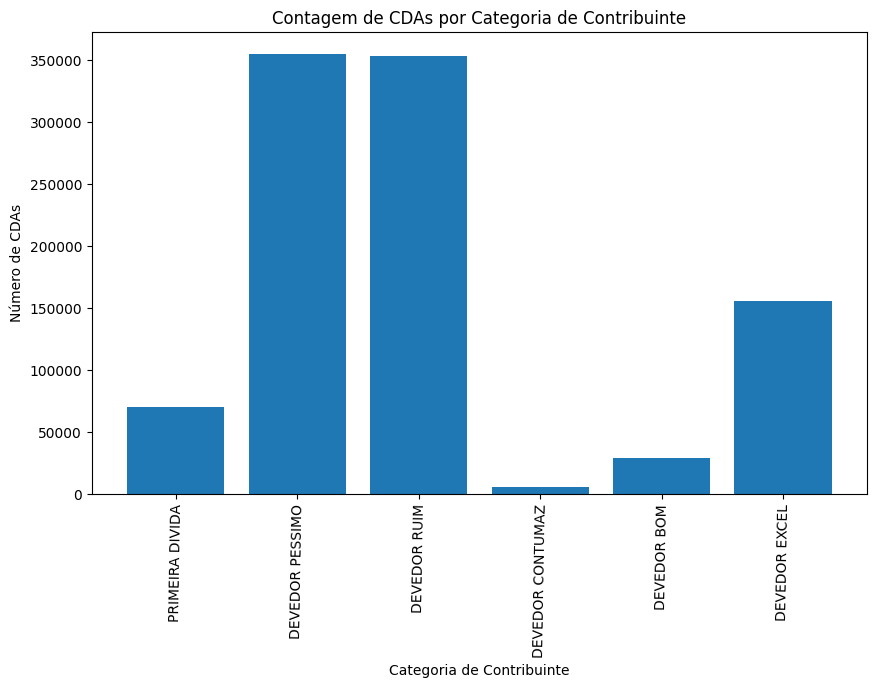

In [35]:
# K = 5
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))

categorias = matriz_distribuicao_cda_k5.columns
contagens = matriz_distribuicao_cda_k5.sum()

plt.bar(categorias, contagens)

plt.xlabel('Categoria de Contribuinte')
plt.ylabel('Número de CDAs')

plt.title('Contagem de CDAs por Categoria de Contribuinte')

plt.xticks(rotation=89)
plt.show()


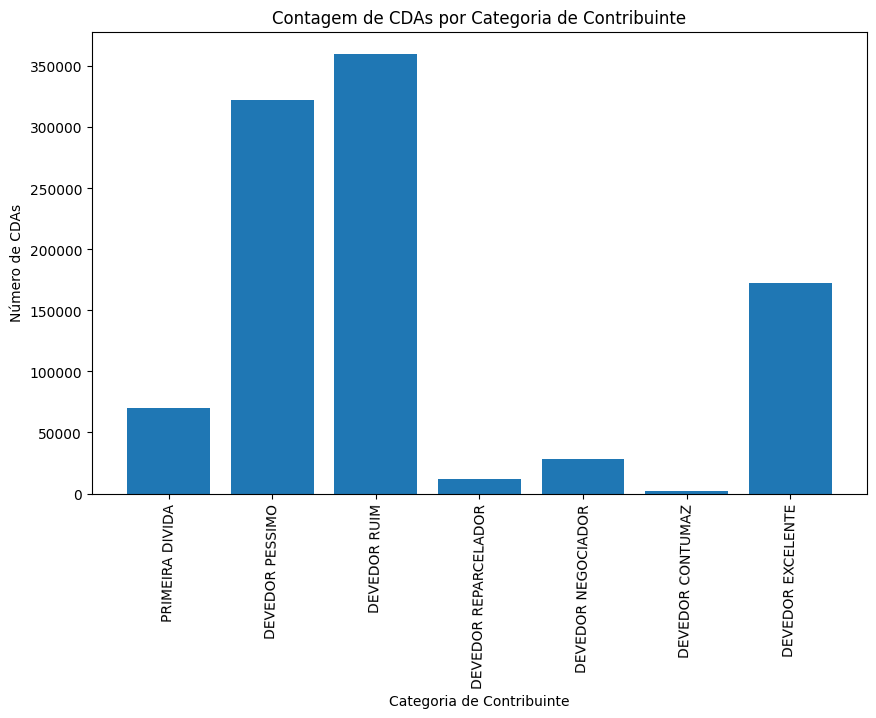

In [36]:
# K = 6
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))

categorias = matriz_distribuicao_cda_k6.columns
contagens = matriz_distribuicao_cda_k6.sum()

plt.bar(categorias, contagens)

plt.xlabel('Categoria de Contribuinte')
plt.ylabel('Número de CDAs')

plt.title('Contagem de CDAs por Categoria de Contribuinte')

plt.xticks(rotation=89)
plt.show()


In [31]:
# da_aberta = dados_igr_cunha[dados_igr_cunha['da_aberto'] == 1]
cluster_k5 = pd.pivot_table(baseline_prime_k5, values='valor_total_da', 
                              index='rating_divida', 
                              columns='class_contribuinte_nome', 
                              aggfunc='sum', 
                              fill_value=0)
devedor = ['PRIMEIRA DIVIDA', 'DEVEDOR PESSIMO', 'DEVEDOR RUIM', 'DEVEDOR CONTUMAZ', 'DEVEDOR BOM', 'DEVEDOR EXCEL']
cluster_k5 = cluster_k5[devedor]

contribuinte = ['BAIXISSIMA', 'BAIXA', 'MEDIA', 'ALTA', 'ALTISSIMA']
cluster_k5 = cluster_k5.reindex(contribuinte)

cluster_k5 = cluster_k5.applymap(formatar_moeda)

cluster_k5

class_contribuinte_nome,PRIMEIRA DIVIDA,DEVEDOR PESSIMO,DEVEDOR RUIM,DEVEDOR CONTUMAZ,DEVEDOR BOM,DEVEDOR EXCEL
rating_divida,,,,,,
BAIXISSIMA,"R$ 706.461.795,53","R$ 3.942.457.018,98","R$ 5.017.583.931,59","R$ 155.366.796,92","R$ 313.360.047,42","R$ 291.012.711,63"
BAIXA,"R$ 0,00","R$ 128.545.751,86","R$ 687.352.595,27","R$ 16.782,94","R$ 0,00","R$ 0,00"
MEDIA,"R$ 1.238.973,11","R$ 0,00","R$ 1.705.583.686,79","R$ 1.916.018,10","R$ 2.362.773,77","R$ 2.580,07"
ALTA,"R$ 14.644.239,26","R$ 0,00","R$ 1.196.959,31","R$ 15.454.000,99","R$ 45.272.870,78","R$ 1.748.037,53"
ALTISSIMA,"R$ 94.535.360,00","R$ 0,00","R$ 0,00","R$ 1.373.643,96","R$ 81.552.344,84","R$ 654.298.188,93"


In [30]:
# da_aberta = dados_igr_cunha[dados_igr_cunha['da_aberto'] == 1]
cluster_k6 = pd.pivot_table(baseline_prime_k6, values='valor_total_da', 
                              index='rating_divida', 
                              columns='class_contribuinte_nome', 
                              aggfunc='sum', 
                              fill_value=0)
devedor = ['PRIMEIRA DIVIDA', 'DEVEDOR PESSIMO', 'DEVEDOR RUIM', 'DEVEDOR REPARCELADOR', 'DEVEDOR NEGOCIADOR', 'DEVEDOR CONTUMAZ', 'DEVEDOR EXCELENTE']
cluster_k6 = cluster_k6[devedor]

contribuinte = ['BAIXISSIMA', 'BAIXA', 'MEDIA', 'ALTA', 'ALTISSIMA']
cluster_k6 = cluster_k6.reindex(contribuinte)

cluster_k6 = cluster_k6.applymap(formatar_moeda)

cluster_k6

class_contribuinte_nome,PRIMEIRA DIVIDA,DEVEDOR PESSIMO,DEVEDOR RUIM,DEVEDOR REPARCELADOR,DEVEDOR NEGOCIADOR,DEVEDOR CONTUMAZ,DEVEDOR EXCELENTE
rating_divida,,,,,,,
BAIXISSIMA,"R$ 620.594.222,65","R$ 3.267.049.906,12","R$ 4.353.729.429,44","R$ 146.711.519,86","R$ 118.857.553,83","R$ 30.381.210,36","R$ 348.579.193,37"
BAIXA,"R$ 0,00","R$ 394.588.342,43","R$ 1.656.848.399,96","R$ 5.985.904,85","R$ 2.462.349,06","R$ 115.954,41","R$ 0,00"
MEDIA,"R$ 12.412.523,55","R$ 0,00","R$ 1.561.478.545,36","R$ 61.441.394,20","R$ 60.775.631,74","R$ 36.540.816,59","R$ 6.706,86"
ALTA,"R$ 9.034.374,97","R$ 0,00","R$ 166.715,13","R$ 56.916.817,91","R$ 85.315.696,71","R$ 15.695.131,39","R$ 7.613.642,81"
ALTISSIMA,"R$ 174.839.246,73","R$ 0,00","R$ 0,00","R$ 0,00","R$ 18.306.749,27","R$ 133.648,71","R$ 816.755.481,31"


# Comparação do rating com k = 5 e k = 6

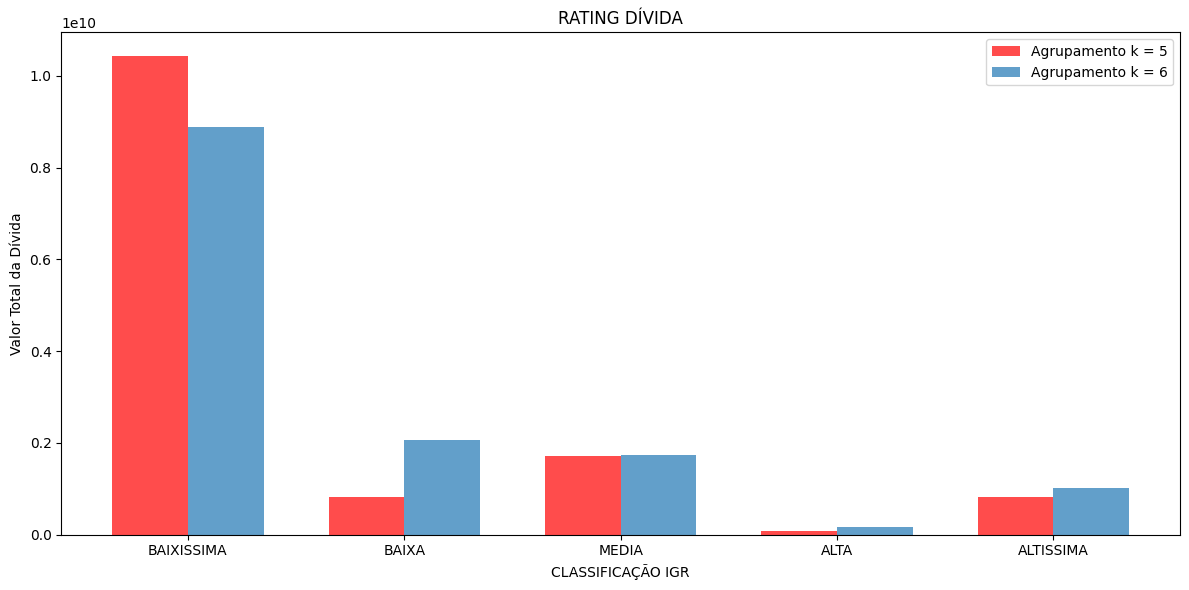

In [32]:
ordered_rating = pd.Categorical(['BAIXISSIMA', 'BAIXA', 'MEDIA', 'ALTA', 'ALTISSIMA'],
                                categories=['BAIXISSIMA', 'BAIXA', 'MEDIA', 'ALTA', 'ALTISSIMA'],
                                ordered=True)

# Crie DataFrames para as métricas antigo e atual
metricas_k5 = baseline_prime_k5[baseline_prime_k5['da_aberto'] == 1]
metricas_k5 = metricas_k5.groupby('rating_divida')['valor_total_da'].sum()
metricas_k5 = metricas_k5[ordered_rating].tolist()

metricas_k6 = baseline_prime_k6[baseline_prime_k6['da_aberto'] == 1]
metricas_k6 = metricas_k6.groupby('rating_divida')['valor_total_da'].sum()
metricas_k6 = metricas_k6[ordered_rating].tolist()

# Configurar a largura das barras e a posição dos grupos de barras
largura_barra = 0.35
posicao_barras = np.arange(len(ordered_rating))

plt.figure(figsize=(12, 6))
bar1 = plt.bar(posicao_barras - largura_barra/2, metricas_k5, largura_barra, label='Agrupamento k = 5', alpha=0.7, color='red')
bar2 = plt.bar(posicao_barras + largura_barra/2, metricas_k6, largura_barra, label='Agrupamento k = 6', alpha=0.7)

plt.xlabel('CLASSIFICAÇÃO IGR')
plt.ylabel('Valor Total da Dívida')
plt.title('RATING DÍVIDA')
plt.xticks(posicao_barras, ordered_rating)
plt.legend()

plt.tight_layout()
#plt.style.use('seaborn')
plt.show()


---

In [39]:
baseline_beta.columns

Index(['cda', 'id_contribuinte', 'cpf_cnpj_existe', 'da_aberto',
       'atividade_principal', 'valor_total_da', 'vlr_pago', 'vlr_tributo',
       'vlr_taxa', 'arrecadacao_divida', 'ajuizamento_divida', 'ajuizamento',
       'protesto', 'competencia_divida', 'refis', 'tipo_divida',
       'ano_inscricao_da', 'quantidade_reparcelamento', 'situacao',
       'anos_idade_da', 'id_pessoa', 'edificacao', 'qtd_notas_2anos',
       'situacao_ativa', 'status_situacao', 'frequencia_da_pessoa',
       'historico_pagamento_em_qtd', 'historico_pagamento_em_valor',
       'class_contribuinte', 'class_contribuinte_nome',
       'class_contribuinte_peso', 'igr', 'rating_divida'],
      dtype='object')

In [55]:
df = baseline_beta[baseline_beta['cda'] == 'c317818256f691129fcacff532cf50c4E']
df[['qtd_notas_2anos', 'edificacao', 'situacao', 'situacao_ativa', 'status_situacao']]

,qtd_notas_2anos,edificacao,situacao,situacao_ativa,status_situacao
1839719,0.0,1,SUSPENSO,2.0,3.0


In [56]:
df6 = baseline_beta[baseline_beta['id_pessoa'] == 'def2e7cb1e2f6ae1' ]
df6[[ 'id_pessoa','cda','edificacao','qtd_notas_2anos', 'situacao', 'cpf_cnpj_existe', 'situacao_ativa', 'status_situacao']]

,id_pessoa,cda,edificacao,qtd_notas_2anos,situacao,cpf_cnpj_existe,situacao_ativa,status_situacao
283012,def2e7cb1e2f6ae1,1e20ba0d1e15e7ce6b3a8e268c80aedf1,1,0.0,ATIVO,1,2.0,3.0
683158,def2e7cb1e2f6ae1,4894e51fddc4975eb5eae1a923f0f870E,1,0.0,SUSPENSO,1,2.0,3.0
966898,def2e7cb1e2f6ae1,668a98cb5c02791d7c8fa7a67092eaab1,1,0.0,ATIVO,1,2.0,3.0
1385928,def2e7cb1e2f6ae1,92f6b33c38d185f8d8a3e5cebc255ca61,1,0.0,ATIVO,1,2.0,3.0
1656437,def2e7cb1e2f6ae1,afa565964d22062018565e26094f06ee1,1,0.0,ATIVO,1,2.0,3.0
1657344,def2e7cb1e2f6ae1,afbe2b5ba23d207e18565e26094f06ee1,1,0.0,ATIVO,1,2.0,3.0
1812117,def2e7cb1e2f6ae1,c028e426135d58e69989bae6f4af91ee1,1,0.0,ATIVO,1,2.0,3.0
1839719,def2e7cb1e2f6ae1,c317818256f691129fcacff532cf50c4E,1,0.0,SUSPENSO,1,2.0,3.0
2344102,def2e7cb1e2f6ae1,f87af12d6aaf3d42d8a3e5cebc255ca61,1,0.0,ATIVO,1,2.0,3.0


In [57]:
df2 = baseline_14BI[baseline_14BI['id_pessoa'] == 'def2e7cb1e2f6ae1']
df2[[ 'id_pessoa','edificacao','qtd_notas_2anos', 'situacao', 'cpf_cnpj_existe', 'situacao_ativa', 'status_situacao']]

,id_pessoa,edificacao,qtd_notas_2anos,situacao,cpf_cnpj_existe,situacao_ativa,status_situacao
278812,def2e7cb1e2f6ae1,1.0,0.0,SUSPENSO,1,2.0,3.0
750768,def2e7cb1e2f6ae1,1.0,0.0,SUSPENSO,1,2.0,3.0


In [58]:
df5 = baseline_14BI[baseline_14BI['id_pessoa'] == 'def2e7cb1e2f6ae1' ]
df5

,cda,id_contribuinte,cpf_cnpj_existe,da_aberto,atividade_principal,valor_total_da,vlr_pago,vlr_tributo,vlr_taxa,arrecadacao_divida,...,situacao_ativa,status_situacao,frequencia_da_pessoa,historico_pagamento_em_qtd,historico_pagamento_em_valor,class_contribuinte,class_contribuinte_nome,class_contribuinte_peso,igr,rating_divida
278812,4894e51fddc4975eb5eae1a923f0f870E,def2e7cb1e2f6ae1,1,1,ATIVIDADES DE CONDICIONAMENTO FÍSICO,9846.26,0.0,9846.26,0.0,0,...,2.0,3.0,9.0,0.843137,0.107239,2.0,MELHOR PAGADOR,4.68032,0.739157,ALTISSIMA
750768,c317818256f691129fcacff532cf50c4E,def2e7cb1e2f6ae1,1,1,ATIVIDADES DE CONDICIONAMENTO FÍSICO,23753.86,0.0,23753.86,0.0,0,...,2.0,3.0,9.0,0.843137,0.107239,2.0,MELHOR PAGADOR,4.68032,0.640446,ALTISSIMA


In [59]:
versao_1 = dados_igr_cunha[(dados_igr_cunha['da_aberto'] == 1)&(dados_igr_cunha['anos_idade_da'] < 15)]
versao_2 = dados_igr_antigo[(dados_igr_antigo['da_aberto'] == 1)&(dados_igr_antigo['anos_idade_da'] < 15)]
versao_3 = dados_igr[(dados_igr['da_aberto'] == 1)&(dados_igr['anos_idade_da'] < 15)]
versao_4 = dados_igr_sem_parcelas[(dados_igr_sem_parcelas['da_aberto'] == 1)&(dados_igr_sem_parcelas['anos_idade_da'] < 15)]
versao_5 = dados_igr_sem_parcelas_com_cpf[(dados_igr_sem_parcelas_com_cpf['da_aberto'] == 1)&(dados_igr_sem_parcelas_com_cpf['anos_idade_da'] < 15)]
versao_6 = baseline_beta[(baseline_beta['da_aberto'] == 1)&(baseline_beta['anos_idade_da'] < 15)]
versao_7 = baseline_14BI[(baseline_14BI['da_aberto'] == 1)&(baseline_14BI['anos_idade_da'] < 15)]
versao_8 = baseline_prime[(baseline_prime['da_aberto'] == 1)&(baseline_prime['idade_divida'] < 15)]
versao_9 = baseline_prime_k5[(baseline_prime_k5['da_aberto'] == 1)&(baseline_prime_k5['idade_divida'] < 15)]

In [60]:
versao_7.columns

Index(['cda', 'id_contribuinte', 'cpf_cnpj_existe', 'da_aberto',
       'atividade_principal', 'valor_total_da', 'vlr_pago', 'vlr_tributo',
       'vlr_taxa', 'arrecadacao_divida', 'ajuizamento_divida', 'ajuizamento',
       'protesto', 'competencia_divida', 'refis', 'tipo_divida',
       'quantidade_reparcelamento', 'situacao', 'anos_idade_da', 'id_pessoa',
       'edificacao', 'qtd_notas_2anos', 'situacao_ativa', 'status_situacao',
       'frequencia_da_pessoa', 'historico_pagamento_em_qtd',
       'historico_pagamento_em_valor', 'class_contribuinte',
       'class_contribuinte_nome', 'class_contribuinte_peso', 'igr',
       'rating_divida'],
      dtype='object')

In [77]:
versao_8.columns

Index(['cda', 'tipo_divida', 'id_pessoa', 'da_aberto', 'percentual_pago_cda',
       'valor_total_da', 'idade_divida', 'num_dist_cda',
       'quantidade_reparcelamento', 'historico_pagamento_em_valor',
       'situacao_cobranca', 'class_contribuinte', 'class_contribuinte_peso',
       'igr', 'rating_divida', 'class_contribuinte_nome',
       'class_contribuinte_perfil'],
      dtype='object')

In [16]:
versao_8

,cda,tipo_divida,id_pessoa,da_aberto,percentual_pago_cda,valor_total_da,idade_divida,num_dist_cda,quantidade_reparcelamento,historico_pagamento_em_valor,situacao_cobranca,class_contribuinte,class_contribuinte_peso,igr,rating_divida
0,00000123c3d4731c6b3a8e268c80aedf1,imovel,ac28642d7c82b33f,1,0.0,2048.73,1.0,2,0,0.0,4.0,2,1.56033,0.670109,ALTISSIMA
1,00000123c3d4731c6b3a8e268c80aedf2,mercantil,fc4b99b807fbed41,1,0.0,2515.85,1.0,3,0,0.0,0.0,0,-1.27335,0.000000,BAIXISSIMA
2,000014e359592e62d8a3e5cebc255ca6E,mercantil,6dbe14da38a31dc1,1,0.0,847.02,0.0,4,3,0.0,0.0,0,-1.27335,0.000000,BAIXISSIMA
3,0000331f601a73e52b46f673bf0c61252,mercantil,e8424494daac9641,1,0.0,5385.81,11.0,4,0,0.0,0.0,0,-1.27335,0.000000,BAIXISSIMA
4,00003d46e618da886b3a8e268c80aedf1,imovel,d8b23eda9800b9e3,1,0.0,6434.96,12.0,4,0,0.0,0.0,0,-1.27335,0.000000,BAIXISSIMA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
967072,ffff38bad317e76fb5eae1a923f0f8701,imovel,a32828fd20050b8b,1,0.0,301.70,2.0,2,0,0.0,4.0,2,1.56033,0.736347,ALTISSIMA
967073,ffff738c25e8a9bcd8a3e5cebc255ca62,mercantil,99c8662cfbd8adde,1,0.0,5865.34,10.0,5,0,0.0,0.0,0,-1.27335,0.000000,BAIXISSIMA
967074,ffffca43e897bbf0d8a3e5cebc255ca61,imovel,cad70f5b8701af03,1,0.0,5082.97,11.0,5,0,0.0,0.0,0,-1.27335,0.000000,BAIXISSIMA
967075,ffffca43e897bbf0d8a3e5cebc255ca62,mercantil,e750ab1d88feb1ba,1,0.0,7634.36,11.0,6,0,0.0,0.0,0,-1.27335,0.000000,BAIXISSIMA


In [23]:
filtro = (
    # (versao_8['da_aberto'] == 1)
    # (versao_7['anos_idade_da']  0) &
    # (versao_7['rating_divida'] == 'BAIXISSIMA') &
    # (versao_7['class_contribuinte_nome'] == 'PRIMEIRA DIVIDA') &
    # (versao_7['igr'] == 0) #& (versao_7['igr'] <= 0.9)
)

resultado = versao_9.loc[filtro, 'valor_total_da'].sum()

valor_formatado = formatar_moeda(resultado)
valor_formatado

'R$ 8.064.219.163,79'

# ACOMPANHAMENTO EVOLUÇÃO STATUS_SITUACAO

In [12]:
dataframes = [versao_1, versao_2, versao_3, versao_4, versao_5, versao_6, versao_7, versao_8, versao_9]

# Inicialize um dicionário para armazenar as somas
somas = {}
for idx, df in enumerate(dataframes, start=1):
    soma = df.groupby('rating_divida')['valor_total_da'].sum().reset_index()
    coluna_soma = f'versao_{idx}'
    soma.rename(columns={'valor_total_da': coluna_soma}, inplace=True)
    somas[coluna_soma] = soma

status_somas = somas['versao_1']
for coluna_soma in somas.keys():
    if coluna_soma != 'versao_1':
        status_somas = status_somas.merge(somas[coluna_soma], on='rating_divida', how='outer')

status_somas.fillna(0, inplace=True)

status_somas.set_index('rating_divida', inplace=True)

matriz_somas = status_somas.applymap(formatar_moeda)
matriz_somas


,versao_1,versao_2,versao_3,versao_4,versao_5,versao_6,versao_7,versao_8,versao_9
rating_divida,,,,,,,,,
ALTA,"R$ 489.075.690,83","R$ 258.008.214,34","R$ 643.899.403,51","R$ 391.199.833,22","R$ 391.570.246,70","R$ 525.184.034,00","R$ 762.516.733,30","R$ 36.805.954,85","R$ 545.466.128,66"
ALTISSIMA,"R$ 101.387.136,32","R$ 76.279.507,72","R$ 85.484.404,96","R$ 110.600.560,59","R$ 113.740.590,01","R$ 561.182.835,82","R$ 429.608.791,07","R$ 2.657.911.904,05","R$ 2.609.025.604,29"
BAIXA,"R$ 1.770.251.147,02","R$ 1.502.223.149,44","R$ 319.843.404,52","R$ 36.503.735,20","R$ 51.561.789,23","R$ 3.217.496.641,67","R$ 1.869.855.614,05","R$ 736.190.683,17","R$ 128.562.534,80"
BAIXISSIMA,"R$ 2.540.743.812,64","R$ 4.329.374.910,88","R$ 5.346.672.188,75","R$ 7.277.912.436,05","R$ 7.238.027.139,81","R$ 3.488.413.781,38","R$ 2.974.834.884,23","R$ 4.627.124.356,28","R$ 4.627.124.356,28"
MEDIA,"R$ 3.358.887.800,15","R$ 1.882.423.964,62","R$ 1.652.573.213,83","R$ 232.256.050,51","R$ 253.572.849,82","R$ 2.099.431.595,76","R$ 2.011.644.661,07","R$ 6.186.265,44","R$ 43.621.967,39"


# ACOMPANHAMENTO EVOLUÇÃO RATING

In [61]:
dataframes = [versao_1, versao_2, versao_3, versao_4, versao_5, versao_6, versao_7, versao_8, versao_9]

# Inicialize um dicionário para armazenar as somas
somas = {}
for idx, df in enumerate(dataframes, start=1):
    soma = df.groupby('rating_divida')['valor_total_da'].sum().reset_index()
    coluna_soma = f'versao_{idx}'
    soma.rename(columns={'valor_total_da': coluna_soma}, inplace=True)
    somas[coluna_soma] = soma

rating_somas = somas['versao_1']
for coluna_soma in somas.keys():
    if coluna_soma != 'versao_1':
        rating_somas = rating_somas.merge(somas[coluna_soma], on='rating_divida', how='outer')

rating_somas.fillna(0, inplace=True)


rating_somas.set_index('rating_divida', inplace=True)

rating_somas = rating_somas.applymap(formatar_moeda)
rating_somas

,versao_1,versao_2,versao_3,versao_4,versao_5,versao_6,versao_7,versao_8,versao_9
rating_divida,,,,,,,,,
ALTA,"R$ 489.075.690,83","R$ 258.008.214,34","R$ 643.899.403,51","R$ 391.199.833,22","R$ 391.570.246,70","R$ 525.184.034,00","R$ 762.516.733,30","R$ 36.805.954,85","R$ 78.316.107,87"
ALTISSIMA,"R$ 101.387.136,32","R$ 76.279.507,72","R$ 85.484.404,96","R$ 110.600.560,59","R$ 113.740.590,01","R$ 561.182.835,82","R$ 429.608.791,07","R$ 2.657.911.904,05","R$ 831.759.537,73"
BAIXA,"R$ 1.770.251.147,02","R$ 1.502.223.149,44","R$ 319.843.404,52","R$ 36.503.735,20","R$ 51.561.789,23","R$ 3.217.496.641,67","R$ 1.869.855.614,05","R$ 736.190.683,17","R$ 815.915.130,07"
BAIXISSIMA,"R$ 2.540.743.812,64","R$ 4.329.374.910,88","R$ 5.346.672.188,75","R$ 7.277.912.436,05","R$ 7.238.027.139,81","R$ 3.488.413.781,38","R$ 2.974.834.884,23","R$ 4.627.124.356,28","R$ 4.627.124.356,28"
MEDIA,"R$ 3.358.887.800,15","R$ 1.882.423.964,62","R$ 1.652.573.213,83","R$ 232.256.050,51","R$ 253.572.849,82","R$ 2.099.431.595,76","R$ 2.011.644.661,07","R$ 6.186.265,44","R$ 1.711.104.031,84"


In [32]:
ws = versao_9[versao_9['class_contribuinte_nome'] != 'ALTISSIMA']
ws = ws[ws['rating_divida'] != 'BAIXISSIMA']
ws = ws[ws['rating_divida'] != 'ALTA']
ws = ws[ws['rating_divida'] != 'MEDIA']
ws = ws[ws['rating_divida'] != 'BAIXA']
ws

,cda,tipo_divida,id_pessoa,da_aberto,percentual_pago_cda,valor_total_da,idade_divida,num_dist_cda,quantidade_reparcelamento,historico_pagamento_em_valor,situacao_cobranca,class_contribuinte,class_contribuinte_peso,igr,rating_divida,class_contribuinte_nome,class_contribuinte_perfil
10,0000a43dae672b166b3a8e268c80aedf1,imovel,f5fe60dbb517e68a,1,0.0,2108.87,1.0,1,0,0.0,4.0,5,0.53287,0.671829,NaN,PRIMEIRA DIVIDA,NOVO EM DIVIDA
45,0002f892d75b28327c8fa7a67092eaab1,imovel,779f13e854f420bd,1,0.0,3357.19,1.0,1,0,0.0,4.0,5,0.53287,0.864115,NaN,PRIMEIRA DIVIDA,NOVO EM DIVIDA
94,00061955c4160798b5eae1a923f0f8701,imovel,612cf02fefc3dd86,1,0.0,804.00,1.0,1,0,0.0,4.0,5,0.53287,0.776385,NaN,PRIMEIRA DIVIDA,NOVO EM DIVIDA
123,00084ce862b9a6ec9989bae6f4af91ee1,imovel,2bad85c853783bdb,1,0.0,107.31,1.0,1,0,0.0,4.0,5,0.53287,0.809535,NaN,PRIMEIRA DIVIDA,NOVO EM DIVIDA
130,00092328cdf279cfb5eae1a923f0f8701,imovel,e8c7fd06b496b422,1,0.0,436.00,1.0,1,0,0.0,4.0,5,0.53287,0.613167,NaN,PRIMEIRA DIVIDA,NOVO EM DIVIDA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
966963,fff88fbd56414c6018565e26094f06ee1,imovel,ba8a1e42b1fde7e1,1,0.0,645.82,1.0,1,0,0.0,4.0,5,0.53287,0.675742,NaN,PRIMEIRA DIVIDA,NOVO EM DIVIDA
967014,fffb5eb15261b6579989bae6f4af91ee1,imovel,33e33f9790ec47d1,1,0.0,506.68,1.0,1,0,0.0,4.0,5,0.53287,0.649613,NaN,PRIMEIRA DIVIDA,NOVO EM DIVIDA
967016,fffb832157690bb1d8a3e5cebc255ca61,imovel,71b4a509e023a38b,1,0.0,4202.26,11.0,1,0,0.0,1.0,5,0.53287,0.169192,NaN,PRIMEIRA DIVIDA,NOVO EM DIVIDA
967020,fffbc656a38a48fe9989bae6f4af91ee1,imovel,a408222571c32c15,1,0.0,95.56,1.0,1,0,0.0,4.0,5,0.53287,0.799535,NaN,PRIMEIRA DIVIDA,NOVO EM DIVIDA


In [163]:
filtro = (
    (baseline_prime_k5['rating_divida'] == 'ALTISSIMA') &
    (baseline_prime_k5['igr'] >= 0.9) & #(baseline_prime_k5['igr'] <0.9) &
    (baseline_prime_k5['class_contribuinte_nome'] == 'DEVEDOR EXCEL')
)

resultado = baseline_prime_k5.loc[filtro, 'valor_total_da'].sum()

valor_formatado = formatar_moeda(resultado)
valor_formatado

'R$ 7.232.448,62'

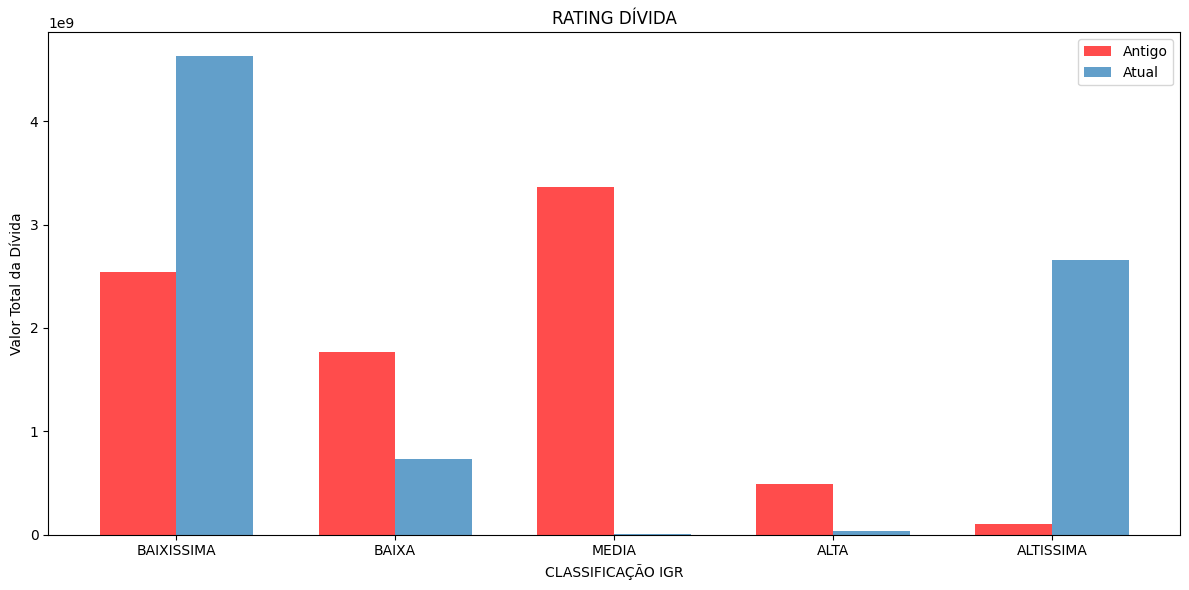

In [44]:
ordered_rating = pd.Categorical(['BAIXISSIMA', 'BAIXA', 'MEDIA', 'ALTA', 'ALTISSIMA'],
                                categories=['BAIXISSIMA', 'BAIXA', 'MEDIA', 'ALTA', 'ALTISSIMA'],
                                ordered=True)

# Crie DataFrames para as métricas antigo e atual
metricas_antigo = versao_1[versao_1['da_aberto'] == 1]
metricas_antigo = metricas_antigo.groupby('rating_divida')['valor_total_da'].sum()
metricas_antigo = metricas_antigo[ordered_rating].tolist()

metricas_atual = versao_8[versao_8['da_aberto'] == 1]
metricas_atual = metricas_atual.groupby('rating_divida')['valor_total_da'].sum()
metricas_atual = metricas_atual[ordered_rating].tolist()

# Configurar a largura das barras e a posição dos grupos de barras
largura_barra = 0.35
posicao_barras = np.arange(len(ordered_rating))

plt.figure(figsize=(12, 6))
bar1 = plt.bar(posicao_barras - largura_barra/2, metricas_antigo, largura_barra, label='Antigo', alpha=0.7, color='red')
bar2 = plt.bar(posicao_barras + largura_barra/2, metricas_atual, largura_barra, label='Atual', alpha=0.7)

plt.xlabel('CLASSIFICAÇÃO IGR')
plt.ylabel('Valor Total da Dívida')
plt.title('RATING DÍVIDA')
plt.xticks(posicao_barras, ordered_rating)
plt.legend()

plt.tight_layout()
#plt.style.use('seaborn')
plt.show()


In [ ]:
ajuiza = baseline_beta[baseline_beta['da_aberto'] == 1]
ajuiza = ajuiza[ajuiza['anos_idade_da'] < 15]
ajuiza = ajuiza[ajuiza['protesto'] == 1]
# ajuiza = ajuiza[ajuiza['cpf_cnpj_existe'] == 0]
# ajuiza = formatar_moeda(ajuiza['valor_total_da'].sum())
ajuiza[['cda', 'ano_inscricao_da','ajuizamento_divida', 'ajuizamento','tipo_divida', 'rating_divida', 'valor_total_da', 'vlr_pago']]
ajuiza

In [181]:
status_situacao0 = dados_igr_sem_parcelas_com_cpf[dados_igr_sem_parcelas_com_cpf['da_aberto'] == 1]
status_situacao0 = status_situacao0[status_situacao0['anos_idade_da'] < 15]
status_situacao0 = status_situacao0[status_situacao0['cpf_cnpj_existe'] == 0]
status_situacao0 = formatar_moeda(status_situacao0['valor_total_da'].sum())
status_situacao0

'R$ 680.498.673,13'

In [ ]:
# status_situacao0 = dados_igr_sem_parcelas_com_cpf[dados_igr_sem_parcelas_com_cpf['da_aberto'] == 1]
# status_situacao0 = status_situacao0[status_situacao0['tipo_divida'] == 'imovel']
# status_situacao0 = status_situacao0[status_situacao0['anos_idade_da'] < 15]
# status_situacao0 = status_situacao0[status_situacao0['edificacao'] == 0]
# status_situacao0 = status_situacao0[status_situacao0['cpf_cnpj_existe'] == 0]

status_situacao0 = dados_igr_sem_parcelas_com_cpf[dados_igr_sem_parcelas_com_cpf['da_aberto'] == 1]
status_situacao0 = status_situacao0[status_situacao0['tipo_divida'] == 'imovel']
status_situacao0 = status_situacao0[status_situacao0['anos_idade_da'] >= 15]

# status_situacao0 = status_situacao0[status_situacao0['qtd_notas_2anos'] == 0]
# status_situacao0 = status_situacao0[status_situacao0['situacao'] == 'ATIVO']
# status_situacao0 = status_situacao0[status_situacao0['cpf_cnpj_existe'] == 0]

status_situacao0

In [177]:
status_situacao0 = formatar_moeda(status_situacao0['valor_total_da'].sum())
status_situacao0

'R$ 2.222.699.401,18'

In [175]:
contagem_situacao = status_situacao0['situacao'].value_counts()
contagem_situacao

ATIVO                   43268
EM PROCESSO DE BAIXA    21213
0                          48
INAPTO                      7
SUSPENSO                    3
BAIXADO                     1
Name: situacao, dtype: int64

In [176]:
contagem_tipo_divida = status_situacao0['tipo_divida'].value_counts()
contagem_tipo_divida

imovel    64540
Name: tipo_divida, dtype: int64

## Check valores que zeram o igr

## anos_idade_da

In [ ]:
idade = dados_igr_cunha[dados_igr_cunha['anos_idade_da'] >= 15]
idade = idade[idade['da_aberto'] == 1]
idade = formatar_moeda(idade['valor_total_da'].sum())
idade

In [9]:
idade = dados_igr_antigo[dados_igr_antigo['anos_idade_da'] >= 15]
idade = idade[idade['da_aberto'] == 1]
idade = formatar_moeda(idade['valor_total_da'].sum())
idade

'R$ 6.562.348.824,53'

In [10]:
idade = dados_igr[dados_igr['anos_idade_da'] >= 15]
idade = idade[idade['da_aberto'] == 1]
idade = formatar_moeda(idade['valor_total_da'].sum())
idade

'R$ 6.558.556.428,03'

In [11]:
idade = dados_igr_sem_parcelas[dados_igr_sem_parcelas['anos_idade_da'] >= 15]
idade = idade[idade['da_aberto'] == 1]
idade = formatar_moeda(idade['valor_total_da'].sum())
idade

'R$ 6.558.556.428,03'

In [12]:
idade = dados_igr_sem_parcelas_com_cpf[dados_igr_sem_parcelas_com_cpf['anos_idade_da'] >= 15]
idade = idade[idade['da_aberto'] == 1]
idade = formatar_moeda(idade['valor_total_da'].sum())
idade

'R$ 6.558.556.428,03'

## status_situacao

In [ ]:
da_aberta = dados_igr_cunha[dados_igr_cunha['da_aberto'] == 1]
check = pd.pivot_table(da_aberta, values='valor_total_da', 
                              index='status_situacao', 
                              columns='class_contribuinte_nome', 
                              aggfunc='sum', 
                              fill_value=0)
rating = ['PRIMEIRA DIVIDA', 'PIOR PAGADOR', 'PAGADOR INTERMEDIARIO', 'BOM PAGADOR', 'MELHOR PAGADOR']
check = check[rating]

contribuinte = ['BAIXISSIMA', 'BAIXA', 'MEDIA', 'ALTA', 'ALTISSIMA']
check = check.reindex(contribuinte)

check = check.applymap(formatar_moeda)

check

In [13]:
status_situacao = dados_igr_cunha[dados_igr_cunha['status_situacao'] == 0]
status_situacao = status_situacao[status_situacao['da_aberto'] == 1]
status_situacao = formatar_moeda(status_situacao['valor_total_da'].sum())
status_situacao

'R$ 4.717.933.251,46'

In [14]:
status_situacao = dados_igr_antigo[dados_igr_antigo['status_situacao'] == 0]
status_situacao = status_situacao[status_situacao['da_aberto'] == 1]
status_situacao = formatar_moeda(status_situacao['valor_total_da'].sum())
status_situacao

'R$ 6.420.590.727,63'

In [15]:
status_situacao = dados_igr[dados_igr['status_situacao'] == 0]
status_situacao = status_situacao[status_situacao['da_aberto'] == 1]
status_situacao = formatar_moeda(status_situacao['valor_total_da'].sum())
status_situacao

'R$ 9.025.826.755,29'

In [16]:
status_situacao = dados_igr_sem_parcelas[dados_igr_sem_parcelas['status_situacao'] == 0]
status_situacao = status_situacao[status_situacao['da_aberto'] == 1]
status_situacao = formatar_moeda(status_situacao['valor_total_da'].sum())
status_situacao

'R$ 6.130.064.836,06'

In [17]:
status_situacao = dados_igr_sem_parcelas_com_cpf[dados_igr_sem_parcelas_com_cpf['status_situacao'] == 0]
status_situacao = status_situacao[status_situacao['da_aberto'] == 1]
status_situacao = formatar_moeda(status_situacao['valor_total_da'].sum())
status_situacao

'R$ 5.209.086.384,45'

---

dados_igr_cunha
dados_igr_antigo
dados_igr
dados_igr_sem_parcelas
dados_igr_sem_parcelas_com_cpf
baseline_beta
baseline_14BI
baseline_prime

# Distribuição dados_igr_cunha 1 versao

In [45]:
da_aberta = dados_igr_cunha[dados_igr_cunha['da_aberto'] == 1]
check = pd.pivot_table(da_aberta, values='valor_total_da', 
                              index='rating_divida', 
                              columns='class_contribuinte_nome', 
                              aggfunc='sum', 
                              fill_value=0)
rating = ['PRIMEIRA DIVIDA', 'PIOR PAGADOR', 'PAGADOR INTERMEDIARIO', 'BOM PAGADOR', 'MELHOR PAGADOR']
check = check[rating]

contribuinte = ['BAIXISSIMA', 'BAIXA', 'MEDIA', 'ALTA', 'ALTISSIMA']
check = check.reindex(contribuinte)

check = check.applymap(formatar_moeda)

check

class_contribuinte_nome,PRIMEIRA DIVIDA,PIOR PAGADOR,PAGADOR INTERMEDIARIO,BOM PAGADOR,MELHOR PAGADOR
rating_divida,,,,,
BAIXISSIMA,"R$ 185.299.896,66","R$ 4.564.566.432,02","R$ 2.461.283.844,80","R$ 1.913.102.276,24","R$ 23.300.034,74"
BAIXA,"R$ 62.309.840,35","R$ 0,00","R$ 1.707.941.306,67","R$ 0,00","R$ 0,00"
MEDIA,"R$ 22.084.490,20","R$ 0,00","R$ 1.390.666.057,19","R$ 1.946.137.252,76","R$ 0,00"
ALTA,"R$ 7.387.580,64","R$ 0,00","R$ 35.209.821,16","R$ 446.478.289,03","R$ 0,00"
ALTISSIMA,"R$ 0,00","R$ 0,00","R$ 0,00","R$ 23.119.677,14","R$ 78.267.459,18"


# Distribuição dados_igr_antigo 2 versão

In [46]:
da_aberta = dados_igr_antigo[dados_igr_antigo['da_aberto'] == 1]
check = pd.pivot_table(da_aberta, values='valor_total_da', 
                              index='rating_divida', 
                              columns='class_contribuinte_nome', 
                              aggfunc='sum', 
                              fill_value=0)
rating = ['PRIMEIRA DIVIDA', 'PIOR PAGADOR', 'PAGADOR INTERMEDIARIO', 'BOM PAGADOR', 'MELHOR PAGADOR']
check = check[rating]

contribuinte = ['BAIXISSIMA', 'BAIXA', 'MEDIA', 'ALTA', 'ALTISSIMA']
check = check.reindex(contribuinte)

check = check.applymap(formatar_moeda)

check

class_contribuinte_nome,PRIMEIRA DIVIDA,PIOR PAGADOR,PAGADOR INTERMEDIARIO,BOM PAGADOR,MELHOR PAGADOR
rating_divida,,,,,
BAIXISSIMA,"R$ 285.129.200,12","R$ 6.241.888.319,84","R$ 2.829.762.236,78","R$ 1.521.741.735,50","R$ 13.202.243,17"
BAIXA,"R$ 66.539.097,63","R$ 0,00","R$ 1.435.684.051,81","R$ 0,00","R$ 0,00"
MEDIA,"R$ 37.579.671,18","R$ 0,00","R$ 419.046.272,08","R$ 1.425.798.021,36","R$ 0,00"
ALTA,"R$ 5.593.658,52","R$ 0,00","R$ 17.470.649,61","R$ 234.943.906,21","R$ 0,00"
ALTISSIMA,"R$ 0,00","R$ 0,00","R$ 0,00","R$ 23.389.560,54","R$ 52.889.947,18"


# Distribuição dados_igr 3 versao

In [62]:
da_aberta = dados_igr[dados_igr['da_aberto'] == 1]
check = pd.pivot_table(da_aberta, values='valor_total_da', 
                              index='rating_divida', 
                              columns='class_contribuinte_nome', 
                              aggfunc='sum', 
                              fill_value=0)
rating = ['PRIMEIRA DIVIDA', 'PIOR PAGADOR', 'PAGADOR INTERMEDIARIO', 'BOM PAGADOR', 'MELHOR PAGADOR']
check = check[rating]

contribuinte = ['BAIXISSIMA', 'BAIXA', 'MEDIA', 'ALTA', 'ALTISSIMA']
check = check.reindex(contribuinte)

check = check.applymap(formatar_moeda)

check

class_contribuinte_nome,PRIMEIRA DIVIDA,PIOR PAGADOR,PAGADOR INTERMEDIARIO,BOM PAGADOR,MELHOR PAGADOR
rating_divida,,,,,
BAIXISSIMA,"R$ 344.570.798,69","R$ 8.687.932.296,93","R$ 612.092.594,34","R$ 2.241.659.747,12","R$ 18.973.179,70"
BAIXA,"R$ 27.893.602,64","R$ 0,00","R$ 291.949.801,88","R$ 0,00","R$ 0,00"
MEDIA,"R$ 17.651.162,42","R$ 0,00","R$ 29.644.073,22","R$ 1.605.277.978,19","R$ 0,00"
ALTA,"R$ 4.731.151,05","R$ 0,00","R$ 1.111.117,77","R$ 638.057.134,69","R$ 0,00"
ALTISSIMA,"R$ 0,00","R$ 0,00","R$ 0,00","R$ 9.739.396,22","R$ 75.745.008,74"


# Distribuição dados_igr_sem_parcelas 4 versao

In [63]:
da_aberta = dados_igr_sem_parcelas[dados_igr_sem_parcelas['da_aberto'] == 1]
check = pd.pivot_table(da_aberta, values='valor_total_da', 
                              index='rating_divida', 
                              columns='class_contribuinte_nome', 
                              aggfunc='sum', 
                              fill_value=0)
rating = ['PRIMEIRA DIVIDA', 'PIOR PAGADOR', 'PAGADOR INTERMEDIARIO', 'BOM PAGADOR', 'MELHOR PAGADOR']
check = check[rating]

contribuinte = ['BAIXISSIMA', 'BAIXA', 'MEDIA', 'ALTA', 'ALTISSIMA']
check = check.reindex(contribuinte)

check = check.applymap(formatar_moeda)

check

class_contribuinte_nome,PRIMEIRA DIVIDA,PIOR PAGADOR,PAGADOR INTERMEDIARIO,BOM PAGADOR,MELHOR PAGADOR
rating_divida,,,,,
BAIXISSIMA,"R$ 448.171.896,01","R$ 5.926.484.598,58","R$ 2.545.098.590,32","R$ 4.892.997.048,14","R$ 23.716.731,03"
BAIXA,"R$ 446.319,34","R$ 0,00","R$ 36.057.415,86","R$ 0,00","R$ 0,00"
MEDIA,"R$ 19.786,09","R$ 0,00","R$ 29.812.566,87","R$ 202.423.697,55","R$ 0,00"
ALTA,"R$ 9.484.053,63","R$ 0,00","R$ 3.693.234,74","R$ 378.022.544,85","R$ 0,00"
ALTISSIMA,"R$ 0,00","R$ 0,00","R$ 0,00","R$ 30.812.760,88","R$ 79.787.799,71"


# Distribuição dados_igr_sem_parcelas_com_cpf 5 versao

In [64]:
da_aberta = dados_igr_sem_parcelas_com_cpf[dados_igr_sem_parcelas_com_cpf['da_aberto'] == 1]
check = pd.pivot_table(da_aberta, values='valor_total_da', 
                              index='rating_divida', 
                              columns='class_contribuinte_nome', 
                              aggfunc='sum', 
                              fill_value=0)
rating = ['PRIMEIRA DIVIDA', 'PIOR PAGADOR', 'PAGADOR INTERMEDIARIO', 'BOM PAGADOR', 'MELHOR PAGADOR']
check = check[rating]

contribuinte = ['BAIXISSIMA', 'BAIXA', 'MEDIA', 'ALTA', 'ALTISSIMA']
check = check.reindex(contribuinte)

check = check.applymap(formatar_moeda)

check

class_contribuinte_nome,PRIMEIRA DIVIDA,PIOR PAGADOR,PAGADOR INTERMEDIARIO,BOM PAGADOR,MELHOR PAGADOR
rating_divida,,,,,
BAIXISSIMA,"R$ 387.917.902,51","R$ 5.049.585.917,23","R$ 3.456.210.830,47","R$ 4.862.051.841,26","R$ 22.021.645,75"
BAIXA,"R$ 1.516.660,17","R$ 0,00","R$ 75.059.141,13","R$ 0,00","R$ 0,00"
MEDIA,"R$ 23.847,64","R$ 0,00","R$ 51.014.772,77","R$ 203.063.186,44","R$ 0,00"
ALTA,"R$ 5.388.304,48","R$ 0,00","R$ 6.045.012,30","R$ 376.475.780,99","R$ 0,00"
ALTISSIMA,"R$ 0,00","R$ 0,00","R$ 0,00","R$ 31.989.820,23","R$ 78.664.380,23"


# Distribuição baseline_beta 6 versao

In [80]:
da_aberta = baseline_beta[baseline_beta['da_aberto'] == 1]
check = pd.pivot_table(da_aberta, values='valor_total_da', 
                              index='rating_divida', 
                              columns='class_contribuinte_nome', 
                              aggfunc='sum', 
                              fill_value=0)
rating = ['PRIMEIRA DIVIDA', 'PIOR PAGADOR', 'PAGADOR INTERMEDIARIO', 'BOM PAGADOR', 'MELHOR PAGADOR']
check = check[rating]

contribuinte = ['BAIXISSIMA', 'BAIXA', 'MEDIA', 'ALTA', 'ALTISSIMA']
check = check.reindex(contribuinte)

check = check.applymap(formatar_moeda)

check

class_contribuinte_nome,PRIMEIRA DIVIDA,PIOR PAGADOR,PAGADOR INTERMEDIARIO,BOM PAGADOR,MELHOR PAGADOR
rating_divida,,,,,
BAIXISSIMA,"R$ 232.844.667,63","R$ 6.586.129.144,44","R$ 1.458.815.383,00","R$ 1.305.124.175,33","R$ 49.456.961,19"
BAIXA,"R$ 80.784.944,54","R$ 13.023.906,09","R$ 3.123.687.791,04","R$ 0,00","R$ 0,00"
MEDIA,"R$ 7.415.450,28","R$ 0,00","R$ 621.641.471,12","R$ 1.470.374.674,36","R$ 0,00"
ALTA,"R$ 2.771.399,23","R$ 0,00","R$ 11.153.980,21","R$ 511.258.654,56","R$ 0,00"
ALTISSIMA,"R$ 0,00","R$ 0,00","R$ 0,00","R$ 16.239.702,16","R$ 544.943.133,66"


In [47]:
da_aberta = baseline_14BI[baseline_14BI['da_aberto'] == 1]
check = pd.pivot_table(da_aberta, values='valor_total_da', 
                              index='rating_divida', 
                              columns='class_contribuinte_nome', 
                              aggfunc='sum', 
                              fill_value=0)
rating = ['PRIMEIRA DIVIDA', 'PIOR PAGADOR', 'PAGADOR INTERMEDIARIO', 'BOM PAGADOR', 'MELHOR PAGADOR']
check = check[rating]

contribuinte = ['BAIXISSIMA', 'BAIXA', 'MEDIA', 'ALTA', 'ALTISSIMA']
check = check.reindex(contribuinte)

check = check.applymap(formatar_moeda)

check

class_contribuinte_nome,PRIMEIRA DIVIDA,PIOR PAGADOR,PAGADOR INTERMEDIARIO,BOM PAGADOR,MELHOR PAGADOR
rating_divida,,,,,
BAIXISSIMA,"R$ 269.458.880,24","R$ 6.385.927.541,07","R$ 1.438.142.015,13","R$ 1.387.509.870,35","R$ 52.364.937,32"
BAIXA,"R$ 69.551.513,92","R$ 13.521.693,15","R$ 1.786.782.406,98","R$ 0,00","R$ 0,00"
MEDIA,"R$ 3.713.416,98","R$ 0,00","R$ 868.808.535,41","R$ 1.139.122.708,68","R$ 0,00"
ALTA,"R$ 10.944.734,09","R$ 0,00","R$ 333.412.747,35","R$ 418.159.251,86","R$ 0,00"
ALTISSIMA,"R$ 0,00","R$ 0,00","R$ 0,00","R$ 164.982.140,73","R$ 264.626.650,34"


In [82]:
da_aberta = baseline_prime[baseline_prime['da_aberto'] == 1]
check = pd.pivot_table(da_aberta, values='valor_total_da', 
                              index='rating_divida', 
                              columns='class_contribuinte_nome', 
                              aggfunc='sum', 
                              fill_value=0)
rating = ['PRIMEIRA DIVIDA', 'DEVEDOR PESSIMO','DEVEDOR RUIM', 'DEVEDOR BOM', 'DEVEDOR EXCEL']
check = check[rating]

contribuinte = ['BAIXISSIMA', 'BAIXA', 'MEDIA', 'ALTA', 'ALTISSIMA']
check = check.reindex(contribuinte)

check = check.applymap(formatar_moeda)

check

class_contribuinte_nome,PRIMEIRA DIVIDA,DEVEDOR PESSIMO,DEVEDOR RUIM,DEVEDOR BOM,DEVEDOR EXCEL
rating_divida,,,,,
BAIXISSIMA,"R$ 706.461.795,53","R$ 8.038.645.201,12","R$ 155.385.385,66","R$ 520.476.881,85","R$ 1.005.273.037,91"
BAIXA,"R$ 0,00","R$ 736.190.683,17","R$ 0,00","R$ 0,00","R$ 0,00"
MEDIA,"R$ 5.155.793,79","R$ 0,00","R$ 915.138,58","R$ 115.333,07","R$ 0,00"
ALTA,"R$ 10.302.768,27","R$ 0,00","R$ 17.913.756,91","R$ 8.589.429,67","R$ 0,00"
ALTISSIMA,"R$ 94.960.010,31","R$ 0,00","R$ 0,00","R$ 191.940.052,64","R$ 2.371.011.841,10"


In [97]:
dev_excel = versao_8[versao_8['rating_divida'] == 'BAIXISSIMA']
dev_excel = dev_excel[dev_excel['da_aberto'] == 1]
dev_excel = dev_excel[dev_excel['class_contribuinte_nome'] == 'DEVEDOR EXCEL']
# dev_excel = formatar_moeda(dev_excel['valor_total_da'].sum())
dev_excel
# 00000123c3d4731c6b3a8e268c80aedf1

,cda,tipo_divida,id_pessoa,da_aberto,percentual_pago_cda,valor_total_da,idade_divida,num_dist_cda,quantidade_reparcelamento,historico_pagamento_em_valor,situacao_cobranca,class_contribuinte,class_contribuinte_peso,igr,rating_divida,class_contribuinte_nome,class_contribuinte_perfil


# Acessibilidade

In [92]:
# Classificação que zera por acessibilidade modelo anterior
da_aberta = baseline_14BI[baseline_14BI['da_aberto'] == 1]
cobr2 = pd.pivot_table(da_aberta, values='valor_total_da', 
                              index='status_situacao', 
                              columns='class_contribuinte_nome', 
                              aggfunc='sum', 
                              fill_value=0)
rating = ['PRIMEIRA DIVIDA', 'PIOR PAGADOR', 'PAGADOR INTERMEDIARIO', 'BOM PAGADOR', 'MELHOR PAGADOR']
cobr2 = cobr2[rating]

# contribuinte = ['BAIXISSIMA', 'BAIXA', 'MEDIA', 'ALTA', 'ALTISSIMA']
# cobr = cobr.reindex(contribuinte)

cobr2 = cobr2.applymap(formatar_moeda)

cobr2

class_contribuinte_nome,PRIMEIRA DIVIDA,PIOR PAGADOR,PAGADOR INTERMEDIARIO,BOM PAGADOR,MELHOR PAGADOR
status_situacao,,,,,
0.0,"R$ 149.426.934,07","R$ 6.377.563.392,66","R$ 0,00","R$ 0,00","R$ 0,00"
1.0,"R$ 6.719,98","R$ 21.885.841,56","R$ 0,00","R$ 1.174.041,08","R$ 0,00"
2.0,"R$ 156.903.702,04","R$ 0,00","R$ 0,00","R$ 3.108.599.930,54","R$ 489.381,06"
3.0,"R$ 47.331.189,14","R$ 0,00","R$ 4.427.145.704,87","R$ 0,00","R$ 316.502.206,60"


In [90]:
# Modelo atual
da_aberta = baseline_prime[baseline_prime['da_aberto'] == 1]
cobr = pd.pivot_table(da_aberta, values='valor_total_da', 
                              index='situacao_cobranca', 
                              columns='class_contribuinte_nome', 
                              aggfunc='sum', 
                              fill_value=0)
rating = ['PRIMEIRA DIVIDA', 'DEVEDOR PESSIMO','DEVEDOR RUIM', 'DEVEDOR BOM', 'DEVEDOR EXCEL']
cobr = cobr[rating]

# contribuinte = ['BAIXISSIMA', 'BAIXA', 'MEDIA', 'ALTA', 'ALTISSIMA']
# cobr = cobr.reindex(contribuinte)

cobr = cobr.applymap(formatar_moeda)

cobr

class_contribuinte_nome,PRIMEIRA DIVIDA,DEVEDOR PESSIMO,DEVEDOR RUIM,DEVEDOR BOM,DEVEDOR EXCEL
situacao_cobranca,,,,,
0.0,"R$ 613.353.522,17","R$ 7.365.329.270,93","R$ 155.139.689,59","R$ 489.561.891,19","R$ 0,00"
1.0,"R$ 64.265.349,55","R$ 1.409.506.613,36","R$ 372.014,73","R$ 6.433.159,51","R$ 0,00"
3.0,"R$ 2.120.529,04","R$ 0,00","R$ 263.078,18","R$ 1.957.536,41","R$ 9.811.024,08"
4.0,"R$ 137.140.967,14","R$ 0,00","R$ 18.439.498,65","R$ 223.169.110,12","R$ 3.366.473.854,93"


------------------------------------------------------

# comparativos por rating da divida

## ALTISSIMA

In [8]:
metricas_cunha = dados_igr_cunha[dados_igr_cunha['rating_divida'] == 'ALTISSIMA']
metricas_cunha = metricas_cunha[metricas_cunha['da_aberto'] == 1]
metricas_cunha = formatar_moeda(metricas_cunha['valor_total_da'].sum())
metricas_cunha

'R$ 101.387.136,32'

In [9]:
metricas_antigo = dados_igr_antigo[dados_igr_antigo['rating_divida'] == 'ALTISSIMA']
metricas_antigo = metricas_antigo[metricas_antigo['da_aberto'] == 1]
metricas_antigo = formatar_moeda(metricas_antigo['valor_total_da'].sum())
metricas_antigo

'R$ 76.279.507,72'

In [10]:
metricas_atual = dados_igr[dados_igr['rating_divida'] == 'ALTISSIMA']
metricas_atual = metricas_atual[metricas_atual['da_aberto'] == 1]
metricas_atual = formatar_moeda(metricas_atual['valor_total_da'].sum())
metricas_atual

'R$ 85.484.404,96'

In [11]:
metricas_sem_parcelas = dados_igr_sem_parcelas[dados_igr_sem_parcelas['rating_divida'] == 'ALTISSIMA']
metricas_sem_parcelas = metricas_sem_parcelas[metricas_sem_parcelas['da_aberto'] == 1]
metricas_sem_parcelas = formatar_moeda(metricas_sem_parcelas['valor_total_da'].sum())
metricas_sem_parcelas

'R$ 110.600.560,59'

In [13]:
metricas_sem_parcelas_com_cpf = dados_igr_sem_parcelas_com_cpf[dados_igr_sem_parcelas_com_cpf['rating_divida'] == 'ALTISSIMA']
metricas_sem_parcelas_com_cpf = metricas_sem_parcelas_com_cpf[metricas_sem_parcelas_com_cpf['da_aberto'] == 1]
metricas_sem_parcelas_com_cpf = formatar_moeda(metricas_sem_parcelas_com_cpf['valor_total_da'].sum())
metricas_sem_parcelas_com_cpf

'R$ 110.654.200,46'

In [11]:
baseline = baseline_beta[baseline_beta['rating_divida'] == 'ALTISSIMA']
baseline = baseline[baseline['da_aberto'] == 1]
baseline = formatar_moeda(baseline['valor_total_da'].sum())
baseline

'R$ 561.182.835,82'

In [ ]:
baseline_prime

---

In [30]:
#baseline = baseline_prime[baseline_prime['rating_divida'] == 'ALTISSIMA']
#baseline = baseline_prime[baseline_prime['da_aberto'] == 1]
baseline7 = formatar_moeda(baseline_prime['valor_total_da'].sum())
baseline7

'R$ 20.997.524.904,31'

In [24]:
baseline = baseline_prime[baseline_prime['rating_divida'] == 'ALTA']
baseline = baseline[baseline['da_aberto'] == 1]
baseline = formatar_moeda(baseline['valor_total_da'].sum())
baseline

'R$ 650.213.763,45'

In [25]:
baseline = baseline_prime[baseline_prime['rating_divida'] == 'MEDIA']
baseline = baseline[baseline['da_aberto'] == 1]
baseline = formatar_moeda(baseline['valor_total_da'].sum())
baseline

'R$ 332.279.111,19'

In [26]:
baseline = baseline_prime[baseline_prime['rating_divida'] == 'BAIXA']
baseline = baseline[baseline['da_aberto'] == 1]
baseline = formatar_moeda(baseline['valor_total_da'].sum())
baseline

'R$ 4.244.866.382,03'

In [28]:
baseline = baseline_prime[baseline_prime['rating_divida'] == 'BAIXISSIMA']
baseline 
# = baseline[baseline['da_aberto'] == 1]
# baseline = formatar_moeda(baseline['valor_total_da'].sum())
# baseline

,cda,tipo_divida,id_pessoa,da_aberto,percentual_pago_cda,valor_total_da,idade_divida,num_dist_cda,quantidade_reparcelamento,historico_pagamento_em_valor,situacao_cobranca,class_contribuinte,class_contribuinte_peso,igr,rating_divida
4,00000123c3d4731c6b3a8e268c80aedf2,mercantil,fc4b99b807fbed41,1,0.000397,2515.85,1.0,5,0,0.0,0.0,1,-1.21937,0.0,BAIXISSIMA
5,00000123c3d4731c6b3a8e268c80aedf2,mercantil,fc4b99b807fbed41,1,0.000397,2515.85,1.0,3,0,0.0,0.0,1,-1.21937,0.0,BAIXISSIMA
6,0a26ce0b18d13c8be52281a70553db462,mercantil,fc4b99b807fbed41,1,0.000151,6642.28,12.0,5,0,0.0,0.0,1,-1.21937,0.0,BAIXISSIMA
7,0a26ce0b18d13c8be52281a70553db462,mercantil,fc4b99b807fbed41,1,0.000151,6642.28,12.0,3,0,0.0,0.0,1,-1.21937,0.0,BAIXISSIMA
8,f7ae72ea774d98ba9fcacff532cf50c42,mercantil,fc4b99b807fbed41,1,0.000164,6105.68,11.0,5,0,0.0,0.0,1,-1.21937,0.0,BAIXISSIMA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1517358,fff6089dec430eef4bd01ecb8277da0b2,mercantil,2aafaa56adc95185,1,0.000205,4880.11,12.0,1,0,0.0,0.0,4,-0.04597,0.0,BAIXISSIMA
1517361,fff8ec32ac3528196b3a8e268c80aedf2,mercantil,f6efe48e460da7f9,1,0.001376,726.80,3.0,1,0,0.0,0.0,4,-0.04597,0.0,BAIXISSIMA
1517362,fff8ec32ac3528196b3a8e268c80aedf2,mercantil,f6efe48e460da7f9,1,0.001376,726.80,3.0,1,0,0.0,0.0,4,-0.04597,0.0,BAIXISSIMA
1517371,fffc43ac68640f569fcacff532cf50c42,mercantil,7297863dc9809347,1,0.000045,22275.52,9.0,1,0,0.0,0.0,4,-0.04597,0.0,BAIXISSIMA


---

## ALTA

In [14]:
metricas_cunha = dados_igr_cunha[dados_igr_cunha['rating_divida'] == 'ALTA']
metricas_cunha = metricas_cunha[metricas_cunha['da_aberto'] == 1]
metricas_cunha = formatar_moeda(metricas_cunha['valor_total_da'].sum())
metricas_cunha

'R$ 489.075.690,83'

In [15]:
metricas_antigo = dados_igr_antigo[dados_igr_antigo['rating_divida'] == 'ALTA']
metricas_antigo = metricas_antigo[metricas_antigo['da_aberto'] == 1]
metricas_antigo = formatar_moeda(metricas_antigo['valor_total_da'].sum())
metricas_antigo

'R$ 258.008.214,34'

In [16]:
metricas_atual = dados_igr[dados_igr['rating_divida'] == 'ALTA']
metricas_atual = metricas_atual[metricas_atual['da_aberto'] == 1]
metricas_atual = formatar_moeda(metricas_atual['valor_total_da'].sum())
metricas_atual

'R$ 643.899.403,51'

In [17]:
metricas_sem_parcelas = dados_igr_sem_parcelas[dados_igr_sem_parcelas['rating_divida'] == 'ALTA']
metricas_sem_parcelas = metricas_sem_parcelas[metricas_sem_parcelas['da_aberto'] == 1]
metricas_sem_parcelas = formatar_moeda(metricas_sem_parcelas['valor_total_da'].sum())
metricas_sem_parcelas

'R$ 391.199.833,22'

In [18]:
metricas_sem_parcelas_com_cpf = dados_igr_sem_parcelas_com_cpf[dados_igr_sem_parcelas_com_cpf['rating_divida'] == 'ALTA']
metricas_sem_parcelas_com_cpf = metricas_sem_parcelas_com_cpf[metricas_sem_parcelas_com_cpf['da_aberto'] == 1]
metricas_sem_parcelas_com_cpf = formatar_moeda(metricas_sem_parcelas_com_cpf['valor_total_da'].sum())
metricas_sem_parcelas_com_cpf

'R$ 387.909.097,77'

In [12]:
baseline = baseline_beta[baseline_beta['rating_divida'] == 'ALTA']
baseline = baseline[baseline['da_aberto'] == 1]
baseline = formatar_moeda(baseline['valor_total_da'].sum())
baseline

'R$ 525.184.034,00'

---

## MEDIA

In [19]:
metricas_cunha = dados_igr_cunha[dados_igr_cunha['rating_divida'] == 'MEDIA']
metricas_cunha = metricas_cunha[metricas_cunha['da_aberto'] == 1]
metricas_cunha = formatar_moeda(metricas_cunha['valor_total_da'].sum())
metricas_cunha

'R$ 3.358.887.800,15'

In [20]:
metricas_antigo = dados_igr_antigo[dados_igr_antigo['rating_divida'] == 'MEDIA']
metricas_antigo = metricas_antigo[metricas_antigo['da_aberto'] == 1]
metricas_antigo = formatar_moeda(metricas_antigo['valor_total_da'].sum())
metricas_antigo

'R$ 1.882.423.964,62'

In [21]:
metricas_atual = dados_igr[dados_igr['rating_divida'] == 'MEDIA']
metricas_atual = metricas_atual[metricas_atual['da_aberto'] == 1]
metricas_atual = formatar_moeda(metricas_atual['valor_total_da'].sum())
metricas_atual

'R$ 1.652.573.213,83'

In [22]:
metricas_sem_parcelas = dados_igr_sem_parcelas[dados_igr_sem_parcelas['rating_divida'] == 'MEDIA']
metricas_sem_parcelas = metricas_sem_parcelas[metricas_sem_parcelas['da_aberto'] == 1]
metricas_sem_parcelas = formatar_moeda(metricas_sem_parcelas['valor_total_da'].sum())
metricas_sem_parcelas

'R$ 232.256.050,51'

In [23]:
metricas_sem_parcelas_com_cpf = dados_igr_sem_parcelas_com_cpf[dados_igr_sem_parcelas_com_cpf['rating_divida'] == 'MEDIA']
metricas_sem_parcelas_com_cpf = metricas_sem_parcelas_com_cpf[metricas_sem_parcelas_com_cpf['da_aberto'] == 1]
metricas_sem_parcelas_com_cpf = formatar_moeda(metricas_sem_parcelas_com_cpf['valor_total_da'].sum())
metricas_sem_parcelas_com_cpf

'R$ 254.101.806,85'

In [13]:
baseline = baseline_beta[baseline_beta['rating_divida'] == 'MEDIA']
baseline = baseline[baseline['da_aberto'] == 1]
baseline = formatar_moeda(baseline['valor_total_da'].sum())
baseline

'R$ 2.099.431.595,76'

---

## BAIXA

In [24]:
metricas_cunha = dados_igr_cunha[dados_igr_cunha['rating_divida'] == 'BAIXA']
metricas_cunha = metricas_cunha[metricas_cunha['da_aberto'] == 1]
metricas_cunha = formatar_moeda(metricas_cunha['valor_total_da'].sum())
metricas_cunha

'R$ 1.770.251.147,02'

In [25]:
metricas_antigo = dados_igr_antigo[dados_igr_antigo['rating_divida'] == 'BAIXA']
metricas_antigo = metricas_antigo[metricas_antigo['da_aberto'] == 1]
metricas_antigo = formatar_moeda(metricas_antigo['valor_total_da'].sum())
metricas_antigo

'R$ 1.502.223.149,44'

In [26]:
metricas_atual = dados_igr[dados_igr['rating_divida'] == 'BAIXA']
metricas_atual = metricas_atual[metricas_atual['da_aberto'] == 1]
metricas_atual = formatar_moeda(metricas_atual['valor_total_da'].sum())
metricas_atual

'R$ 319.843.404,52'

In [27]:
metricas_sem_parcelas = dados_igr_sem_parcelas[dados_igr_sem_parcelas['rating_divida'] == 'BAIXA']
metricas_sem_parcelas = metricas_sem_parcelas[metricas_sem_parcelas['da_aberto'] == 1]
metricas_sem_parcelas = formatar_moeda(metricas_sem_parcelas['valor_total_da'].sum())
metricas_sem_parcelas

'R$ 36.503.735,20'

In [28]:
metricas_sem_parcelas_com_cpf = dados_igr_sem_parcelas_com_cpf[dados_igr_sem_parcelas_com_cpf['rating_divida'] == 'BAIXA']
metricas_sem_parcelas_com_cpf = metricas_sem_parcelas_com_cpf[metricas_sem_parcelas_com_cpf['da_aberto'] == 1]
metricas_sem_parcelas_com_cpf = formatar_moeda(metricas_sem_parcelas_com_cpf['valor_total_da'].sum())
metricas_sem_parcelas_com_cpf

'R$ 76.575.801,30'

In [14]:
baseline = baseline_beta[baseline_beta['rating_divida'] == 'BAIXA']
baseline = baseline[baseline['da_aberto'] == 1]
baseline = formatar_moeda(baseline['valor_total_da'].sum())
baseline

'R$ 3.217.496.641,67'

---

## BAIXISSIMA

In [29]:
metricas_cunha = dados_igr_cunha[dados_igr_cunha['rating_divida'] == 'BAIXISSIMA']
metricas_cunha = metricas_cunha[metricas_cunha['da_aberto'] == 1]
metricas_cunha = formatar_moeda(metricas_cunha['valor_total_da'].sum())
metricas_cunha

'R$ 9.147.552.484,46'

In [30]:
metricas_antigo = dados_igr_antigo[dados_igr_antigo['rating_divida'] == 'BAIXISSIMA']
metricas_antigo = metricas_antigo[metricas_antigo['da_aberto'] == 1]
metricas_antigo = formatar_moeda(metricas_antigo['valor_total_da'].sum())
metricas_antigo

'R$ 10.891.723.735,41'

In [31]:
metricas_atual = dados_igr[dados_igr['rating_divida'] == 'BAIXISSIMA']
metricas_atual = metricas_atual[metricas_atual['da_aberto'] == 1]
metricas_atual = formatar_moeda(metricas_atual['valor_total_da'].sum())
metricas_atual

'R$ 11.905.228.616,78'

In [32]:
metricas_sem_parcelas = dados_igr_sem_parcelas[dados_igr_sem_parcelas['rating_divida'] == 'BAIXISSIMA']
metricas_sem_parcelas = metricas_sem_parcelas[metricas_sem_parcelas['da_aberto'] == 1]
metricas_sem_parcelas = formatar_moeda(metricas_sem_parcelas['valor_total_da'].sum())
metricas_sem_parcelas

'R$ 13.836.468.864,08'

In [33]:
metricas_sem_parcelas_com_cpf = dados_igr_sem_parcelas_com_cpf[dados_igr_sem_parcelas_com_cpf['rating_divida'] == 'BAIXISSIMA']
metricas_sem_parcelas_com_cpf = metricas_sem_parcelas_com_cpf[metricas_sem_parcelas_com_cpf['da_aberto'] == 1]
metricas_sem_parcelas_com_cpf = formatar_moeda(metricas_sem_parcelas_com_cpf['valor_total_da'].sum())
metricas_sem_parcelas_com_cpf

'R$ 13.777.788.137,22'

In [15]:
baseline = baseline_beta[baseline_beta['rating_divida'] == 'BAIXISSIMA']
baseline = baseline[baseline['da_aberto'] == 1]
baseline = formatar_moeda(baseline['valor_total_da'].sum())
baseline

'R$ 9.632.370.331,59'

## comparativos por classificação do contribuinte

# PRIMEIRA DIVIDA

In [34]:
metricas_cunha = dados_igr_cunha[dados_igr_cunha['da_aberto'] == 1]
metricas_cunha = metricas_cunha[metricas_cunha['class_contribuinte_nome'] == 'PRIMEIRA DIVIDA']
metricas_cunha = formatar_moeda(metricas_cunha['valor_total_da'].sum())
metricas_cunha

'R$ 277.081.807,85'

In [35]:
metricas_antigo = dados_igr_antigo[dados_igr_antigo['da_aberto'] == 1]
metricas_antigo = metricas_antigo[metricas_antigo['class_contribuinte_nome'] == 'PRIMEIRA DIVIDA']
metricas_antigo = formatar_moeda(metricas_antigo['valor_total_da'].sum())
metricas_antigo

'R$ 394.841.627,45'

In [36]:
metricas_atual = dados_igr[dados_igr['da_aberto'] == 1]
metricas_atual = metricas_atual[metricas_atual['class_contribuinte_nome'] == 'PRIMEIRA DIVIDA']
metricas_atual = formatar_moeda(metricas_atual['valor_total_da'].sum())
metricas_atual

'R$ 394.846.714,80'

In [37]:
metricas_sem_parcelas = dados_igr_sem_parcelas[dados_igr_sem_parcelas['da_aberto'] == 1]
metricas_sem_parcelas = metricas_sem_parcelas[metricas_sem_parcelas['class_contribuinte_nome'] == 'PRIMEIRA DIVIDA']
metricas_sem_parcelas = formatar_moeda(metricas_sem_parcelas['valor_total_da'].sum())
metricas_sem_parcelas

'R$ 458.122.055,07'

In [38]:
metricas_sem_parcelas_com_cpf = dados_igr_sem_parcelas_com_cpf[dados_igr_sem_parcelas_com_cpf['da_aberto'] == 1]
metricas_sem_parcelas_com_cpf = dados_igr_sem_parcelas_com_cpf[dados_igr_sem_parcelas_com_cpf['class_contribuinte_nome'] == 'PRIMEIRA DIVIDA']
metricas_sem_parcelas_com_cpf = formatar_moeda(dados_igr_sem_parcelas_com_cpf['valor_total_da'].sum())
metricas_sem_parcelas_com_cpf

'R$ 49.801.171.565,66'

# PIOR PAGADOR

In [39]:
metricas_cunha = dados_igr_cunha[dados_igr_cunha['da_aberto'] == 1]
metricas_cunha = metricas_cunha[metricas_cunha['class_contribuinte_nome'] == 'PIOR PAGADOR']
metricas_cunha = formatar_moeda(metricas_cunha['valor_total_da'].sum())
metricas_cunha

'R$ 4.564.566.432,02'

In [40]:
metricas_antigo = dados_igr_antigo[dados_igr_antigo['da_aberto'] == 1]
metricas_antigo = metricas_antigo[metricas_antigo['class_contribuinte_nome'] == 'PIOR PAGADOR']
metricas_antigo = formatar_moeda(metricas_antigo['valor_total_da'].sum())
metricas_antigo

'R$ 6.241.888.319,84'

In [41]:
metricas_atual = dados_igr[dados_igr['da_aberto'] == 1]
metricas_atual = metricas_atual[metricas_atual['class_contribuinte_nome'] == 'PIOR PAGADOR']
metricas_atual = formatar_moeda(metricas_atual['valor_total_da'].sum())
metricas_atual

'R$ 8.687.932.296,93'

In [42]:
metricas_sem_parcelas = dados_igr_sem_parcelas[dados_igr_sem_parcelas['da_aberto'] == 1]
metricas_sem_parcelas = metricas_sem_parcelas[metricas_sem_parcelas['class_contribuinte_nome'] == 'PIOR PAGADOR']
metricas_sem_parcelas = formatar_moeda(metricas_sem_parcelas['valor_total_da'].sum())
metricas_sem_parcelas

'R$ 5.926.484.598,58'

In [44]:
metricas_sem_parcelas_com_cpf = dados_igr_sem_parcelas_com_cpf[dados_igr_sem_parcelas_com_cpf['da_aberto'] == 1]
metricas_sem_parcelas_com_cpf = metricas_sem_parcelas_com_cpf[metricas_sem_parcelas_com_cpf['class_contribuinte_nome'] == 'PIOR PAGADOR']
metricas_sem_parcelas_com_cpf = formatar_moeda(metricas_sem_parcelas_com_cpf['valor_total_da'].sum())
metricas_sem_parcelas_com_cpf

'R$ 5.049.585.917,23'

# PAGADOR INTERMEDIARIO

In [36]:
metricas_cunha = dados_igr_cunha[dados_igr_cunha['da_aberto'] == 1]
metricas_cunha = metricas_cunha[metricas_cunha['class_contribuinte_nome'] == 'PAGADOR INTERMEDIARIO']
metricas_cunha = formatar_moeda(metricas_cunha['valor_total_da'].sum())
metricas_cunha

'R$ 5.595.101.029,82'

In [37]:
metricas_antigo = dados_igr_antigo[dados_igr_antigo['da_aberto'] == 1]
metricas_antigo = metricas_antigo[metricas_antigo['class_contribuinte_nome'] == 'PAGADOR INTERMEDIARIO']
metricas_antigo = formatar_moeda(metricas_antigo['valor_total_da'].sum())
metricas_antigo

'R$ 4.701.963.210,28'

In [38]:
metricas_atual = dados_igr[dados_igr['da_aberto'] == 1]
metricas_atual = metricas_atual[metricas_atual['class_contribuinte_nome'] == 'PAGADOR INTERMEDIARIO']
metricas_atual = formatar_moeda(metricas_atual['valor_total_da'].sum())
metricas_atual

'R$ 605.109.736,58'

In [30]:
metricas_sem_parcelas = dados_igr_sem_parcelas[dados_igr_sem_parcelas['da_aberto'] == 1]
metricas_sem_parcelas = metricas_sem_parcelas[metricas_sem_parcelas['class_contribuinte_nome'] == 'PAGADOR INTERMEDIARIO']
metricas_sem_parcelas = formatar_moeda(metricas_sem_parcelas['valor_total_da'].sum())
metricas_sem_parcelas

'R$ 2.614.661.807,79'

In [45]:
metricas_sem_parcelas_com_cpf = dados_igr_sem_parcelas_com_cpf[dados_igr_sem_parcelas_com_cpf['da_aberto'] == 1]
metricas_sem_parcelas_com_cpf = metricas_sem_parcelas_com_cpf[metricas_sem_parcelas_com_cpf['class_contribuinte_nome'] == 'PAGADOR INTERMEDIARIO']
metricas_sem_parcelas_com_cpf = formatar_moeda(metricas_sem_parcelas_com_cpf['valor_total_da'].sum())
metricas_sem_parcelas_com_cpf

'R$ 3.588.329.756,67'

# BOM PAGADOR

In [39]:
metricas_cunha = dados_igr_cunha[dados_igr_cunha['da_aberto'] == 1]
metricas_cunha = metricas_cunha[metricas_cunha['class_contribuinte_nome'] == 'BOM PAGADOR']
metricas_cunha = formatar_moeda(metricas_cunha['valor_total_da'].sum())
metricas_cunha

'R$ 4.328.837.495,17'

In [40]:
metricas_antigo = dados_igr_antigo[dados_igr_antigo['da_aberto'] == 1]
metricas_antigo = metricas_antigo[metricas_antigo['class_contribuinte_nome'] == 'BOM PAGADOR']
metricas_antigo = formatar_moeda(metricas_antigo['valor_total_da'].sum())
metricas_antigo

'R$ 3.205.873.223,61'

In [41]:
metricas_atual = dados_igr[dados_igr['da_aberto'] == 1]
metricas_atual = metricas_atual[metricas_atual['class_contribuinte_nome'] == 'BOM PAGADOR']
metricas_atual = formatar_moeda(metricas_atual['valor_total_da'].sum())
metricas_atual

'R$ 3.197.614.456,52'

In [31]:
metricas_sem_parcelas = dados_igr_sem_parcelas[dados_igr_sem_parcelas['da_aberto'] == 1]
metricas_sem_parcelas = metricas_sem_parcelas[metricas_sem_parcelas['class_contribuinte_nome'] == 'BOM PAGADOR']
metricas_sem_parcelas = formatar_moeda(metricas_sem_parcelas['valor_total_da'].sum())
metricas_sem_parcelas

'R$ 5.504.256.051,42'

In [46]:
metricas_sem_parcelas_com_cpf = dados_igr_sem_parcelas_com_cpf[dados_igr_sem_parcelas_com_cpf['da_aberto'] == 1]
metricas_sem_parcelas_com_cpf = metricas_sem_parcelas_com_cpf[metricas_sem_parcelas_com_cpf['class_contribuinte_nome'] == 'BOM PAGADOR']
metricas_sem_parcelas_com_cpf = formatar_moeda(metricas_sem_parcelas_com_cpf['valor_total_da'].sum())
metricas_sem_parcelas_com_cpf

'R$ 5.473.580.628,92'

# MELHOR PAGADOR

In [33]:
metricas_cunha = dados_igr_cunha[dados_igr_cunha['da_aberto'] == 1]
metricas_cunha = metricas_cunha[metricas_cunha['class_contribuinte_nome'] == 'MELHOR PAGADOR']
metricas_cunha = formatar_moeda(metricas_cunha['valor_total_da'].sum())
metricas_cunha

'R$ 101.567.493,92'

In [34]:
metricas_antigo = dados_igr_antigo[dados_igr_antigo['da_aberto'] == 1]
metricas_antigo = metricas_antigo[metricas_antigo['class_contribuinte_nome'] == 'MELHOR PAGADOR']
metricas_antigo = formatar_moeda(metricas_antigo['valor_total_da'].sum())
metricas_antigo

'R$ 66.092.190,35'

In [35]:
metricas_atual = dados_igr[dados_igr['da_aberto'] == 1]
metricas_atual = metricas_atual[metricas_atual['class_contribuinte_nome'] == 'MELHOR PAGADOR']
metricas_atual = formatar_moeda(metricas_atual['valor_total_da'].sum())
metricas_atual

'R$ 94.718.188,44'

In [32]:
metricas_sem_parcelas = dados_igr_sem_parcelas[dados_igr_sem_parcelas['da_aberto'] == 1]
metricas_sem_parcelas = metricas_sem_parcelas[metricas_sem_parcelas['class_contribuinte_nome'] == 'MELHOR PAGADOR']
metricas_sem_parcelas = formatar_moeda(metricas_sem_parcelas['valor_total_da'].sum())
metricas_sem_parcelas

'R$ 103.504.530,74'

In [47]:
metricas_sem_parcelas_com_cpf = dados_igr_sem_parcelas_com_cpf[dados_igr_sem_parcelas_com_cpf['da_aberto'] == 1]
metricas_sem_parcelas_com_cpf = metricas_sem_parcelas_com_cpf[metricas_sem_parcelas_com_cpf['class_contribuinte_nome'] == 'MELHOR PAGADOR']
metricas_sem_parcelas_com_cpf = formatar_moeda(metricas_sem_parcelas_com_cpf['valor_total_da'].sum())
metricas_sem_parcelas_com_cpf

'R$ 100.686.025,98'

---

# GRÁFICO DE COMPARAÇÃO ANTIGO E ATUAL RATING

[489075690.83, 101387136.32, 1770251147.02, 9147552484.46, 3358887800.15]
[258008214.34, 76279507.72, 1502223149.44, 10891723735.41, 1882423964.62]
['ALTA', 'ALTISSIMA', 'BAIXA', 'BAIXISSIMA', 'MEDIA']


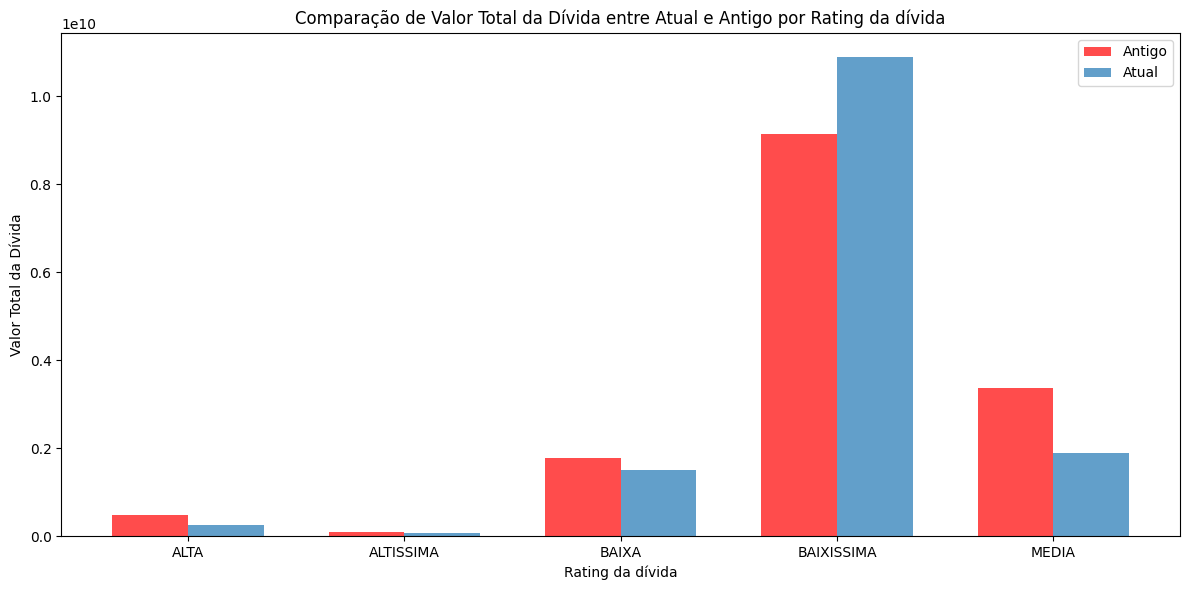

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Suponha que você tenha as métricas para o DataFrame atual (dados_igr) e antigo (dados_igr_antigo)
metricas_antigo = dados_igr_antigo[dados_igr_antigo['da_aberto'] == 1]
metricas_antigo = metricas_antigo.groupby('rating_divida')['valor_total_da'].sum().tolist()
print(metricas_antigo)

metricas_atual = baseline_prime[baseline_prime['da_aberto'] == 1]
metricas_atual = metricas_atual.groupby('rating_divida')['valor_total_da'].sum().tolist()
print(metricas_atual)

rating = ['ALTA', 'ALTISSIMA', 'BAIXA', 'BAIXISSIMA', 'MEDIA'] 
print(rating)

# Configurar a largura das barras e a posição dos grupos de barras
largura_barra = 0.35
posicao_barras = np.arange(len(rating))

plt.figure(figsize=(12, 6))
bar1 = plt.bar(posicao_barras - largura_barra/2, metricas_antigo, largura_barra, label='Antigo', alpha=0.7, color='red')
bar2 = plt.bar(posicao_barras + largura_barra/2, metricas_atual, largura_barra, label='Atual', alpha=0.7)

plt.xlabel('Rating da dívida')
plt.ylabel('Valor Total da Dívida')
plt.title('Comparação de Valor Total da Dívida entre Atual e Antigo por Rating da dívida')
plt.xticks(posicao_barras, rating)
plt.legend()

# Rótulos
# for bar in bar1 + bar2:
#     height = bar.get_height()
#     plt.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
#                  xytext=(0, 3), textcoords='offset points', ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [217]:
# Remove o prefixo 'imovel-' e 'mercantil-' da coluna 'cda' em dados_igr_antigo
dados_igr_antigo['cda'] = dados_igr_antigo['cda'].str.replace(r'^(imovel-|mercantil-)', '', regex=True)
dados_igr_antigo

,cda,id_contribuinte,da_aberto,da_paga,arrecadacao_divida,tipo_divida,valor_total_da,tipo_tributo_da,ano_inscricao_da,protesto,...,situacao,status_situacao,frequencia_da_pessoa,historico_pagamento_em_qtd,historico_pagamento_em_valor,class_contribuinte,class_contribuinte_nome,class_contribuinte_peso,igr,rating_divida
0,00000123c3d4731c6b3a8e268c80aedf,97283,1,0,0,imovel,2021.68,TAXAS,2022,0,...,ATIVO,3.0,5.0,1.000000,1.000000,2.0,BOM PAGADOR,3.79174,0.000000,BAIXISSIMA
1,0000331f601a73e52b46f673bf0c6125,284610,0,0,0,imovel,344.12,TAXAS,2012,0,...,ATIVO,3.0,13.0,1.604061,1.236472,2.0,BOM PAGADOR,3.79174,0.454788,ALTA
2,00003d46e618da886b3a8e268c80aedf,195314,1,0,0,imovel,6390.53,TAXAS,2011,0,...,EM PROCESSO DE BAIXA,0.0,9.0,1.000000,1.000000,1.0,PIOR PAGADOR,-1.37166,0.000000,BAIXISSIMA
3,00005193f0c1f57c6b3a8e268c80aedf,286654,1,0,0,imovel,419.70,TAXAS,2021,0,...,ATIVO,3.0,6.0,1.000000,1.000000,2.0,BOM PAGADOR,3.79174,0.010000,MEDIA
4,0000521b64bf28c8e52281a70553db46,261617,0,0,0,imovel,490.83,TAXAS,2016,0,...,ATIVO,3.0,19.0,1.000000,1.000000,2.0,BOM PAGADOR,3.79174,0.100000,ALTA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2617419,fffcfb3922e89baf6b3a8e268c80aedf,420678,0,1,2021-02-08 00:00:00,mercantil,73.18,ISS,2021,0,...,ATIVO,3.0,5.0,2.000000,2.000000,3.0,MELHOR PAGADOR,11.19087,0.863995,ALTISSIMA
2617420,fffd21aef5343e0e6b3a8e268c80aedf,387618,0,1,2018-06-22 00:00:00,mercantil,727.09,ISS,2018,0,...,ATIVO,3.0,1.0,1.000000,1.000000,4.0,PRIMEIRA DIVIDA,1.00000,0.030000,BAIXA
2617421,fffe69ada60a04979ceed47545e621dd,265760,0,1,2007-08-10 00:00:00,mercantil,285.26,ISS,2007,0,...,ATIVO,2.0,6.0,1.000000,1.000000,0.0,PAGADOR INTERMEDIARIO,1.00000,0.000000,BAIXISSIMA
2617422,fffe8ed282868b7d18565e26094f06ee,338797,0,1,2013-08-30 00:00:00,mercantil,354.82,ISS,2013,0,...,ATIVO,2.0,6.0,1.000000,1.000000,0.0,PAGADOR INTERMEDIARIO,1.00000,0.088086,MEDIA


In [218]:
dados_igr['cda'] = dados_igr['cda'].str[:-1]
dados_igr

,cda,id_contribuinte,da_aberto,da_paga,arrecadacao_divida,tipo_divida,valor_total_da,vlr_tributo,vlr_taxa,ano_inscricao_da,...,situacao,status_situacao,frequencia_da_pessoa,historico_pagamento_em_qtd,historico_pagamento_em_valor,class_contribuinte,class_contribuinte_nome,class_contribuinte_peso,igr,rating_divida
0,00000123c3d4731c6b3a8e268c80aedf,ac28642d7c82b33f,1,0,0,imovel,2048.73,762.08,1286.65,2022,...,ATIVO,3.0,12.0,0.000000,0.000000,2.0,BOM PAGADOR,4.34437,0.000000,BAIXISSIMA
1,0000331f601a73e52b46f673bf0c6125,870c08c252b25ad1,0,0,0,imovel,344.12,147.20,196.92,2012,...,ATIVO,3.0,10.0,0.636364,0.613801,3.0,MELHOR PAGADOR,13.63310,0.661022,ALTISSIMA
2,00003d46e618da886b3a8e268c80aedf,d8b23eda9800b9e3,1,0,0,imovel,6434.96,3409.70,3025.26,2011,...,EM PROCESSO DE BAIXA,0.0,5.0,0.000000,0.000000,1.0,PIOR PAGADOR,-1.57208,0.000000,BAIXISSIMA
3,00005193f0c1f57c6b3a8e268c80aedf,0bff42777c16d00c,1,0,0,imovel,424.62,306.52,118.10,2021,...,ATIVO,3.0,6.0,0.000000,0.000000,2.0,BOM PAGADOR,4.34437,0.000208,MEDIA
4,0000521b64bf28c8e52281a70553db46,b5df816e1786f0a3,0,0,0,imovel,490.83,245.50,245.33,2016,...,ATIVO,3.0,11.0,0.000000,0.000000,2.0,BOM PAGADOR,4.34437,0.027504,MEDIA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2642883,7d1f0a040c02580c9ceed47545e621dd,54bb0ab68bd0cea9,0,1,2005-05-30,mercantil,50.76,50.76,0.00,2005,...,0,0.0,0.0,0.000000,0.000000,0.0,PIOR PAGADOR,0.00000,0.000000,BAIXISSIMA
2642884,dc03a838a311285218565e26094f06ee,0eefd2cb64da619e,0,1,1997-10-13,mercantil,966.54,966.54,0.00,1997,...,ATIVO,1.0,10.0,0.000000,0.000000,0.0,PAGADOR INTERMEDIARIO,1.00000,0.000000,BAIXISSIMA
2642885,8fc444e6101dec7fe52281a70553db46,b8cbffe85d4f9241,0,1,2022-09-16,mercantil,1128.97,1128.97,0.00,2022,...,ATIVO,2.0,9.0,0.000000,0.000000,0.0,PAGADOR INTERMEDIARIO,1.00000,0.202733,MEDIA
2642886,09e5811e5ee649ece52281a70553db46,1f1f4e826b1c75d0,0,1,2023-07-07,mercantil,1533.53,1533.53,0.00,2023,...,ATIVO,1.0,6.0,0.000000,0.000000,0.0,PAGADOR INTERMEDIARIO,1.00000,0.232864,MEDIA


In [ ]:
dados_igr = dados_igr[dados_igr['da_aberto'] == 1]
dados_igr

In [ ]:
dados_igr_antigo = dados_igr_antigo[dados_igr_antigo['da_aberto'] == 1]
dados_igr_antigo

In [245]:
# Identificar CDAs que foram alteradas em relação ao último Rating
cdas_com_mudancas = dados_igr.merge(dados_igr_antigo, on='cda', how='left', suffixes=('_atual', '_antigo'))
cdas_com_mudancas = cdas_com_mudancas[cdas_com_mudancas['rating_divida_atual'] != cdas_com_mudancas['rating_divida_antigo']]
cdas_com_mudancas = cdas_com_mudancas[(cdas_com_mudancas['rating_divida_antigo'] == 'MEDIA') & (cdas_com_mudancas['rating_divida_atual'] == 'BAIXISSIMA')]
cdas_com_mudancas = cdas_com_mudancas[['cda', 'rating_divida_atual', 'rating_divida_antigo']]
cdas_com_mudancas = cdas_com_mudancas.dropna()
cdas_com_mudancas


,cda,rating_divida_atual,rating_divida_antigo
12,0001d4a8d7bcae284bd01ecb8277da0b,BAIXISSIMA,MEDIA
16,00023c9b70b099234bd01ecb8277da0b,BAIXISSIMA,MEDIA
20,000267b92b27d3909989bae6f4af91ee,BAIXISSIMA,MEDIA
23,0002cf45dcf68e46d8a3e5cebc255ca6,BAIXISSIMA,MEDIA
26,00031b7575194ca19fcacff532cf50c4,BAIXISSIMA,MEDIA
...,...,...,...
1341569,fff2be53b78a6fff18565e26094f06ee,BAIXISSIMA,MEDIA
1341575,fff64884dde03e9c2b46f673bf0c6125,BAIXISSIMA,MEDIA
1341577,fff6a5cb3f40db6fd8a3e5cebc255ca6,BAIXISSIMA,MEDIA
1341582,fffb3c7ed2169b38e52281a70553db46,BAIXISSIMA,MEDIA


In [237]:
cdas_filtradas = cdas_com_mudancas[(cdas_com_mudancas['rating_divida_antigo'] != 'BAIXISSIMA') &
                                   (cdas_com_mudancas['rating_divida_atual'] == 'BAIXISSIMA')]

num_cdas = len(cdas_filtradas)
num_cdas

1113454

In [235]:
cdas_migracao = cdas_com_mudancas[['cda', 'rating_divida_atual', 'rating_divida_antigo']]
matriz_migracao = pd.pivot_table(cdas_migracao, values='cda', index='rating_divida_antigo', columns='rating_divida_atual', aggfunc='nunique', fill_value=0)
matriz_migracao.columns.name = None
matriz_migracao.index.name = None

matriz_migracao = matriz_migracao[['BAIXISSIMA', 'BAIXA', 'MEDIA', 'ALTA','ALTISSIMA']]
matriz_migracao = matriz_migracao.reset_index()
matriz_migracao


,index,BAIXISSIMA,BAIXA,MEDIA,ALTA,ALTISSIMA
0,ALTA,102048,23200,53345,0,30122
1,ALTISSIMA,95043,19034,27606,25316,0
2,BAIXA,150705,0,58242,15945,14222
3,BAIXISSIMA,0,101202,185824,60511,64634
4,MEDIA,424781,152580,0,66114,45469


In [236]:
data_crosstab = pd.crosstab(cdas_migracao['rating_divida_antigo'],
                            cdas_migracao['rating_divida_atual'], 
                               margins = False)
data_crosstab

rating_divida_atual,ALTA,ALTISSIMA,BAIXA,BAIXISSIMA,MEDIA
rating_divida_antigo,,,,,
ALTA,0,48333,28103,132783,74047
ALTISSIMA,41588,0,24610,130136,38132
BAIXA,19738,18457,0,213368,75108
BAIXISSIMA,76784,86897,121473,0,239344
MEDIA,98014,65623,224200,637167,0


In [231]:
dict = {"rating_divida": ['ALTISSIMA', 'ALTA', 'MEDIA', 'BAIXA', 'BAIXISSIMA'],
        "ordem_rating": [4, 3, 2, 1, 0]}
df_ordenar_rating_divida = pd.DataFrame(dict)

matriz_migracao_ord = pd.merge(
    left = matriz_migracao,
    right = df_ordenar_rating_divida,
    right_on = 'rating_divida',
    left_on = 'index',
    how = "left"
)
matriz_migracao_ord.sort_values(by = 'ordem_rating', inplace = True)
matriz_migracao_ord = matriz_migracao_ord.drop(columns = 'index')
matriz_migracao_ord

,BAIXISSIMA,BAIXA,MEDIA,ALTA,ALTISSIMA,rating_divida,ordem_rating
3,0,101202,185824,60511,64634,BAIXISSIMA,0
2,150705,0,58242,15945,14222,BAIXA,1
4,424781,152580,0,66114,45469,MEDIA,2
0,102048,23200,53345,0,30122,ALTA,3
1,95043,19034,27606,25316,0,ALTISSIMA,4


In [68]:
contagem_valores_distintos = dados_igr1['ano_inscricao_da'].value_counts().reset_index()
contagem_valores_distintos.columns = ['Ano', 'Contagem']
contagem_valores_distintos

,Ano,Contagem
0,2014,247331
1,2022,224029
2,2018,207679
3,2017,204447
4,2012,192178
5,2016,188734
6,2020,182580
7,2013,149948
8,2021,134503
9,2019,128900


In [69]:
metrica_por_valor = dados_igr1.groupby('ano_inscricao_da')['valor_total_da'].sum()
metrica_por_valor = metrica_por_valor.reset_index().sort_values(by='valor_total_da', ascending=False)
metrica_por_valor['valor_total_da'] = metrica_por_valor['valor_total_da'].apply(formatar_moeda)
metrica_por_valor


,ano_inscricao_da,valor_total_da
13,1994,"R$ 13.261.475.685,36"
12,1993,"R$ 4.101.041.567,09"
14,1995,"R$ 1.397.418.405,72"
33,2014,"R$ 1.300.942.389,53"
18,1999,"R$ 1.240.462.696,30"
31,2012,"R$ 1.206.559.616,83"
17,1998,"R$ 1.102.211.572,63"
41,2022,"R$ 1.094.259.670,32"
20,2001,"R$ 1.043.220.989,33"
37,2018,"R$ 1.020.530.830,20"


In [84]:
df = dados_igr[dados_igr['ano_inscricao_da'] > 2013]
df

,cda,id_contribuinte,da_aberto,da_paga,arrecadacao_divida,tipo_divida,valor_total_da,vlr_tributo,vlr_taxa,ano_inscricao_da,...,situacao,status_situacao,frequencia_da_pessoa,historico_pagamento_em_qtd,historico_pagamento_em_valor,class_contribuinte,class_contribuinte_nome,class_contribuinte_peso,igr,rating_divida
0,00000123c3d4731c6b3a8e268c80aedf1,ac28642d7c82b33f,1,0,0,imovel,2048.73,762.08,1286.65,2022,...,ATIVO,3.0,12.0,0.000000,0.000000,2.0,BOM PAGADOR,4.34437,0.000000,BAIXISSIMA
3,00005193f0c1f57c6b3a8e268c80aedf1,0bff42777c16d00c,1,0,0,imovel,424.62,306.52,118.10,2021,...,ATIVO,3.0,6.0,0.000000,0.000000,2.0,BOM PAGADOR,4.34437,0.000208,MEDIA
4,0000521b64bf28c8e52281a70553db461,b5df816e1786f0a3,0,0,0,imovel,490.83,245.50,245.33,2016,...,ATIVO,3.0,11.0,0.000000,0.000000,2.0,BOM PAGADOR,4.34437,0.027504,MEDIA
5,000057f68f7b77276b3a8e268c80aedf1,e3df827c83c5efa8,0,0,0,imovel,1148.06,555.67,592.39,2018,...,ATIVO,3.0,14.0,0.300654,0.107526,2.0,BOM PAGADOR,4.34437,0.073177,MEDIA
6,0000662885c684004bd01ecb8277da0b1,5a0db67b0cafe538,1,0,0,imovel,13352.75,6050.58,7302.17,2014,...,ATIVO,3.0,4.0,0.000000,0.000000,2.0,BOM PAGADOR,4.34437,0.010941,MEDIA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2642880,67a72d1ed0015e2e9989bae6f4af91ee2,c8121a14f3ecdb43,0,1,2022-05-23,mercantil,398.57,398.57,0.00,2022,...,ATIVO,1.0,1.0,1.000000,1.000000,4.0,PRIMEIRA DIVIDA,4.34437,1.362190,ALTA
2642881,7df0909f8ea02e5318565e26094f06ee2,e95815f302d6969d,0,1,2018-01-31,mercantil,2802.20,2802.20,0.00,2018,...,ATIVO,2.0,13.0,0.011905,0.135863,0.0,PAGADOR INTERMEDIARIO,1.00000,1.338650,ALTA
2642882,dd4b4b1a2807f4d67c8fa7a67092eaab2,4d23bc4fdba893fb,0,1,2015-12-10,mercantil,434.91,434.91,0.00,2015,...,ATIVO,1.0,1.0,0.000000,0.000000,4.0,PRIMEIRA DIVIDA,4.34437,0.070943,BAIXA
2642885,8fc444e6101dec7fe52281a70553db46E,b8cbffe85d4f9241,0,1,2022-09-16,mercantil,1128.97,1128.97,0.00,2022,...,ATIVO,2.0,9.0,0.000000,0.000000,0.0,PAGADOR INTERMEDIARIO,1.00000,0.202733,MEDIA


In [87]:
df = dados_igr[dados_igr['da_paga'] == 0]
df

,cda,id_contribuinte,da_aberto,da_paga,arrecadacao_divida,tipo_divida,valor_total_da,vlr_tributo,vlr_taxa,ano_inscricao_da,...,situacao,status_situacao,frequencia_da_pessoa,historico_pagamento_em_qtd,historico_pagamento_em_valor,class_contribuinte,class_contribuinte_nome,class_contribuinte_peso,igr,rating_divida
0,00000123c3d4731c6b3a8e268c80aedf1,ac28642d7c82b33f,1,0,0,imovel,2048.73,762.08,1286.65,2022,...,ATIVO,3.0,12.0,0.000000,0.000000,2.0,BOM PAGADOR,4.34437,0.000000,BAIXISSIMA
1,0000331f601a73e52b46f673bf0c61251,870c08c252b25ad1,0,0,0,imovel,344.12,147.20,196.92,2012,...,ATIVO,3.0,10.0,0.636364,0.613801,3.0,MELHOR PAGADOR,13.63310,0.661022,ALTISSIMA
2,00003d46e618da886b3a8e268c80aedf1,d8b23eda9800b9e3,1,0,0,imovel,6434.96,3409.70,3025.26,2011,...,EM PROCESSO DE BAIXA,0.0,5.0,0.000000,0.000000,1.0,PIOR PAGADOR,-1.57208,0.000000,BAIXISSIMA
3,00005193f0c1f57c6b3a8e268c80aedf1,0bff42777c16d00c,1,0,0,imovel,424.62,306.52,118.10,2021,...,ATIVO,3.0,6.0,0.000000,0.000000,2.0,BOM PAGADOR,4.34437,0.000208,MEDIA
4,0000521b64bf28c8e52281a70553db461,b5df816e1786f0a3,0,0,0,imovel,490.83,245.50,245.33,2016,...,ATIVO,3.0,11.0,0.000000,0.000000,2.0,BOM PAGADOR,4.34437,0.027504,MEDIA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2577429,fffb3c7ed2169b38e52281a70553db46E,ced08de205bde459,1,0,0,mercantil,1088643.92,1088643.92,0.00,2013,...,ATIVO,1.0,16.0,0.000000,0.000000,0.0,PAGADOR INTERMEDIARIO,1.00000,0.080637,MEDIA
2577430,fffcadb55ce4e45318565e26094f06eeE,7c1313d91833caaf,1,0,0,mercantil,29762.32,29762.32,0.00,2022,...,ATIVO,1.0,2.0,0.000000,0.000000,0.0,PAGADOR INTERMEDIARIO,1.00000,0.010236,BAIXA
2577431,fffe75c5e436f4e69fcacff532cf50c42,eefe16fde5758b38,1,0,0,mercantil,2067.67,2067.67,0.00,2018,...,INAPTO,0.0,3.0,0.100000,0.072004,1.0,PIOR PAGADOR,-1.57208,0.000000,BAIXISSIMA
2577432,fffeb819f46062317c8fa7a67092eaab2,52da39231b917f91,1,0,0,mercantil,2850.29,2850.29,0.00,2016,...,ATIVO,3.0,5.0,0.000000,0.000000,2.0,BOM PAGADOR,4.34437,0.032721,MEDIA


In [88]:
metrica_por_ano = df.groupby('ano_inscricao_da')['valor_total_da'].sum()
metrica_por_ano = metrica_por_ano.reset_index().sort_values(by='ano_inscricao_da', ascending=True)
metrica_por_ano['valor_total_da'] = metrica_por_ano['valor_total_da'].apply(formatar_moeda)
metrica_por_ano

,ano_inscricao_da,valor_total_da
0,1980,"R$ 845.026,87"
1,1982,"R$ 781,20"
2,1983,"R$ 367.836,87"
3,1984,"R$ 8.145.566,78"
4,1985,"R$ 9.430.401,16"
5,1986,"R$ 6.383.402,89"
6,1987,"R$ 26.539.893,98"
7,1988,"R$ 6.494.848,71"
8,1989,"R$ 17.945.845,72"
9,1990,"R$ 226.471.669,51"


In [100]:
da_aberta = dados_igr_antigo[dados_igr_antigo['da_aberto'] == 1]
soma_valor_total_da = formatar_moeda(da_aberta['valor_total_da'].sum())
soma_valor_total_da

'R$ 14.867.154.258,78'

In [101]:
da_aberta = dados_igr[dados_igr['da_aberto'] == 1]
soma_valor_total_da = formatar_moeda(da_aberta['valor_total_da'].sum())
soma_valor_total_da

'R$ 14.610.658.571,53'

## MÉTRICAS PARA ORDENAÇÃO DE VALORES DO RATING POR FAIXAS E CLASSIFICAÇÃO

In [147]:
filtro = (
    (dados_igr_antigo['da_aberto'] == 1) &
    (dados_igr_antigo['rating_divida'] == 'BAIXA') 
    #(dados_igr['protesto'] == 0) &
    #(dados_igr['ajuizamento'] == 0) &
    #(dados_igr['anos_idade_da'] >= 0) & (dados_igr['anos_idade_da'] <= 3) &
    #(dados_igr_antigo['igr'] > 0) & (dados_igr_antigo['igr'] <= 0.05) &
    #(dados_igr_antigo['class_contribuinte_nome'] == 'PAGADOR INTERMEDIARIO')
)

resultado = dados_igr_antigo.loc[filtro, 'valor_total_da'].sum()

valor_formatado = formatar_moeda(resultado)
valor_formatado

'R$ 1.770.251.147,02'

---

---

In [43]:
caminho_arquivo_csv = r'C:\Users\Consultor\Documents\bases_pesquisa\verificacao\tp_imovel.csv'

# Lê o arquivo CSV e cria um DataFrame
base_tipo_imovel = pd.read_csv(caminho_arquivo_csv)

In [44]:
def categorizar_registro(row):
    if pd.notna(row['cnpj_unico']) and pd.notna(row['cpf_unico']):
        return 'ANOMALIA'
    elif pd.notna(row['cnpj_unico']):
        return 'PJ'
    elif pd.notna(row['cpf_unico']):
        return 'PF'
    else:
        return 'DESCONHECIDO'

In [45]:
base_tipo_imovel['natureza'] = base_tipo_imovel.apply(categorizar_registro, axis=1)
base_tipo_imovel = base_tipo_imovel.drop(columns=['cnpj_unico', 'cpf_unico'])
base_tipo_imovel 

,termo_da_unico,tipo_propriedade_resp,natureza
0,1c15d4d5202cf8eb18565e26094f06ee,CASA,PF
1,1e4b0edd82ad69b5e52281a70553db46,SALA,PF
2,4825267bf5363fcb6b3a8e268c80aedf,APARTAMENTO,PF
3,44329229fa0af4d36b3a8e268c80aedf,LOJA,PF
4,8d74795df5ed556d2b46f673bf0c6125,CASA,PF
...,...,...,...
877314,5fb2263b62dadd1e18565e26094f06ee,CASA,PF
877315,60ac5e92e6a29c326b3a8e268c80aedf,APARTAMENTO,PF
877316,3541eff40a492fa76b3a8e268c80aedf,CASA,PF
877317,aebb5e93b3ef8faa2b46f673bf0c6125,CASA,PF


In [47]:
dados_igr['cda'] = dados_igr['cda'].str.replace('imovel-', '')

dados_igr

,cda,id_contribuinte,da_aberto,da_paga,arrecadacao_divida,tipo_divida,valor_total_da,tipo_tributo_da,ano_inscricao_da,protesto,...,situacao,status_situacao,frequencia_da_pessoa,historico_pagamento_em_qtd,historico_pagamento_em_valor,class_contribuinte,class_contribuinte_nome,class_contribuinte_peso,igr,rating_divida
0,00000123c3d4731c6b3a8e268c80aedf,97283,1,0,0,imovel,2021.68,TAXAS,2022,0,...,ATIVO,3.0,5.0,1.000000,1.000000,2.0,BOM PAGADOR,3.79174,0.000000,BAIXISSIMA
1,0000331f601a73e52b46f673bf0c6125,284610,0,0,0,imovel,344.12,TAXAS,2012,0,...,ATIVO,3.0,13.0,1.604061,1.236472,2.0,BOM PAGADOR,3.79174,0.454788,ALTA
2,00003d46e618da886b3a8e268c80aedf,195314,1,0,0,imovel,6390.53,TAXAS,2011,0,...,EM PROCESSO DE BAIXA,0.0,9.0,1.000000,1.000000,1.0,PIOR PAGADOR,-1.37166,0.000000,BAIXISSIMA
3,00005193f0c1f57c6b3a8e268c80aedf,286654,1,0,0,imovel,419.70,TAXAS,2021,0,...,ATIVO,3.0,6.0,1.000000,1.000000,2.0,BOM PAGADOR,3.79174,0.010000,MEDIA
4,0000521b64bf28c8e52281a70553db46,261617,0,0,0,imovel,490.83,TAXAS,2016,0,...,ATIVO,3.0,19.0,1.000000,1.000000,2.0,BOM PAGADOR,3.79174,0.100000,ALTA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2617419,mercantil-fffcfb3922e89baf6b3a8e268c80aedf,420678,0,1,2021-02-08 00:00:00,mercantil,73.18,ISS,2021,0,...,ATIVO,3.0,5.0,2.000000,2.000000,3.0,MELHOR PAGADOR,11.19087,0.863995,ALTISSIMA
2617420,mercantil-fffd21aef5343e0e6b3a8e268c80aedf,387618,0,1,2018-06-22 00:00:00,mercantil,727.09,ISS,2018,0,...,ATIVO,3.0,1.0,1.000000,1.000000,4.0,PRIMEIRA DIVIDA,1.00000,0.030000,BAIXA
2617421,mercantil-fffe69ada60a04979ceed47545e621dd,265760,0,1,2007-08-10 00:00:00,mercantil,285.26,ISS,2007,0,...,ATIVO,2.0,6.0,1.000000,1.000000,0.0,PAGADOR INTERMEDIARIO,1.00000,0.000000,BAIXISSIMA
2617422,mercantil-fffe8ed282868b7d18565e26094f06ee,338797,0,1,2013-08-30 00:00:00,mercantil,354.82,ISS,2013,0,...,ATIVO,2.0,6.0,1.000000,1.000000,0.0,PAGADOR INTERMEDIARIO,1.00000,0.088086,MEDIA


In [28]:
import locale

locale.setlocale(locale.LC_ALL, 'pt_BR.utf8')

filtro = (
    (dados_igr['da_aberto'] == 1) &
    (dados_igr['status_situacao'] == 0) &
    (dados_igr['rating_divida'] == 'BAIXISSIMA') &
    (dados_igr['tipo_divida'] == 'imovel') &
    #(dados_igr['tipo_tributo_da'] == 'IPTU') &
    (dados_igr['class_contribuinte_nome'] == 'PRIMEIRA DIVIDA')
)

total_somado = dados_igr.loc[filtro, 'valor_total_da'].sum()

valor_formatado = locale.currency(total_somado, grouping=True)

print("TOTAL:", valor_formatado)

df_filtrado = dados_igr[filtro][['id_contribuinte', 'cda', 'valor_total_da', 'class_contribuinte_nome', 'rating_divida', 'status_situacao', 'ano_inscricao_da', 'tipo_tributo_da',
'igr']]
df_filtrado


TOTAL: R$ 15.204.258,97


,id_contribuinte,cda,valor_total_da,class_contribuinte_nome,rating_divida,status_situacao,ano_inscricao_da,tipo_tributo_da,igr
899,169935,imovel-0034e3415ab79a9b2b46f673bf0c6125,6464.66,PRIMEIRA DIVIDA,BAIXISSIMA,0.0,1987,TAXAS,0.0
7845,328519,imovel-01dae237e72091eeb5eae1a923f0f870,2038.37,PRIMEIRA DIVIDA,BAIXISSIMA,0.0,1998,TAXAS,0.0
9793,112005,imovel-02542285dbd27b2818565e26094f06ee,2718.97,PRIMEIRA DIVIDA,BAIXISSIMA,0.0,1996,IPTU,0.0
10157,253456,imovel-026cc6e2d6f054ef9fcacff532cf50c4,40696.78,PRIMEIRA DIVIDA,BAIXISSIMA,0.0,1995,TAXAS,0.0
14942,295285,imovel-038a4c84838f2d209ceed47545e621dd,6376.42,PRIMEIRA DIVIDA,BAIXISSIMA,0.0,2008,TAXAS,0.0
...,...,...,...,...,...,...,...,...,...
2244860,422298,imovel-f816a2dec4a430d24bd01ecb8277da0b,405.03,PRIMEIRA DIVIDA,BAIXISSIMA,0.0,2019,IPTU,0.0
2245087,481415,imovel-f8c57a8a5dbcc494b5eae1a923f0f870,2222.98,PRIMEIRA DIVIDA,BAIXISSIMA,0.0,2019,IPTU,0.0
2245198,444211,imovel-f90a6831433539d79989bae6f4af91ee,1369.15,PRIMEIRA DIVIDA,BAIXISSIMA,0.0,2020,IPTU,0.0
2245416,43003,imovel-f9a2fdcf3582cc0118565e26094f06ee,1630.87,PRIMEIRA DIVIDA,BAIXISSIMA,0.0,2022,IPTU,0.0


In [170]:
locale.setlocale(locale.LC_ALL, 'pt_BR.utf8')

filtro = (
    (dados_igr['da_aberto'] == 1) &
    (dados_igr['rating_divida'] == 'ALTISSIMA') | (dados_igr['rating_divida'] == 'ALTA') | (dados_igr['rating_divida'] == 'MEDIA') &
    (dados_igr['tipo_divida'] == 'imovel') &
    #(dados_igr['tipo_tributo_da'] == 'IPTU') &
    #(dados_igr['igr'] > 0) & (dados_igr['igr'] <=1) &
    #(dados_igr['valor_total_da'] < 3000) &
    #(dados_igr['anos_idade_da'] == 3)
    (dados_igr['class_contribuinte_nome'] == 'MELHOR PAGADOR') | (dados_igr['class_contribuinte_nome'] == 'BOM PAGADOR') |
    (dados_igr['class_contribuinte_nome'] == 'PRIMEIRA DIVIDA') | (dados_igr['class_contribuinte_nome'] == 'PAGADOR INTERMEDIARIO')
    #(dados_igr['qtd_notas_2anos']==0)
)

df_filtrado = dados_igr[filtro][['id_contribuinte', 'cda', 'valor_total_da', 'qtd_notas_2anos', 'anos_idade_da']]
#df_filtrado = df_filtrado.head(10)
valor_total = df_filtrado['valor_total_da'].sum()
valor_formatado = locale.currency(valor_total, grouping=True)

print("TOTAL:", valor_formatado)

df_filtrado

# caminho_arquivo_csv = r'C:\Users\Consultor\resultados\pagador-pior\dez-CDAS.csv'

# df_filtrado.to_csv(caminho_arquivo_csv, index=False)

# print("Arquivo CSV gerado com sucesso:", caminho_arquivo_csv)



TOTAL: R$ 24.225.716.843,86


,id_contribuinte,cda,valor_total_da,qtd_notas_2anos,anos_idade_da
0,97283,imovel-00000123c3d4731c6b3a8e268c80aedf,2021.68,0.0,1
1,284610,imovel-0000331f601a73e52b46f673bf0c6125,344.12,0.0,11
3,286654,imovel-00005193f0c1f57c6b3a8e268c80aedf,419.70,0.0,2
4,261617,imovel-0000521b64bf28c8e52281a70553db46,490.83,0.0,7
5,291863,imovel-000057f68f7b77276b3a8e268c80aedf,1148.06,0.0,5
...,...,...,...,...,...
2617416,575988,mercantil-fffc0022030124252b46f673bf0c6125,645.27,13.0,2
2617418,294589,mercantil-fffcccfa32d327d09ceed47545e621dd,44.01,0.0,20
2617420,387618,mercantil-fffd21aef5343e0e6b3a8e268c80aedf,727.09,0.0,5
2617421,265760,mercantil-fffe69ada60a04979ceed47545e621dd,285.26,0.0,16


In [186]:
import locale

locale.setlocale(locale.LC_ALL, 'pt_BR.utf8')

# Filtrar e contar as CDAs únicas em aberto que seguem as regras de classificação
cdas_atendem_condicoes = dados_igr[
    (dados_igr['da_aberto'] == 1) &
    #(dados_igr['rating_divida'] == 'MEDIA') &
    #(dados_igr['igr'] > 0.05) & (dados_igr['igr'] <= 0.1) &
    (dados_igr['class_contribuinte_nome'] == 'MELHOR PAGADOR')
]['cda'].nunique()

print("Quantidade de CDAs únicas que atendem às condições:", cdas_atendem_condicoes)

    

Quantidade de CDAs únicas que atendem às condições: 16902


## verificando realação de cdas duplicadas

In [194]:
import locale
import pandas as pd

locale.setlocale(locale.LC_ALL, 'pt_BR.utf8')

dados_igr['duplicada'] = dados_igr.duplicated(subset=['cda'], keep=False)

# Filtrar para mostrar apenas as CDAs que estão duplicadas e seus IDs de contribuinte
cdas_duplicadas_com_ids = dados_igr[
    (dados_igr['da_aberto'] == 1) &
    (dados_igr['class_contribuinte_nome'] == 'BOM PAGADOR') &
    (dados_igr['duplicada'] == True)
][['cda', 'id_contribuinte']]

# Criar um DataFrame para mostrar cada CDA duplicada com seus IDs de contribuinte
result_df = pd.DataFrame()
for cda, ids in cdas_duplicadas_com_ids.groupby('cda')['id_contribuinte']:
    if len(ids) > 1:
        temp_df = pd.DataFrame({'cda': [cda] * len(ids), 'id_contribuinte': ids})
        result_df = pd.concat([result_df, temp_df], ignore_index=True)

# Remover a coluna temporária "duplicada"
dados_igr = dados_igr.drop(columns=['duplicada'])

print("CDAs duplicadas com seus IDs de contribuinte:")
result_df



CDAs duplicadas com seus IDs de contribuinte:


,cda,id_contribuinte
0,imovel-4fe3b38e596bfd7d9fcacff532cf50c4,86971
1,imovel-4fe3b38e596bfd7d9fcacff532cf50c4,86971
2,imovel-5e42cae7d2717b9d6b3a8e268c80aedf,112524
3,imovel-5e42cae7d2717b9d6b3a8e268c80aedf,112524
4,imovel-755c5936970d52da9989bae6f4af91ee,130300
...,...,...
555,mercantil-fd949da10e9213c1e52281a70553db46,479397
556,mercantil-feb610bf8b6abcf79ceed47545e621dd,275604
557,mercantil-feb610bf8b6abcf79ceed47545e621dd,280884
558,mercantil-fed30dd677b3228a6b3a8e268c80aedf,268892


In [196]:
import pandas as pd

# Supondo que você já tenha carregado os dados em um DataFrame chamado "dados_igr"
# Vamos criar uma coluna "duplicada" que indica se cada CDA está duplicada
dados_igr['duplicada'] = dados_igr.duplicated(subset=['cda'], keep=False)

# Filtrar para mostrar apenas as CDAs que estão duplicadas e têm o ID do contribuinte igual a 86971
cdas_duplicadas_com_ids = dados_igr[
    (dados_igr['da_aberto'] == 1) &
    (dados_igr['class_contribuinte_nome'] == 'BOM PAGADOR') &
    (dados_igr['duplicada'] == True) &
    (dados_igr['id_contribuinte'] == 86971)
][['cda', 'id_contribuinte']]

# Remover a coluna temporária "duplicada"
dados_igr = dados_igr.drop(columns=['duplicada'])

print("CDAs duplicadas com o ID de contribuinte igual a 86971:")
cdas_duplicadas_com_ids


CDAs duplicadas com o ID de contribuinte igual a 86971:


,cda,id_contribuinte
338383,imovel-4fe3b38e596bfd7d9fcacff532cf50c4,86971
2184859,imovel-4fe3b38e596bfd7d9fcacff532cf50c4,86971


# 02) Processamento da feature store

In [6]:
print("Variáveis sobre as dívidas:")
print("\n", dados_divida.columns)

Variáveis sobre as dívidas:

 Index(['cda', 'id_pessoa', 'tipo_divida', 'valor_total_da', 'valor_pago',
       'tipo_tributo_da', 'divida_protestada', 'divida_ajuizada',
       'ano_inscricao_da', 'anos_idade_da', 'percentual_pago_cda',
       'quantidade_reparcelamentos', 'parcela_taxa_pagamento_valor'],
      dtype='object')


In [7]:
print("Variáveis dos constribuintes:")
print("\n", dados_contribuinte.columns)

Variáveis dos constribuintes:

 Index(['id_pessoa', 'situacao', 'cpf_existe', 'edificacao', 'qtd_notas_2anos',
       'situacao_ativa', 'status_situacao', 'deb_totais', 'deb_pagos',
       'valor_tot', 'valor_pago', 'frequencia_da_pessoa',
       'total_debitos_pessoa', 'debitos_pagos_pessoa', 'valor_total_pessoa',
       'valor_pago_pessoa', 'historico_pagamento_em_qtd',
       'historico_pagamento_em_valor', 'class_contribuinte',
       'class_contribuinte_nome', 'class_contribuinte_peso'],
      dtype='object')


In [8]:
# Filtrando variáveis de interesse para a modelagem

df_divida = dados_divida[['cda', 'id_pessoa', 'percentual_pago_cda', 'valor_total_da', 'anos_idade_da', 'quantidade_reparcelamentos']]
df_contribuinte = dados_contribuinte[['id_pessoa', 'frequencia_da_pessoa', 'historico_pagamento_em_qtd', 'status_situacao', 'historico_pagamento_em_valor', 'class_contribuinte_peso']]

In [9]:
df = pd.merge(left=df_divida, right=df_contribuinte, left_on='id_pessoa', right_on='id_pessoa')

In [10]:
# Filtrando apenas dados recentes para treinamento
df = df.query("anos_idade_da < 10")

In [11]:
print("Informações sobre o dataframe:\n")
df.info()

print("\nEstatísticas descritivas:")
df.describe().T

Informações sobre o dataframe:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1284798 entries, 0 to 2156894
Data columns (total 11 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0   cda                           1284798 non-null  object 
 1   id_pessoa                     1284798 non-null  int64  
 2   percentual_pago_cda           1284798 non-null  float64
 3   valor_total_da                1284798 non-null  float64
 4   anos_idade_da                 1284798 non-null  int64  
 5   quantidade_reparcelamentos    97395 non-null    float64
 6   frequencia_da_pessoa          1284798 non-null  int64  
 7   historico_pagamento_em_qtd    1284798 non-null  float64
 8   status_situacao               1284798 non-null  float64
 9   historico_pagamento_em_valor  1284798 non-null  float64
 10  class_contribuinte_peso       1284798 non-null  float64
dtypes: float64(7), int64(3), object(1)
memory usage: 117.6+ M

,count,mean,std,min,25%,50%,75%,max
id_pessoa,1284798.0,271602.985206,152057.468588,1.00000,151578.25,273139.5,390170.750000,7.865140e+05
percentual_pago_cda,1284798.0,0.113039,0.316401,0.00000,0.00,0.0,0.000000,1.000000e+00
valor_total_da,1284798.0,4901.798344,103530.839613,0.02000,785.02,1676.6,4036.962500,1.007758e+08
anos_idade_da,1284798.0,4.962701,2.657645,0.00000,3.00,5.0,7.000000,9.000000e+00
quantidade_reparcelamentos,97395.0,0.737574,0.784457,0.00000,0.00,1.0,1.000000,1.100000e+01
frequencia_da_pessoa,1284798.0,9.412305,5.253670,1.00000,5.00,9.0,12.000000,4.100000e+01
historico_pagamento_em_qtd,1284798.0,1.117911,0.265048,1.00000,1.00,1.0,1.005900,2.000000e+00
status_situacao,1284798.0,2.075063,1.108362,0.00000,2.00,2.0,3.000000,3.000000e+00
historico_pagamento_em_valor,1284798.0,1.090887,0.239133,1.00000,1.00,1.0,1.001027,2.000000e+00
class_contribuinte_peso,1284798.0,2.414001,3.089722,-1.37166,1.00,1.0,3.791740,1.119087e+01


In [12]:
# Retirando variáveis que não serão usadas no modelo

df_feature_store = df.drop(columns=['cda', 'id_pessoa'])

In [13]:
df_feature_store.isnull().sum()

percentual_pago_cda                   0
valor_total_da                        0
anos_idade_da                         0
quantidade_reparcelamentos      1187403
frequencia_da_pessoa                  0
historico_pagamento_em_qtd            0
status_situacao                       0
historico_pagamento_em_valor          0
class_contribuinte_peso               0
dtype: int64

In [14]:
# Substituindo valores vazios

df_feature_store['quantidade_reparcelamentos'] = df_feature_store['quantidade_reparcelamentos'].fillna(0)

# 03) Visualizando a variável target

In [15]:
matriz_correlacao = df_feature_store.corr()

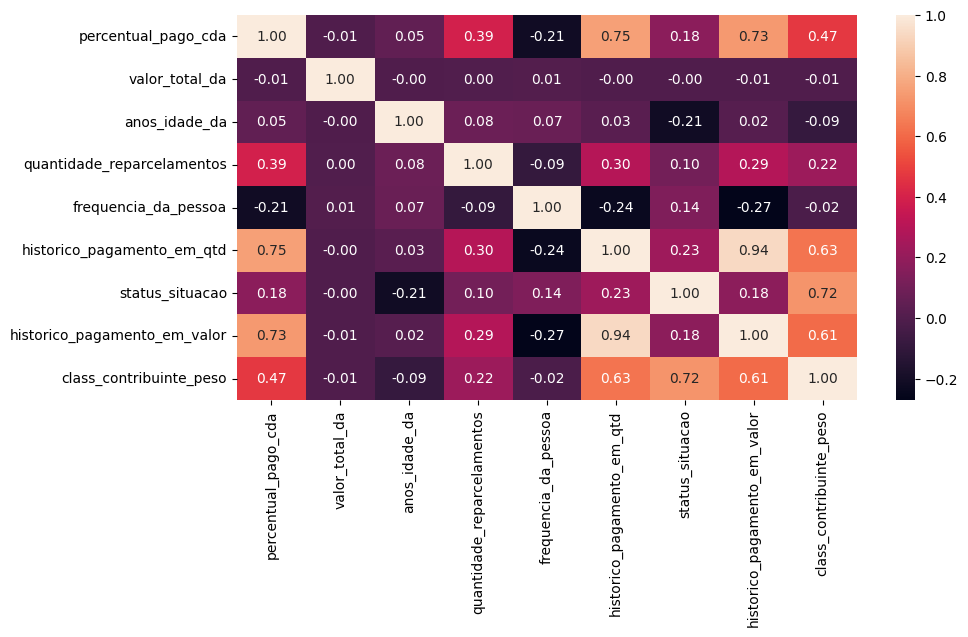

In [16]:
plt.figure(figsize=(10,5))
sns.heatmap(matriz_correlacao, annot = True, fmt = ".2f")
plt.show()

# 04) Definindo pipeline de treinamento dos modelos

In [17]:
seed = 1337 # Semente fixando a aleatoridade dos experimentos

In [18]:
y = df_feature_store['percentual_pago_cda']
x = df_feature_store.drop(columns=['percentual_pago_cda'])

X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=seed, test_size=0.3)

In [19]:
def roda_pipeline(algoritimo_normalizador, algoritimo_regressao, X_train, y_train, X_test, y_test):

    pipeline = Pipeline([('scaler', algoritimo_normalizador), ('regressor', algoritimo_regressao)])
    pipeline.fit(X_train, y_train)

    previsoes = pipeline.predict(X_test)

    r2 = r2_score(y_test, previsoes)
    mse = mean_squared_error(y_test, previsoes)
    
    print("\nModelo treinado:", str(algoritimo_regressao))
    print("R2 ->", r2)
    print("MSE ->", mse)

In [20]:
biblioteca_modelos = {
    'dummy': DummyRegressor(), # Dados dummy - Usado para baseline
    'random_forest': RandomForestRegressor(random_state=seed)
}

pipeline_modelos = ['dummy','random_forest']

# 05) Executando o experimento de treinamento do modelo

In [21]:
for modelos in pipeline_modelos:
    roda_pipeline(
        algoritimo_normalizador= StandardScaler(),
        algoritimo_regressao= biblioteca_modelos.get(modelos), 
        X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test
    )


Modelo treinado: DummyRegressor()
R2 -> -2.3698973752317443e-06
MSE -> 0.10036384506789614

Modelo treinado: RandomForestRegressor(random_state=1337)
R2 -> 0.8149703925916137
MSE -> 0.01857023884134864


In [24]:
for modelos in pipeline_modelos:
    roda_pipeline(
        algoritimo_normalizador= MinMaxScaler(),
        algoritimo_regressao= biblioteca_modelos.get(modelos), 
        X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test
    )


Modelo treinado: DummyRegressor()
R2 -> -2.3698973752317443e-06
MSE -> 0.10036384506789614

Modelo treinado: RandomForestRegressor(random_state=1337)
R2 -> 0.8052799528356089
MSE -> 0.019542806330774938


**Conclusão:** 
- Melhor modelo apresenta MSE menor que o Dummy
- A normalização pelo método StandartScale se provou ser a mais robusta
- O modelo apresenta pouca variáção do MSE ao acrescentar ou retirar variáveis, enquanto o R2 ajustado auemnta com a quantidade de variáveis

# 06) Realizando previsões com o melhor modelo

In [25]:
normalizador = StandardScaler()
normalizador.fit(x)
dados_normalizados = normalizador.fit_transform(x)

colunas = list(normalizador.get_feature_names_out())
df_normalizado = pd.DataFrame(dados_normalizados, columns=colunas)

In [26]:
x_norm = df_normalizado

In [27]:
X_train, X_test, y_train, y_test = train_test_split(x_norm, y, random_state=seed, test_size=0.3)

In [28]:
best_model = RandomForestRegressor(random_state=seed)
best_model.fit(X_train, y_train)

RandomForestRegressor(random_state=1337)

In [29]:
predict_test = best_model.predict(X_test)

r2 = r2_score(y_test, predict_test)
mse = mean_squared_error(y_test, predict_test)

print("Métricas de validação do modelo:")
print("R2 ->", r2)
print("MSE ->", mse)

Métricas de validação do modelo:
R2 -> 0.8150121442913045
MSE -> 0.018566048490160254


In [30]:
best_model.get_params() # Parâmetros utilizados

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1337,
 'verbose': 0,
 'warm_start': False}

In [31]:
variaveis_preditoras = best_model.feature_names_in_
importancia_variaveis = best_model.feature_importances_

print("Variáveis preditoras:")
print('\n', variaveis_preditoras)

Variáveis preditoras:

 ['valor_total_da' 'anos_idade_da' 'quantidade_reparcelamentos'
 'frequencia_da_pessoa' 'historico_pagamento_em_qtd' 'status_situacao'
 'historico_pagamento_em_valor' 'class_contribuinte_peso']


In [32]:
dados_features = {
    'features': variaveis_preditoras,
    'importancia': importancia_variaveis
}
matriz_importancia = pd.DataFrame(dados_features).sort_values('importancia', ascending=False).reset_index(drop='index')
matriz_importancia

,features,importancia
0,historico_pagamento_em_qtd,0.625389
1,valor_total_da,0.141416
2,historico_pagamento_em_valor,0.076334
3,quantidade_reparcelamentos,0.069144
4,anos_idade_da,0.047450
5,frequencia_da_pessoa,0.031712
6,status_situacao,0.004618
7,class_contribuinte_peso,0.003936


In [33]:
# Realizando predições para avaliações do modelo

previsoes_norm = best_model.predict(x_norm)

In [34]:
# Gerando resíduos da predição (observado - previsão)
df_feature_store['y_predict'] = previsoes_norm
df_feature_store['residuos'] =  df_feature_store['percentual_pago_cda'] - df_feature_store['y_predict']

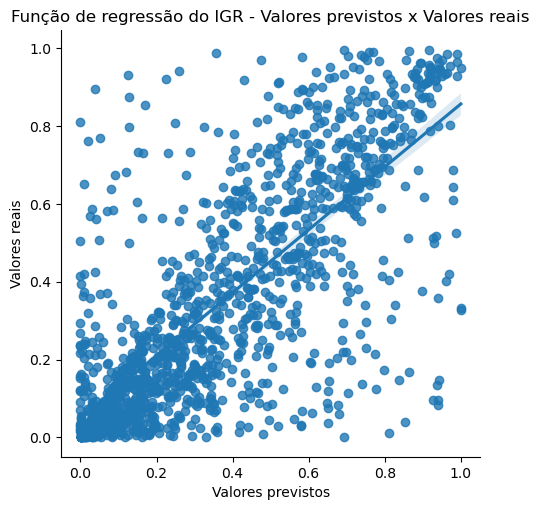

In [35]:
df_regerssao = df_feature_store.query("percentual_pago_cda != 1").query("percentual_pago_cda != 0")

sns.lmplot(x='y_predict' , y='percentual_pago_cda', data=df_regerssao)

plt.title("Função de regressão do IGR - Valores previstos x Valores reais")
plt.xlabel("Valores previstos")
plt.ylabel("Valores reais")

plt.show()

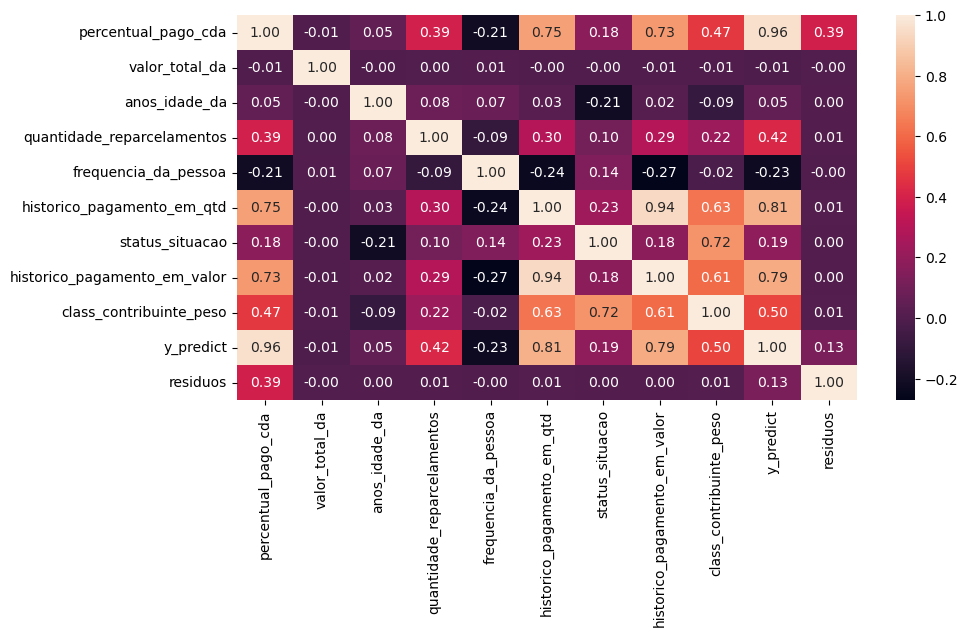

In [36]:
matriz_corr_regressao = df_feature_store.corr()
plt.figure(figsize=(10,5))
sns.heatmap(matriz_corr_regressao, annot = True, fmt = ".2f")
plt.show()

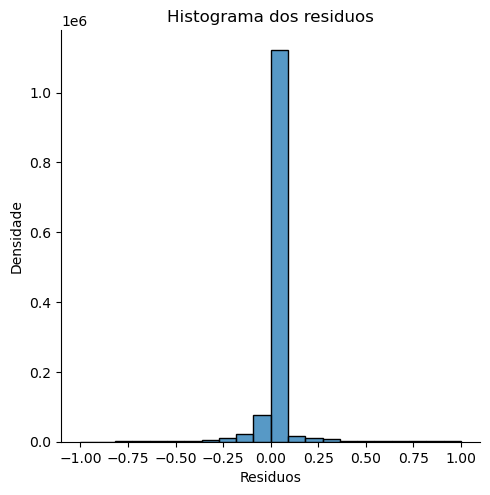

In [37]:
sns.displot(x='residuos', data=df_feature_store)

plt.title("Histograma dos residuos")
plt.xlabel("Residuos")
plt.ylabel("Densidade")

plt.show()

# 07) Salvando o melhor modelo

In [38]:
def salva_modelo_serializado(nome_modelo_serializado, modelo):
    sav_best_model = open(nome_modelo_serializado, 'wb')
    pickle.dump(modelo, sav_best_model)
    sav_best_model.close()

    pathModelo = modelsPath+"\\"+os.path.join(nome_modelo_serializado)
    shutil.move(os.path.abspath(nome_modelo_serializado), pathModelo)

In [39]:
salva_modelo_serializado("modeloDA-igr-divida-v1.pkl", best_model)